In [1]:
from IPython.display import HTML

def new_section(title):
    style = "text-align:center;background:#468499;padding:25px;color:#ffffff;font-size:3em;"
    return HTML('<div style="{}">{}</div>'.format(style, title))
def new_title(title):
    style = "text-align:center;background:#468499;padding:25px;color:#ffffff;font-size:4em;"
    return HTML('<div style="{}">{}</div>'.format(style, title))

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
new_title("Housing")

<img src="./images/banner.jpg",width=1920,height=540>

The purpose of this workook is to present my work on the housing dataset. The objective is to provide an accurate estimate of a house based on a wide range of parameters.

In [3]:
new_section("Table of Content")

**1. Introduction**
    1. Import libraries and modules
    2. Load data
    3. Explore data  
**2. Data Preparation**
    1. Outliers
    2. Missing values

In [4]:
new_section("1. Introduction")

In [5]:
# import libraries
import pandas as pd
import numpy as np
np.set_printoptions(threshold=np.nan)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
mycols = ["#66c2ff", "#5cd6d6", "#00cc99", "#85e085", "#ffd966", "#ffb366", "#ffb3b3", "#dab3ff", "#c2c2d6"]
sns.set_palette(palette = mycols, n_colors = 4)

from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats.stats import pearsonr

from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV, ShuffleSplit

import xgboost as xgb

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

decimals = 2
%matplotlib inline

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [6]:
# load data
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

# save ID
train_ID = train['Id']
test_ID = test['Id']

# drop iD
del train['Id']
del test['Id']

# investigate shapes
print('Train shape:', train.shape)
print('Test shape:', test.shape)

Train shape: (1460, 80)
Test shape: (1459, 79)


In [7]:
# list features
print('List of features:')
print(train.columns)

List of features:
Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
      

The features are defined as:
- Order (Discrete): Observation number
- PID (Nominal): Parcel identification number  - can be used with city web site for parcel review. 
- MS SubClass (Nominal): Identifies the type of dwelling involved in the sale.	
- MS Zoning (Nominal): Identifies the general zoning classification of the sale.
- Lot Frontage (Continuous): Linear feet of street connected to property
- Lot Area (Continuous): Lot size in square feet
- Street (Nominal): Type of road access to property      	
- Alley (Nominal): Type of alley access to property
- Lot Shape (Ordinal): General shape of property     
- Land Contour (Nominal): Flatness of the property
- Utilities (Ordinal): Type of utilities available
- Lot Config (Nominal): Lot configuration
- Land Slope (Ordinal): Slope of property
- Neighborhood (Nominal): Physical locations within Ames city limits (map available)
- Condition 1 (Nominal): Proximity to various conditions
- Condition 2 (Nominal): Proximity to various conditions (if more than one is present)
- Bldg Type (Nominal): Type of dwelling
- House Style (Nominal): Style of dwelling
- Overall Qual (Ordinal): Rates the overall material and finish of the house
- Overall Cond (Ordinal): Rates the overall condition of the house
- Year Built (Discrete): Original construction date
- Year Remod/Add (Discrete): Remodel date (same as construction date if no remodeling or additions)
- Roof Style (Nominal): Type of roof
- Roof Matl (Nominal): Roof material
- Exterior 1 (Nominal): Exterior covering on house
- Exterior 2 (Nominal): Exterior covering on house (if more than one material)
- Mas Vnr Type (Nominal): Masonry veneer type
- Mas Vnr Area (Continuous): Masonry veneer area in square feet
- Exter Qual (Ordinal): Evaluates the quality of the material on the exterior 
- Exter Cond (Ordinal): Evaluates the present condition of the material on the exterior
- Foundation (Nominal): Type of foundation
- Bsmt Qual (Ordinal): Evaluates the height of the basement
- Bsmt Cond (Ordinal): Evaluates the general condition of the basement
- Bsmt Exposure	(Ordinal): Refers to walkout or garden level walls
- BsmtFin Type 1	(Ordinal): Rating of basement finished area
- BsmtFin SF 1 (Continuous): Type 1 finished square feet
- BsmtFinType 2	(Ordinal): Rating of basement finished area (if multiple types)
- BsmtFin SF 2 (Continuous): Type 2 finished square feet
- Bsmt Unf SF (Continuous): Unfinished square feet of basement area
- Total Bsmt SF (Continuous): Total square feet of basement area
- Heating	(Nominal): Type of heating
- HeatingQC (Ordinal): Heating quality and condition
- Central Air (Nominal): Central air conditioning
- Electrical (Ordinal): Electrical system
- 1st Flr SF (Continuous): First Floor square feet
- 2nd Flr SF (Continuous)	: Second floor square feet
- Low Qual Fin SF (Continuous): Low quality finished square feet (all floors)
- Gr Liv Area (Continuous): Above grade (ground) living area square feet
- Bsmt Full Bath (Discrete): Basement full bathrooms
- Bsmt Half Bath (Discrete): Basement half bathrooms
- Full Bath (Discrete): Full bathrooms above grade
- Half Bath (Discrete): Half baths above grade
- Bedroom (Discrete): Bedrooms above grade (does NOT include basement bedrooms)
- Kitchen (Discrete): Kitchens above grade
- KitchenQual (Ordinal): Kitchen quality
- TotRmsAbvGrd	(Discrete): Total rooms above grade (does not include bathrooms)
- Functional (Ordinal): Home functionality (Assume typical unless deductions are warranted)
- Fireplaces (Discrete): Number of fireplaces
- FireplaceQu (Ordinal): Fireplace quality
- Garage Type (Nominal): Garage location
- Garage Yr Blt (Discrete): Year garage was built
- Garage Finish (Ordinal)	: Interior finish of the garage
- Garage Cars (Discrete): Size of garage in car capacity
- Garage Area (Continuous): Size of garage in square feet
- Garage Qual (Ordinal): Garage quality
- Garage Cond (Ordinal): Garage condition
- Paved Drive (Ordinal): Paved driveway
- Wood Deck SF (Continuous): Wood deck area in square feet
- Open Porch SF (Continuous): Open porch area in square feet
- Enclosed Porch (Continuous): Enclosed porch area in square feet
- 3-Ssn Porch (Continuous): Three season porch area in square feet
- Screen Porch (Continuous): Screen porch area in square feet
- Pool Area (Continuous): Pool area in square feet
- Pool QC (Ordinal): Pool quality
- Fence (Ordinal): Fence quality
- Misc Feature (Nominal): Miscellaneous feature not covered in other categories
- Misc Val (Continuous): $Value of miscellaneous feature
- Mo Sold (Discrete): Month Sold (MM)
- Yr Sold (Discrete): Year Sold (YYYY)
- Sale Type (Nominal): Type of sale
- Sale Condition (Nominal): Condition of sale		
- SalePrice (Continuous): Sale price $$

In [8]:
# explore data
print("Here are a few observations: ")
train.head()

Here are a few observations: 


MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave   NaN      Reg   
1          20       RL         80.0     9600   Pave   NaN      Reg   
2          60       RL         68.0    11250   Pave   NaN      IR1   
3          70       RL         60.0     9550   Pave   NaN      IR1   
4          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd             7        Typ           

In [9]:
# explore data
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

In [10]:
# explore data
train.describe()

MSSubClass  LotFrontage        LotArea  OverallQual  OverallCond  \
count  1460.000000  1201.000000    1460.000000  1460.000000  1460.000000   
mean     56.897260    70.049958   10516.828082     6.099315     5.575342   
std      42.300571    24.284752    9981.264932     1.382997     1.112799   
min      20.000000    21.000000    1300.000000     1.000000     1.000000   
25%      20.000000    59.000000    7553.500000     5.000000     5.000000   
50%      50.000000    69.000000    9478.500000     6.000000     5.000000   
75%      70.000000    80.000000   11601.500000     7.000000     6.000000   
max     190.000000   313.000000  215245.000000    10.000000     9.000000   

         YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1   BsmtFinSF2  \
count  1460.000000   1460.000000  1452.000000  1460.000000  1460.000000   
mean   1971.267808   1984.865753   103.685262   443.639726    46.549315   
std      30.202904     20.645407   181.066207   456.098091   161.319273   
min    1872.000000   1950.000000     0.000000     0.000000     0.000000   
25%    1954.000000   1967.000000     0.000000     0.000000     0.000000   
50%    1973.000000   1994.000000     0.000000   383.500000     0.000000   
75%    2000.000000   2004.000000   166.000000   712.250000     0.000000   
max    2010.000000   2010.000000  1600.000000  5644.000000  1474.000000   

         BsmtUnfSF  TotalBsmtSF     1stFlrSF     2ndFlrSF  LowQualFinSF  \
count  1460.000000  1460.000000  1460.000000  1460.000000   1460.000000   
mean    567.240411  1057.429452  1162.626712   346.992466      5.844521   
std     441.866955   438.705324   386.587738   436.528436     48.623081   
min       0.000000     0.000000   334.000000     0.000000      0.000000   
25%     223.000000   795.750000   882.000000     0.000000      0.000000   
50%     477.500000   991.500000  1087.000000     0.000000      0.000000   
75%     808.000000  1298.250000  1391.250000   728.000000      0.000000   
max    2336.000000  6110.000000  4692.000000  2065.000000    572.000000   

         GrLivArea  BsmtFullBath  BsmtHalfBath     FullBath     HalfBath  \
count  1460.000000   1460.000000   1460.000000  1460.000000  1460.000000   
mean   1515.463699      0.425342      0.057534     1.565068     0.382877   
std     525.480383      0.518911      0.238753     0.550916     0.502885   
min     334.000000      0.000000      0.000000     0.000000     0.000000   
25%    1129.500000      0.000000      0.000000     1.000000     0.000000   
50%    1464.000000      0.000000      0.000000     2.000000     0.000000   
75%    1776.750000      1.000000      0.000000     2.000000     1.000000   
max    5642.000000      3.000000      2.000000     3.000000     2.000000   

       BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd   Fireplaces  GarageYrBlt  \
count   1460.000000   1460.000000   1460.000000  1460.000000  1379.000000   
mean       2.866438      1.046575      6.517808     0.613014  1978.506164   
std        0.815778      0.220338      1.625393     0.644666    24.689725   
min        0.000000      0.000000      2.000000     0.000000  1900.000000   
25%        2.000000      1.000000      5.000000     0.000000  1961.000000   
50%        3.000000      1.000000      6.000000     1.000000  1980.000000   
75%        3.000000      1.000000      7.000000     1.000000  2002.000000   
max        8.000000      3.000000     14.000000     3.000000  2010.000000   

        GarageCars   GarageArea   WoodDeckSF  OpenPorchSF  EnclosedPorch  \
count  1460.000000  1460.000000  1460.000000  1460.000000    1460.000000   
mean      1.767123   472.980137    94.244521    46.660274      21.954110   
std       0.747315   213.804841   125.338794    66.256028      61.119149   
min       0.000000     0.000000     0.000000     0.000000       0.000000   
25%       1.000000   334.500000     0.000000     0.000000       0.000000   
50%       2.000000   480.000000     0.000000    25.000000       0.000000   
75%       2.000000   576.000000   168.000000    68.000000   

The dataset documentation idicates that the data contains a few outliers. We will now remove them from the dataset. The outlisers are obtained by plotting the above grade (ground) living area square feet and the sale price.

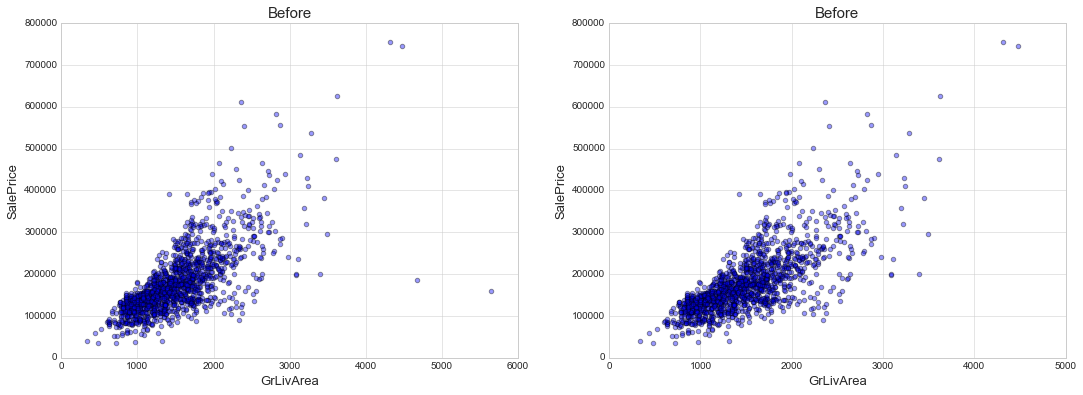

In [11]:
# display outliers
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(18,6))
axes[0].scatter(train['GrLivArea'],train['SalePrice'],alpha=0.4)
axes[0].set_ylim((0,800000))
axes[0].set_ylabel('SalePrice', fontsize=13)
axes[0].set_xlabel('GrLivArea', fontsize=13)
axes[0].set_title('Before',fontsize=15);

# drop the data
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice'] < 200000)].index)

# plot the data without outliers
axes[1].scatter(train['GrLivArea'],train['SalePrice'],alpha=0.4)
axes[1].set_ylim((0,800000))
axes[1].set_ylabel('SalePrice', fontsize=13)
axes[1].set_xlabel('GrLivArea', fontsize=13)
axes[1].set_title('Before',fontsize=15);

As shown above, there are four data points corresponding to an above grade (ground) living area square feet greater than 4000 sft with a price less than $200,000 are outliers.

In [12]:
new_section("2. Missing Values")

From the print of the data-frame info, it appears that there are a lot of incomplete records in the dataset. When dealing with missing values, several approaches can be followed:  
- delete the entiere record  
- fill the missing values with estimations

In [13]:
# explore the data completion
n_train = train.shape[0]
n_test = test.shape[0]

# store the target feature
y_train = train['SalePrice']

In [14]:
# concatenate training and test data into all_data
all_data = pd.concat((train, test),sort=False).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

print("all_data shape: {}".format(all_data.shape))

all_data shape: (2917, 79)


PoolQC          2908
MiscFeature     2812
Alley           2719
Fence           2346
FireplaceQu     1420
LotFrontage      486
GarageFinish     159
GarageYrBlt      159
GarageQual       159
GarageCond       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Exterior2nd        1
Exterior1st        1
SaleType           1
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
Electrical         1
KitchenQual        1
GarageCars         1
GarageArea         1
TotalBsmtSF        1
dtype: int64


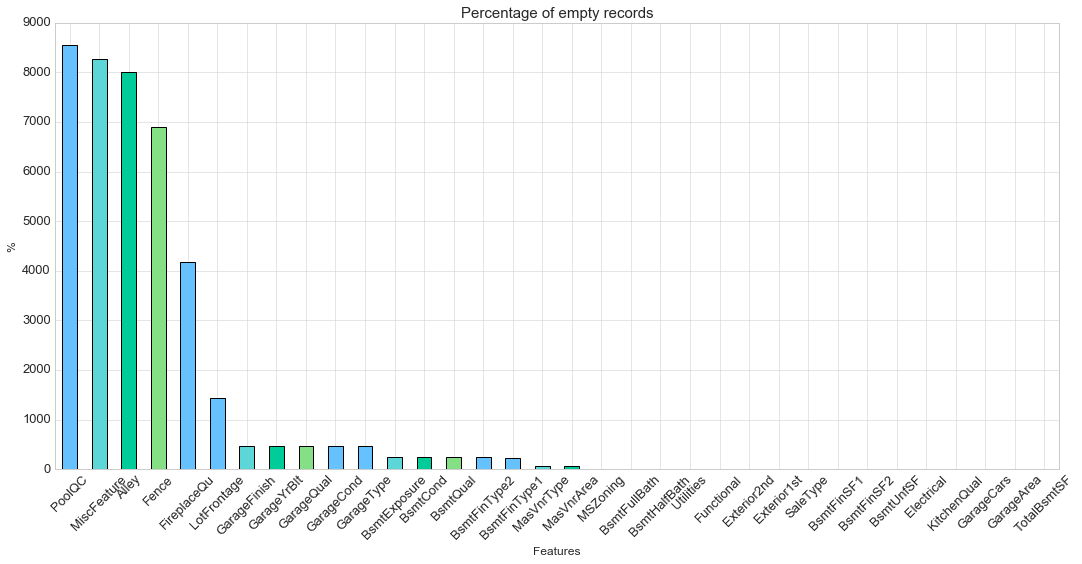

In [15]:
# Aggregate all null values
all_data_na = all_data.isnull().sum()
all_data_na = all_data_na.drop(all_data_na[all_data_na==0].index).sort_values(ascending=False)
print(all_data_na)
all_data_na = all_data_na / all_data_na.shape[0] * 100.0

# plot
fig, ax = plt.subplots(figsize=(18,8))
all_data_na.plot(kind='bar',rot=45)
plt.xlabel('Features', fontsize=12)
plt.ylabel('%', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.title('Percentage of empty records', fontsize=15)

Now that we have a good overview of the missing data, we can implement a procedure to fill the missing values.

The features with missing values are defined as:
- Lot Frontage (Continuous): Linear feet of street connected to property <font color='green'>*filled with median per neighborhood*</font>
- Alley (Nominal): Type of alley access to property <font color='red'>*filled with None*</font>
- Mas Vnr Type (Nominal): Masonry veneer type <font color='red'>*filled with None*</font>
- Mas Vnr Area (Continuous): Masonry veneer area in square feet <font color='blue'>*filled with 0*</font>
- Bsmt Qual (Ordinal): Evaluates the height of the basement <font color='red'>*filled with None*</font>
- Bsmt Cond (Ordinal): Evaluates the general condition of the basement <font color='red'>*filled with None*</font>
- Bsmt Exposure	(Ordinal): Refers to walkout or garden level walls <font color='red'>*filled with None*</font>
- BsmtFin Type 1 (Ordinal): Rating of basement finished area <font color='red'>*filled with None*</font>
- BsmtFinType 2	(Ordinal): Rating of basement finished area (if multiple types) <font color='red'>*filled with None*</font>
- Electrical (Ordinal): Electrical system <font color='orange'>*filled with first mode*</font>
- FireplaceQu (Ordinal): Fireplace quality <font color='red'>*filled with None*</font>
- Garage Type (Nominal): Garage location <font color='red'>*filled with None*</font>
- Garage Yr Blt (Discrete): Year garage was built <font color='blue'>*filled with 0*</font>
- Garage Finish (Ordinal) : Interior finish of the garage <font color='red'>*filled with None*</font>
- Garage Area (Continuous): Size of garage in square feet <font color='blue'>*filled with 0*</font>
- Garage Qual (Ordinal): Garage quality <font color='red'>*filled with None*</font>
- Garage Cond (Ordinal): Garage condition <font color='red'>*filled with None*</font>
- Pool QC (Ordinal): Pool quality <font color='red'>*filled with None*</font>
- Fence (Ordinal): Fence quality  <font color='red'>*filled with None*</font>
- Misc Feature (Nominal): Miscellaneous feature not covered in other categories <font color='red'>*filled with None*</font>
- MS Zoning (Nominal): Identifies the general zoning classification of the sale. <font color='orange'>*filled with first mode*</font>
- Bsmt Full Bath (Discrete): Basement full bathrooms <font color='blue'>*filled with 0*</font>
- Bsmt Half Bath (Discrete): Basement half bathrooms <font color='blue'>*filled with 0*</font>
- Utilities (Ordinal): Type of utilities available
- Functional (Ordinal): Home functionality (Assume typical unless deductions are warranted) <font color='orange'>*filled with first mode*</font>
- Exterior 1 (Nominal): Exterior covering on house <font color='orange'>*filled with first mode*</font>
- Exterior 2 (Nominal): Exterior covering on house (if more than one material) <font color='orange'>*filled with first mode*</font>
- Sale Type (Nominal): Type of sale <font color='orange'>*filled with first mode*</font>
- BsmtFin SF 1 (Continuous): Type 1 finished square feet <font color='blue'>*filled with 0*</font>
- BsmtFin SF 2 (Continuous): Type 2 finished square feet <font color='blue'>*filled with 0*</font>
- Bsmt Unf SF (Continuous): Unfinished square feet of basement area <font color='blue'>*filled with 0*</font>
- KitchenQual (Ordinal): Kitchen quality <font color='orange'>*filled with first mode*</font>
- Garage Cars (Discrete): Size of garage in car capacity <font color='blue'>*filled with 0*</font>
- Garage Area (Continuous): Size of garage in square feet <font color='blue'>*filled with 0*</font>
- Total Bsmt SF (Continuous): Total square feet of basement area <font color='blue'>*filled with 0*</font>

In [16]:
# for the lot frontage, we can approach the value by grouping the houses by neighborhood
# and assigning the median value tothe empy record
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# categorical features filled with None
for col in ['PoolQC','MiscFeature','Alley','Fence','FireplaceQu',
            'GarageType','GarageFinish','GarageQual','GarageCond',
            'BsmtFinType2','BsmtFinType1','BsmtCond','BsmtQual',
            'MasVnrType','BsmtExposure']:
    all_data[col] = all_data[col].fillna('None')
    
# continuous features filled with 0
for col in ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 
           'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'MasVnrArea',
           'BsmtFullBath', 'BsmtHalfBath']:
    all_data[col] = all_data[col].fillna(0)
    
# fill with mode
for col in ['Electrical','MSZoning','KitchenQual','Exterior1st','Exterior2nd','SaleType','Functional','Utilities']:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

In [17]:
new_section("3. Exploratory Data Analysis (EDA)")

Correlation Map:


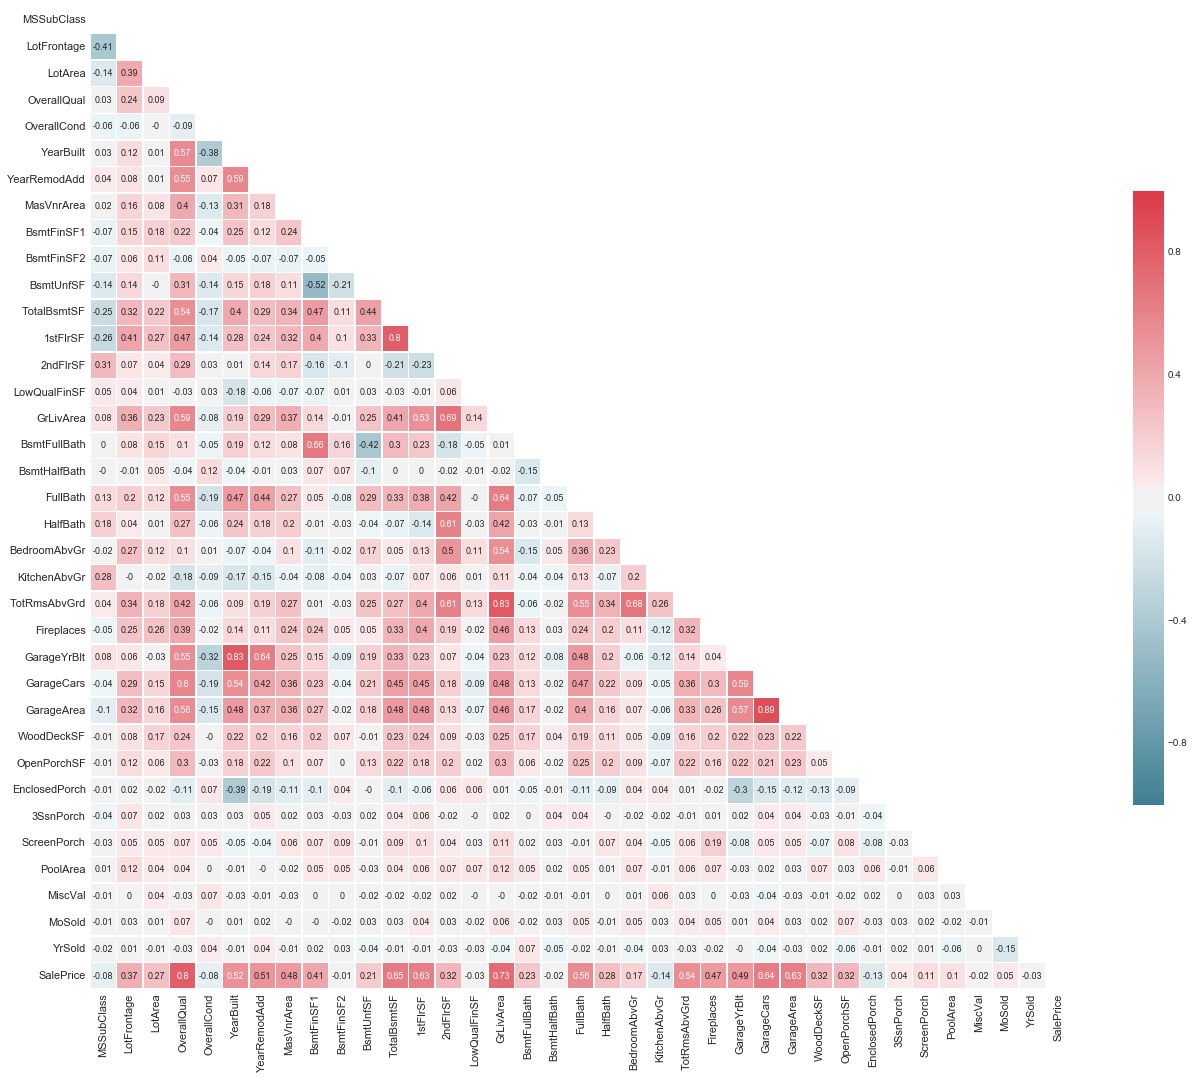

In [18]:
# Compute the correlation matrix
corr = train.corr()
corr = corr.round(decimals=2)

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(22, 22))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
print("Correlation Map:")
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0,vmin=-1.0, center=0,annot=True,
            square=True, linewidths=.5,cbar_kws={"shrink": .5},annot_kws={"size":9},fmt='.2g',)
plt.tick_params(axis='both', which='major', labelsize=11);

When inspecting the last row of the heatmap, we can identify the key contributors to the sale price. They are:  
- OverallQual
- GrLivArea
- TotalBsmtSF
- GarageCars
- GarageArea
- 1stFlrSF
- FullBath
- TotRmsAbvGrd
- YearBuilt
- YearRemodAdd
- GarageYrBlt
- MasVnrArea
- Fireplaces
- BsmtFinSF1
- LotFrontage
- 2ndFlrSF
- WoodDeckSF
- OpenPorchSF
- HalfBath
- LotArea
- BsmtFullBath
- BsmtUnfSF  
  
The corresponding correlation vary from 0.80 to 0.21. Note that we sorted the key contributors using the absolute value of the correlation and it appears that all the key contributors are positively correlated. We use these key contributors to create polynomial relationships.

In [19]:
# 2nd Order
all_data['OverallQual-2'] = all_data['OverallQual'] ** 2
all_data['GrLivArea-2'] = all_data['GrLivArea'] ** 2
all_data['TotalBsmtSF-2'] = all_data['TotalBsmtSF'] ** 2
all_data['GarageCars-2'] = all_data['GarageCars'] ** 2
all_data['GarageArea-2'] = all_data['GarageArea'] ** 2
all_data['1stFlrSF-2'] = all_data['1stFlrSF'] ** 2
all_data['FullBath-2'] = all_data['FullBath'] ** 2
all_data['TotRmsAbvGrd-2'] = all_data['TotRmsAbvGrd'] ** 2
all_data['YearBuilt-2'] = all_data['YearBuilt'] ** 2
all_data['YearRemodAdd-2'] = all_data['YearRemodAdd'] ** 2
all_data['GarageYrBlt-2'] = all_data['GarageYrBlt'] ** 2
all_data['MasVnrArea-2'] = all_data['MasVnrArea'] ** 2
all_data['Fireplaces-2'] = all_data['Fireplaces'] ** 2
all_data['BsmtFinSF1-2'] = all_data['BsmtFinSF1'] ** 2
all_data['LotFrontage-2'] = all_data['LotFrontage'] ** 2
all_data['2ndFlrSF-2'] = all_data['2ndFlrSF'] ** 2
all_data['WoodDeckSF-2'] = all_data['WoodDeckSF'] ** 2
all_data['OpenPorchSF-2'] = all_data['OpenPorchSF'] ** 2
all_data['HalfBath-2'] = all_data['HalfBath'] ** 2
all_data['LotArea-2'] = all_data['LotArea'] ** 2
all_data['BsmtFullBath-2'] = all_data['BsmtFullBath'] ** 2
all_data['BsmtUnfSF-2'] = all_data['BsmtUnfSF'] ** 2

# 3rd Order
all_data['OverallQual-3'] = all_data['OverallQual'] ** 3
all_data['GrLivArea-3'] = all_data['GrLivArea'] ** 3
all_data['TotalBsmtSF-3'] = all_data['TotalBsmtSF'] ** 3
all_data['GarageCars-3'] = all_data['GarageCars'] ** 3
all_data['GarageArea-3'] = all_data['GarageArea'] ** 3
all_data['1stFlrSF-3'] = all_data['1stFlrSF'] ** 3
all_data['FullBath-3'] = all_data['FullBath'] ** 3
all_data['TotRmsAbvGrd-3'] = all_data['TotRmsAbvGrd'] ** 3
all_data['YearBuilt-3'] = all_data['YearBuilt'] ** 3
all_data['YearRemodAdd-3'] = all_data['YearRemodAdd'] ** 3
all_data['GarageYrBlt-3'] = all_data['GarageYrBlt'] ** 3
all_data['MasVnrArea-3'] = all_data['MasVnrArea'] ** 3
all_data['Fireplaces-3'] = all_data['Fireplaces'] ** 3
all_data['BsmtFinSF1-3'] = all_data['BsmtFinSF1'] ** 3
all_data['LotFrontage-3'] = all_data['LotFrontage'] ** 3
all_data['2ndFlrSF-3'] = all_data['2ndFlrSF'] ** 3
all_data['WoodDeckSF-3'] = all_data['WoodDeckSF'] ** 3
all_data['OpenPorchSF-3'] = all_data['OpenPorchSF'] ** 3
all_data['HalfBath-3'] = all_data['HalfBath'] ** 3
all_data['LotArea-3'] = all_data['LotArea'] ** 3
all_data['BsmtFullBath-3'] = all_data['BsmtFullBath'] ** 3
all_data['BsmtUnfSF-3'] = all_data['BsmtUnfSF'] ** 3

# Sqrt
all_data['OverallQual-sqrt'] = np.sqrt(all_data['OverallQual'])
all_data['GrLivArea-sqrt'] = np.sqrt(all_data['GrLivArea'])
all_data['TotalBsmtSF-sqrt'] = np.sqrt(all_data['TotalBsmtSF'])
all_data['GarageCars-sqrt'] = np.sqrt(all_data['GarageCars'])
all_data['GarageArea-sqrt'] = np.sqrt(all_data['GarageArea'])
all_data['1stFlrSF-sqrt'] = np.sqrt(all_data['1stFlrSF'])
all_data['FullBath-sqrt'] = np.sqrt(all_data['FullBath'])
all_data['TotRmsAbvGrd-sqrt'] = np.sqrt(all_data['TotRmsAbvGrd'])
all_data['YearBuilt-sqrt'] = np.sqrt(all_data['YearBuilt'])
all_data['YearRemodAdd-sqrt'] = np.sqrt(all_data['YearRemodAdd'])
all_data['GarageYrBlt-sqrt'] = np.sqrt(all_data['GarageYrBlt'])
all_data['MasVnrArea-sqrt'] = np.sqrt(all_data['MasVnrArea'])
all_data['Fireplaces-sqrt'] = np.sqrt(all_data['Fireplaces'])
all_data['BsmtFinSF1-sqrt'] = np.sqrt(all_data['BsmtFinSF1'])
all_data['LotFrontage-sqrt'] = np.sqrt(all_data['LotFrontage'])
all_data['2ndFlrSF-sqrt'] = np.sqrt(all_data['2ndFlrSF'])
all_data['WoodDeckSF-sqrt'] = np.sqrt(all_data['WoodDeckSF'])
all_data['OpenPorchSF-sqrt'] = np.sqrt(all_data['OpenPorchSF'])
all_data['HalfBath-sqrt'] = np.sqrt(all_data['HalfBath'])
all_data['LotArea-sqrt'] = np.sqrt(all_data['LotArea'])
all_data['BsmtFullBath-sqrt'] = np.sqrt(all_data['BsmtFullBath'])
all_data['BsmtUnfSF-sqrt'] = np.sqrt(all_data['BsmtUnfSF'])

### Interior  
The following variables are assigned to the "Interior" group.
- Bsmt Qual (Ordinal): Evaluates the height of the basement
- Bsmt Cond (Ordinal): Evaluates the general condition of the basement
- Bsmt Exposure	(Ordinal): Refers to walkout or garden level walls
- BsmtFin Type 1	(Ordinal): Rating of basement finished area
- BsmtFin SF 1 (Continuous): Type 1 finished square feet
- BsmtFinType 2	(Ordinal): Rating of basement finished area (if multiple types)
- BsmtFin SF 2 (Continuous): Type 2 finished square feet
- Bsmt Unf SF (Continuous): Unfinished square feet of basement area
- Total Bsmt SF (Continuous): Total square feet of basement area
- 1st Flr SF (Continuous): First Floor square feet
- 2nd Flr SF (Continuous)	: Second floor square feet
- Low Qual Fin SF (Continuous): Low quality finished square feet (all floors)
- Bsmt Full Bath (Discrete): Basement full bathrooms
- Bsmt Half Bath (Discrete): Basement half bathrooms
- Full Bath (Discrete): Full bathrooms above grade
- Half Bath (Discrete): Half baths above grade
- Bedroom (Discrete): Bedrooms above grade (does NOT include basement bedrooms)
- Kitchen (Discrete): Kitchens above grade
- KitchenQual (Ordinal): Kitchen quality
- TotRmsAbvGrd	(Discrete): Total rooms above grade (does not include bathrooms)
- Fireplaces (Discrete): Number of fireplaces
- FireplaceQu (Ordinal): Fireplace quality
- Gr Liv Area (Continuous): Above grade (ground) living area square feet

**BsmtQual**

In [20]:
sns.set()
sns.set_style("whitegrid")
sns.set_palette(palette = mycols, n_colors = 4)

In [21]:
train['SalePrice'].max()

755000

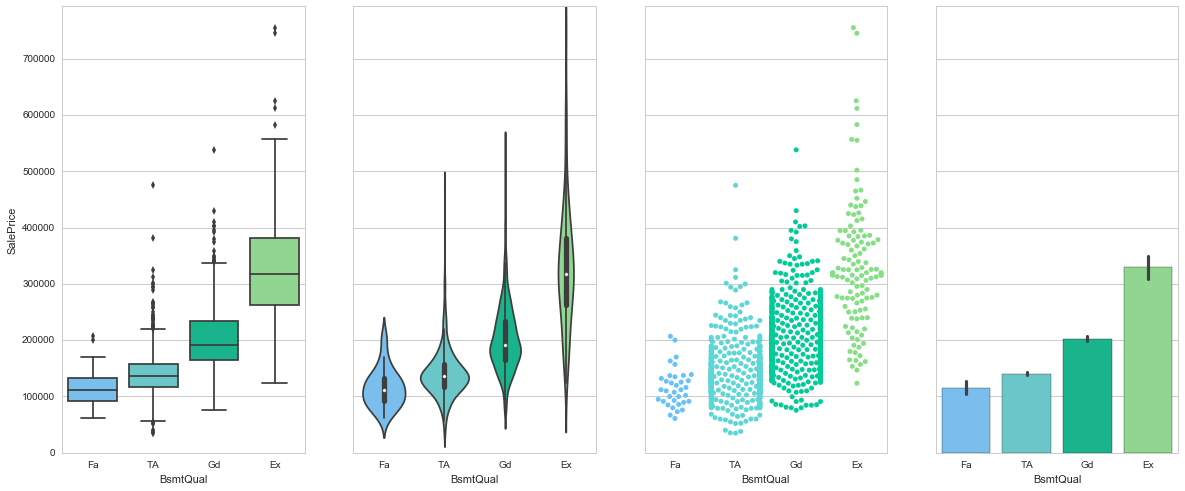

In [22]:
feature = 'BsmtQual'
order = ['Fa', 'TA', 'Gd', 'Ex']
fig, axarr = plt.subplots(1,4,figsize =(20, 8),sharey=True)

# plot
#plt.subplot(1,4,1)
sns.boxplot(x=feature, y='SalePrice',data=train,
            order=order,ax=axarr[0])

# plot
#plt.subplot(1,4,2)
plot = sns.violinplot(x=feature, y='SalePrice',data=train, showmeans=False,
               showmedians=False,showextrema=False,order=order,ax=axarr[1])
axarr[1].set_ylabel("")

# plot
#plt.subplot(1,4,3)
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,order=order,ax=axarr[2])
axarr[2].set_ylabel("")

# purpose
#plt.subplot(1,4,4)
sns.barplot(x=feature, y='SalePrice',data=train,
            order=order,ax=axarr[3])
axarr[3].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

**COMMENT**: We found an order of the classes for BsmtQual that produces an increase in the sale price. We will use this to create a ordinal feature. Most of the data is contained within the "TA" and "Gd" groups.

In [23]:
all_data['BsmtQual'] = all_data['BsmtQual'].map({"None":0, "Fa":1, "TA":2, "Gd":3, "Ex":4})
all_data['BsmtQual'].unique()

array([3, 2, 4, 0, 1])

**BsmtCond**

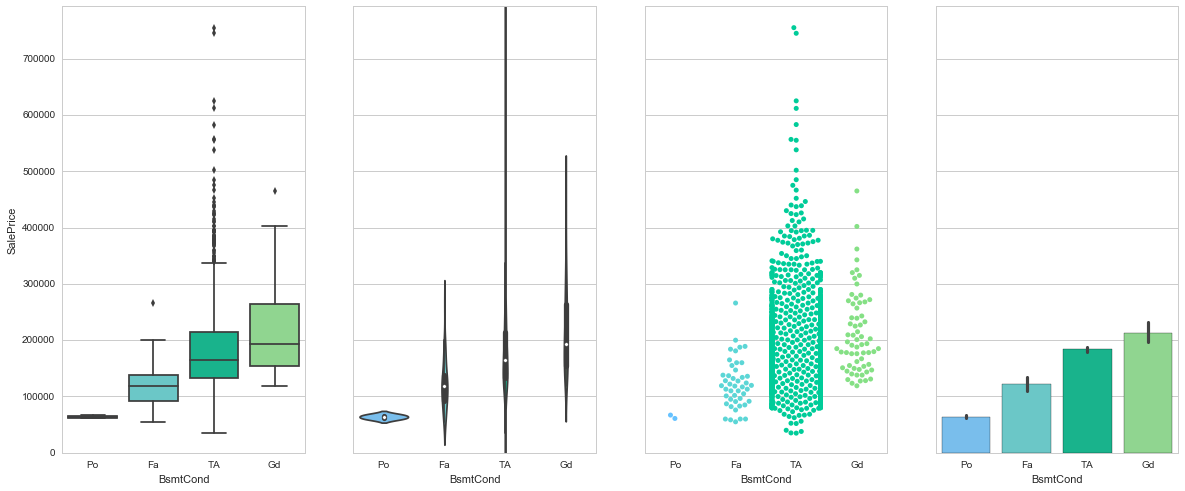

In [24]:
feature = 'BsmtCond'
order = ['Po', 'Fa', 'TA', 'Gd']
fig, axarr = plt.subplots(1,4,figsize =(20, 8),sharey=True)

# plot
#plt.subplot(1,4,1)
sns.boxplot(x=feature, y='SalePrice',data=train,
            order=order,ax=axarr[0])

# plot
#plt.subplot(1,4,2)
plot = sns.violinplot(x=feature, y='SalePrice',data=train, showmeans=False,
               showmedians=False,showextrema=False,order=order,ax=axarr[1])
axarr[1].set_ylabel("")

# plot
#plt.subplot(1,4,3)
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,order=order,ax=axarr[2])
axarr[2].set_ylabel("")

# purpose
#plt.subplot(1,4,4)
sns.barplot(x=feature, y='SalePrice',data=train,
            order=order,ax=axarr[3])
axarr[3].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

**COMMENT**: We found an order of the classes for BsmtCond that produces an increase in the sale price. We will use this to create a ordinal feature. Most of the data is contained within the "TA" group.

In [25]:
all_data['BsmtCond'] = all_data['BsmtCond'].map({"None":0, "Po":1, "Fa":2, "TA":3, "Gd":4})
all_data['BsmtCond'].unique()

array([3, 4, 0, 2, 1])

**BsmtExposure**

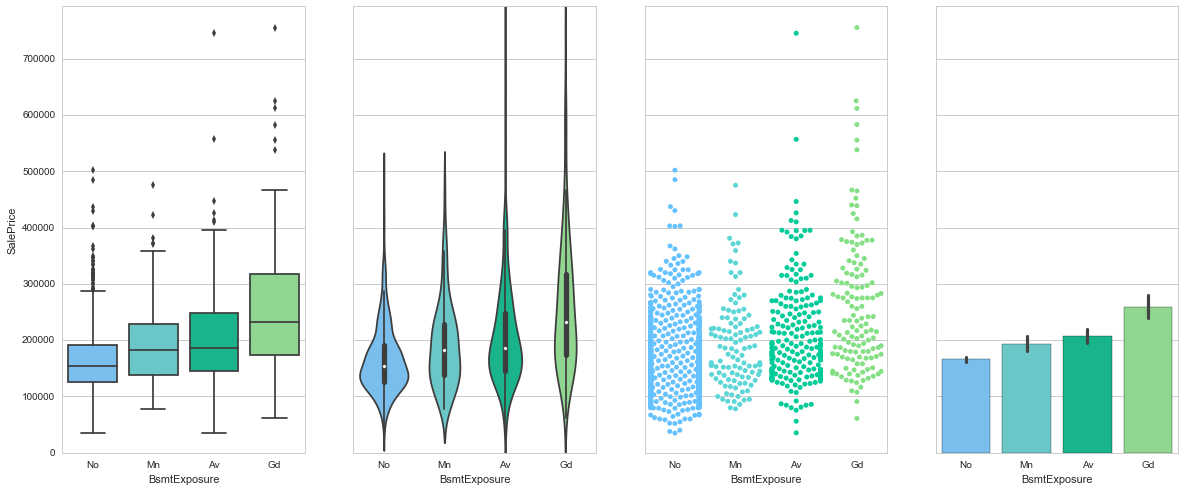

In [26]:
feature = 'BsmtExposure'
order = ['No', 'Mn', 'Av', 'Gd']
fig, axarr = plt.subplots(1,4,figsize =(20, 8),sharey=True)

# plot
#plt.subplot(1,4,1)
sns.boxplot(x=feature, y='SalePrice',data=train,order=order,ax=axarr[0])

# plot
#plt.subplot(1,4,2)
plot = sns.violinplot(x=feature, y='SalePrice',data=train, showmeans=False,
               showmedians=False,showextrema=False,order=order,ax=axarr[1])
axarr[1].set_ylabel("")

# plot
#plt.subplot(1,4,3)
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,order=order,ax=axarr[2])
axarr[2].set_ylabel("")

# purpose
#plt.subplot(1,4,4)
sns.barplot(x=feature, y='SalePrice',data=train,order=order,ax=axarr[3])
axarr[3].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

**COMMENT**: We found an order of the classes for BsmtExposure that produces an increase in the sale price. We will use this to create a ordinal feature. Most of the data is contained within the "No" group.

In [27]:
all_data['BsmtExposure'] = all_data['BsmtExposure'].map({"None":0, "No":1, "Mn":2, "Av":3, "Gd":4})
all_data['BsmtExposure'].unique()

array([1, 4, 2, 3, 0])

**BsmtFinType1**

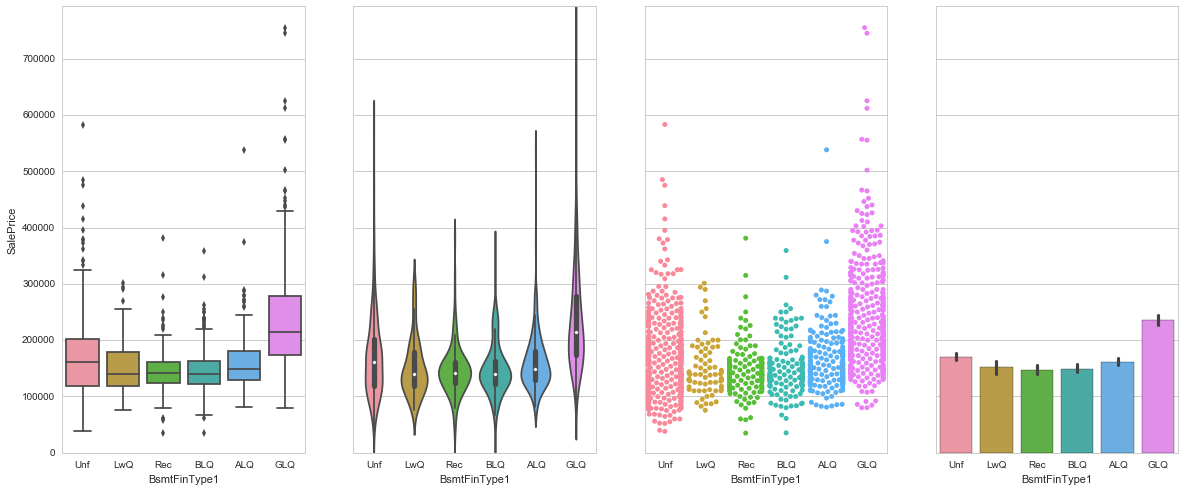

In [28]:
feature = 'BsmtFinType1'
order = ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"]
fig, axarr = plt.subplots(1,4,figsize =(20, 8),sharey=True)

# plot
#plt.subplot(1,4,1)
sns.boxplot(x=feature, y='SalePrice',data=train,order=order,ax=axarr[0])

# plot
#plt.subplot(1,4,2)
plot = sns.violinplot(x=feature, y='SalePrice',data=train, showmeans=False,
               showmedians=False,showextrema=False,order=order,ax=axarr[1])
axarr[1].set_ylabel("")

# plot
#plt.subplot(1,4,3)
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,order=order,ax=axarr[2])
axarr[2].set_ylabel("")

# purpose
#plt.subplot(1,4,4)
sns.barplot(x=feature, y='SalePrice',data=train,order=order,ax=axarr[3])
axarr[3].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

**COMMENT**: From the above data, it seems that a house with an unfinished basement has more value than any other type of basement except for the ones with a good quality. Since the order of the categories is not obvious, we will create dummy features.

In [29]:
all_data = pd.get_dummies(all_data,columns=['BsmtFinType1'],prefix=['BsmtFinType1'])
all_data.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave  None      Reg   
1          20       RL         80.0     9600   Pave  None      Reg   
2          60       RL         68.0    11250   Pave  None      IR1   
3          70       RL         60.0     9550   Pave  None      IR1   
4          60       RL         84.0    14260   Pave  None      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation  BsmtQual  BsmtCond  \
0       196.0        Gd        TA      PConc         3         3   
1         0.0        TA        TA     CBlock         3         3   
2       162.0        Gd        TA      PConc         3         3   
3         0.0        TA        TA     BrkTil         2         4   
4       350.0        Gd        TA      PConc         3         3   

   BsmtExposure  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0             1       706.0          Unf         0.0      150.0        856.0   
1             4       978.0          Unf         0.0      284.0       1262.0   
2             2       486.0          Unf         0.0      434.0        920.0   
3             1       216.0          Unf         0.0      540.0        756.0   
4             3       655.0          Unf         0.0      490.0       1145.0   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710           1.0           0.0         2         1             3   
1       1262           0.0           1.0         2         0             3   
2       1786           1.0           0.0         2         1             3   
3       1717           1.0           0.0         1         0             3   
4       2198           1.0           0.0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0        None   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd             7        Typ           1          Gd   
4             1          Gd             9  

**BsmtFinSF1**

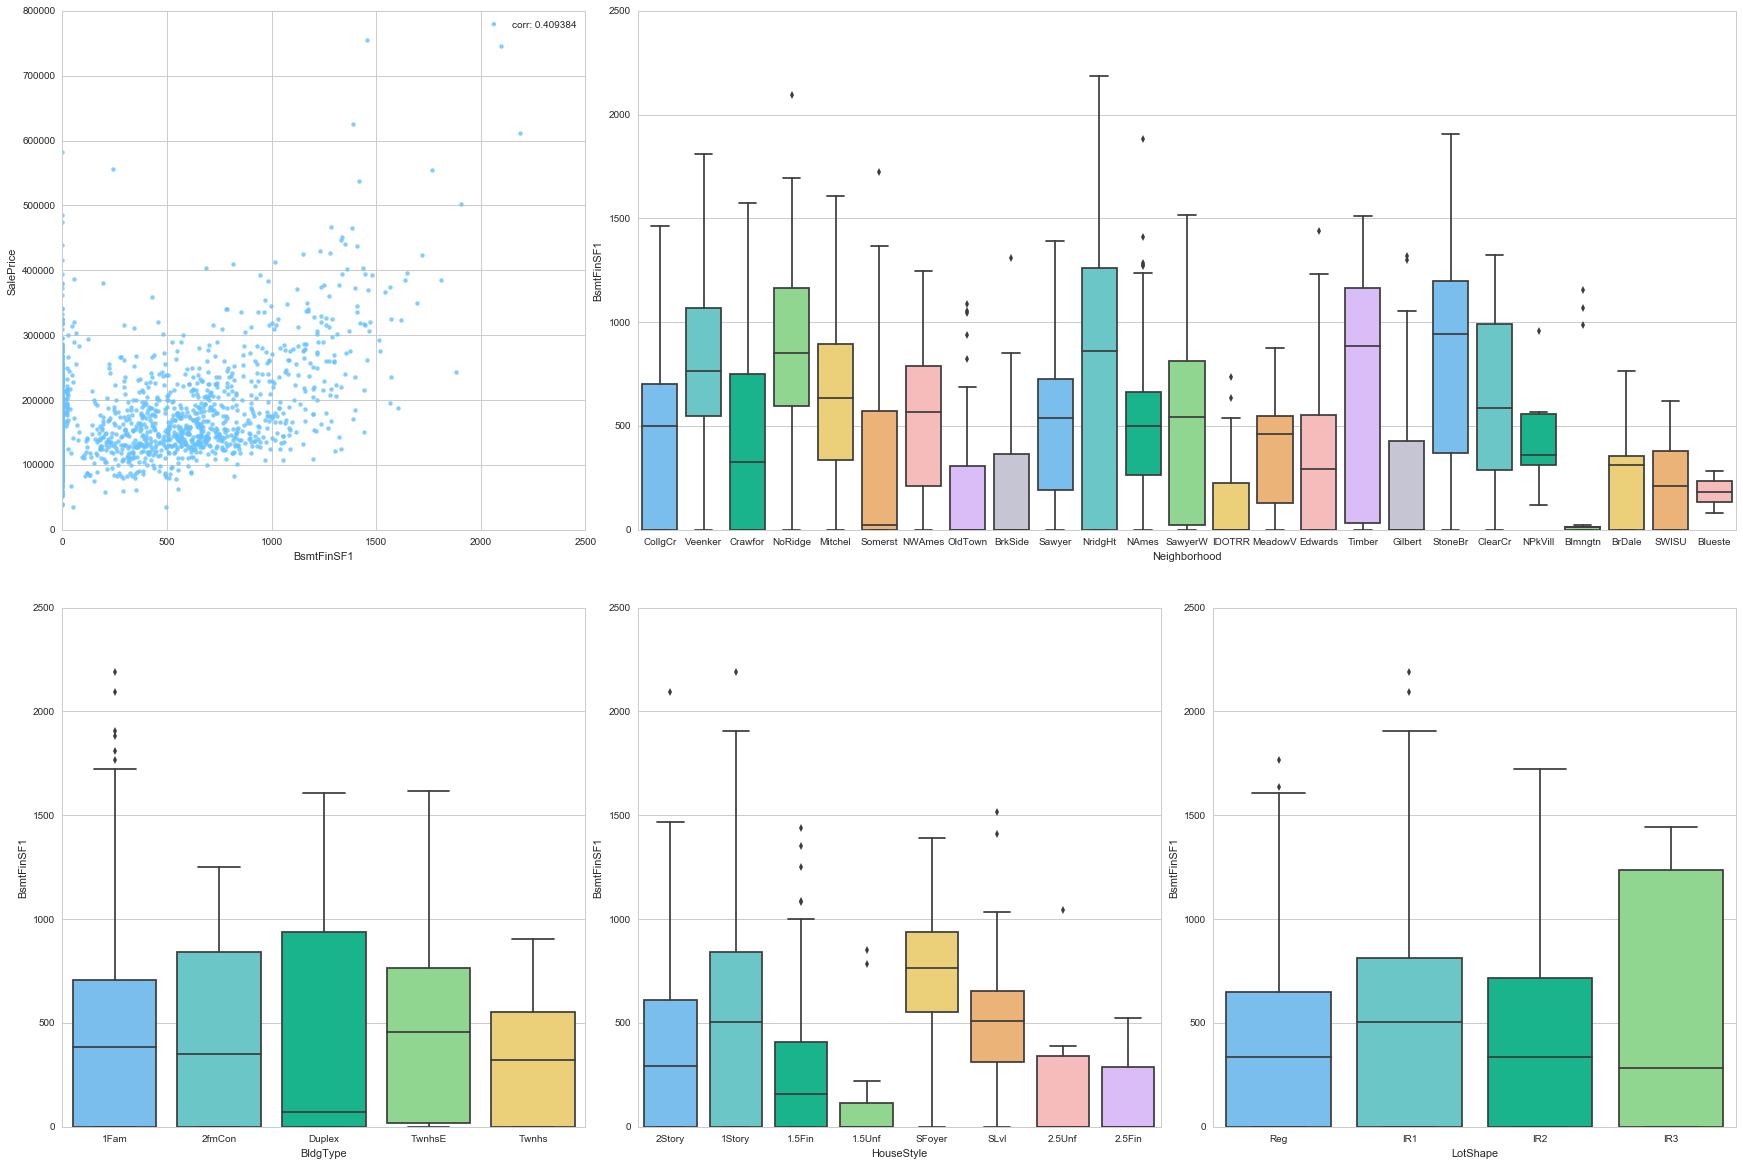

In [30]:
feature = 'BsmtFinSF1'
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 20))

# plot
plt.subplot(grid[0, 0])
g = sns.regplot(x=train[feature], y=train['SalePrice'], fit_reg=False,
                label = "corr: %2f"%(pearsonr(train[feature], train['SalePrice'])[0]))
g = g.legend(loc="best")
g.axes.set_xlim(0,)
g.axes.set_ylim(0,)

# plot
plt.subplot(grid[0, 1:])
sns.boxplot(x='Neighborhood', y=feature, data=train, palette = mycols)

# plot
plt.subplot(grid[1, 0]);
sns.boxplot(x='BldgType', y=feature, data=train, palette = mycols)

# plot
plt.subplot(grid[1, 1]);
sns.boxplot(x='HouseStyle', y=feature, data=train, palette = mycols)

# plot
plt.subplot(grid[1, 2]);
sns.boxplot(x='LotShape', y=feature, data=train, palette = mycols);

**COMMENT**:
- From the first plot, we observe a positive correlation between the sale prince and the Type 1 finished sft.
- From the box plot, we notice that teh distribution of the sale price as function of the Type 1 finished sft is strongly linked to the neighborhood.
- The last three boxplots also show a strong dependance to the architecture (Building type, house style, and lot shape).
- We now gather the data into bins.

In [31]:
all_data['BsmtFinSF1'] = pd.qcut(all_data['BsmtFinSF1'],[0,0.40,0.50,0.75,1],range(1,5))
all_data['BsmtFinSF1'].unique()

[3, 4, 2, 1]
Categories (4, int64): [1 < 2 < 3 < 4]

In [32]:
all_data = pd.get_dummies(all_data,columns=['BsmtFinSF1'],prefix=['BsmtFinSF1'])
all_data.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave  None      Reg   
1          20       RL         80.0     9600   Pave  None      Reg   
2          60       RL         68.0    11250   Pave  None      IR1   
3          70       RL         60.0     9550   Pave  None      IR1   
4          60       RL         84.0    14260   Pave  None      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation  BsmtQual  BsmtCond  \
0       196.0        Gd        TA      PConc         3         3   
1         0.0        TA        TA     CBlock         3         3   
2       162.0        Gd        TA      PConc         3         3   
3         0.0        TA        TA     BrkTil         2         4   
4       350.0        Gd        TA      PConc         3         3   

   BsmtExposure BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating  \
0             1          Unf         0.0      150.0        856.0    GasA   
1             4          Unf         0.0      284.0       1262.0    GasA   
2             2          Unf         0.0      434.0        920.0    GasA   
3             1          Unf         0.0      540.0        756.0    GasA   
4             3          Unf         0.0      490.0       1145.0    GasA   

  HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0        Ex          Y      SBrkr       856       854             0   
1        Ex          Y      SBrkr      1262         0             0   
2        Ex          Y      SBrkr       920       866             0   
3        Gd          Y      SBrkr       961       756             0   
4        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710           1.0           0.0         2         1             3   
1       1262           0.0           1.0         2         0             3   
2       1786           1.0           0.0         2         1             3   
3       1717           1.0           0.0         1         0             3   
4       2198           1.0           0.0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0        None   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd             7        Typ           1          Gd   
4             1          Gd             9        Typ           1          TA   

  GarageType  GarageYrBlt GarageFi

**BsmtFinType2**

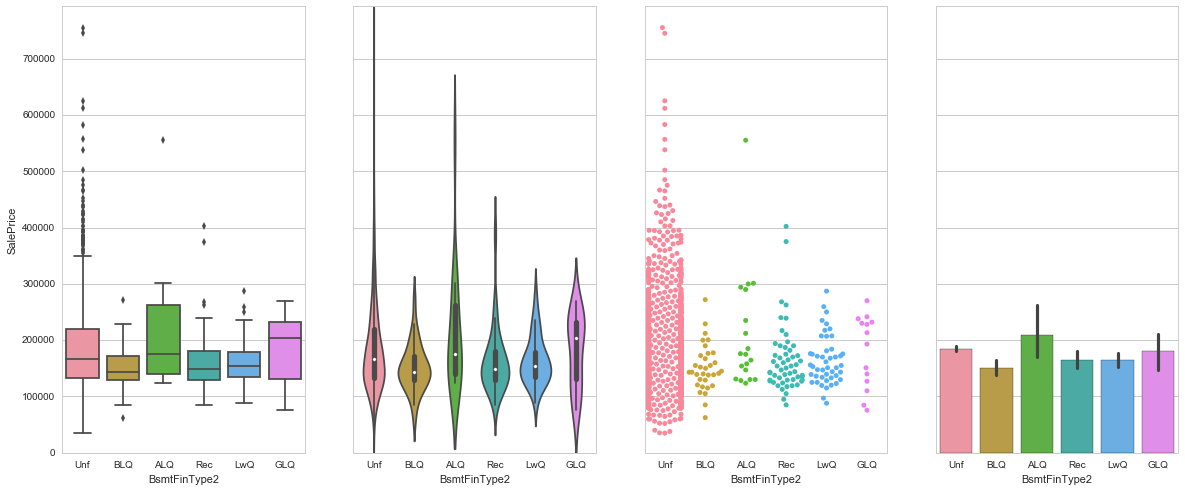

In [33]:
feature = 'BsmtFinType2'
order = ['Unf', 'BLQ', 'ALQ', 'Rec', 'LwQ', 'GLQ']
fig, axarr = plt.subplots(1,4,figsize =(20, 8),sharey=True)

# plot
#plt.subplot(1,4,1)
sns.boxplot(x=feature, y='SalePrice',data=train,order=order,ax=axarr[0])

# plot
#plt.subplot(1,4,2)
plot = sns.violinplot(x=feature, y='SalePrice',data=train, showmeans=False,
               showmedians=False,showextrema=False,order=order,ax=axarr[1])
axarr[1].set_ylabel("")

# plot
#plt.subplot(1,4,3)
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,order=order,ax=axarr[2])
axarr[2].set_ylabel("")

# purpose
#plt.subplot(1,4,4)
sns.barplot(x=feature, y='SalePrice',data=train,order=order,ax=axarr[3])
axarr[3].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

**COMMENT**:
- Most of the data is contained in the "Unifinished" group.
- The distribution of the data does not indicate that the sale price increaases with the quality of the finish for the second bassement.  
in conclusion, we simply create dummy variables to store the data.

In [34]:
all_data = pd.get_dummies(all_data,columns=['BsmtFinType2'],prefix=['BsmtFinType2'])
all_data.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave  None      Reg   
1          20       RL         80.0     9600   Pave  None      Reg   
2          60       RL         68.0    11250   Pave  None      IR1   
3          70       RL         60.0     9550   Pave  None      IR1   
4          60       RL         84.0    14260   Pave  None      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation  BsmtQual  BsmtCond  \
0       196.0        Gd        TA      PConc         3         3   
1         0.0        TA        TA     CBlock         3         3   
2       162.0        Gd        TA      PConc         3         3   
3         0.0        TA        TA     BrkTil         2         4   
4       350.0        Gd        TA      PConc         3         3   

   BsmtExposure  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating HeatingQC  \
0             1         0.0      150.0        856.0    GasA        Ex   
1             4         0.0      284.0       1262.0    GasA        Ex   
2             2         0.0      434.0        920.0    GasA        Ex   
3             1         0.0      540.0        756.0    GasA        Gd   
4             3         0.0      490.0       1145.0    GasA        Ex   

  CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  \
0          Y      SBrkr       856       854             0       1710   
1          Y      SBrkr      1262         0             0       1262   
2          Y      SBrkr       920       866             0       1786   
3          Y      SBrkr       961       756             0       1717   
4          Y      SBrkr      1145      1053             0       2198   

   BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
0           1.0           0.0         2         1             3             1   
1           0.0           1.0         2         0             3             1   
2           1.0           0.0         2         1             3             1   
3           1.0           0.0         1         0             3             1   
4           1.0           0.0         2         1             4             1   

  KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  \
0          Gd             8        Typ           0        None     Attchd   
1          TA             6        Typ           1          TA     Attchd   
2          Gd             6        Typ           1          TA     Attchd   
3          Gd             7        Typ           1          Gd     Detchd   
4          Gd             9        Typ           1          TA     Attchd   

   GarageYrBlt GarageFinish  GarageCars  Garag

**BsmtFinSF2**

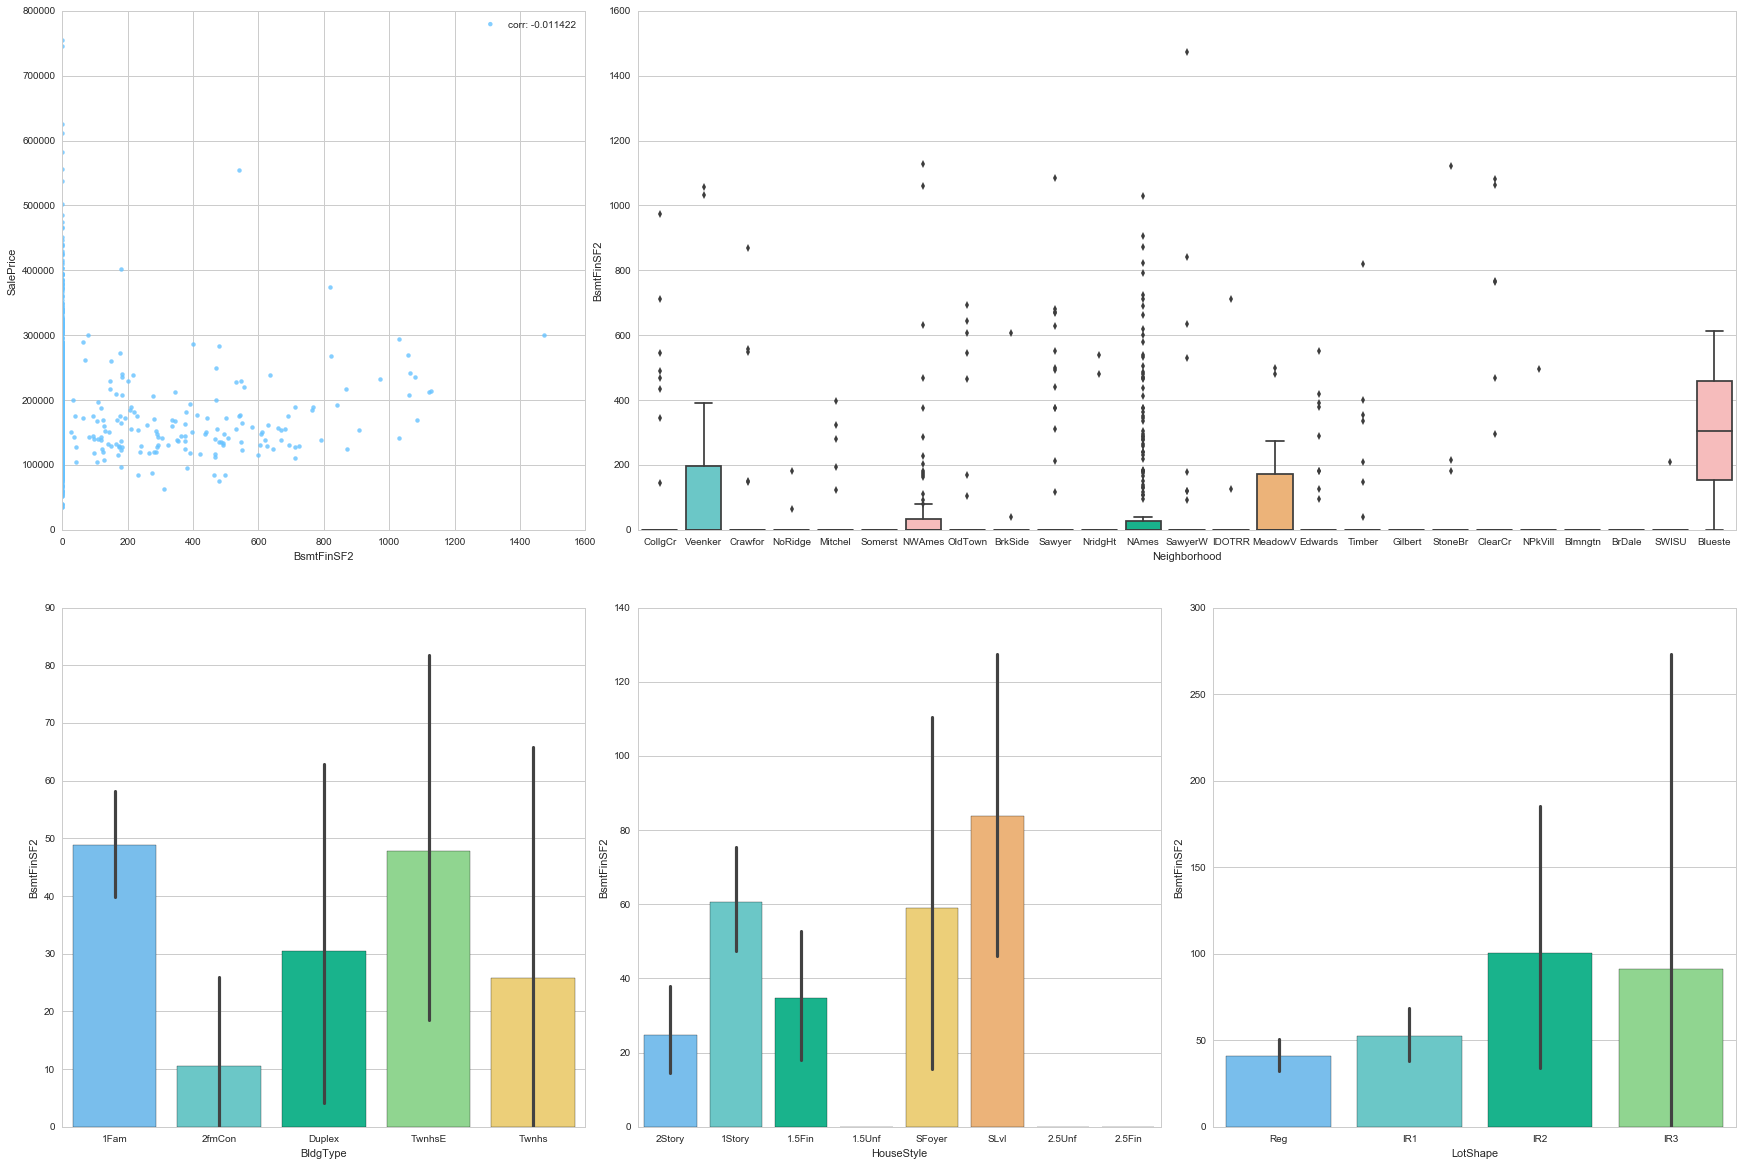

In [35]:
feature = 'BsmtFinSF2'
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 20))

# plot
plt.subplot(grid[0, 0])
g = sns.regplot(x=train[feature], y=train['SalePrice'], fit_reg=False,
                label = "corr: %2f"%(pearsonr(train[feature], train['SalePrice'])[0]))
g = g.legend(loc="best")
g.axes.set_xlim(0,)
g.axes.set_ylim(0,)

# plot
plt.subplot(grid[0, 1:])
sns.boxplot(x='Neighborhood', y=feature, data=train, palette = mycols)

# plot
plt.subplot(grid[1, 0]);
sns.barplot(x='BldgType', y=feature, data=train, palette = mycols)

# plot
plt.subplot(grid[1, 1]);
sns.barplot(x='HouseStyle', y=feature, data=train, palette = mycols)

# plot
plt.subplot(grid[1, 2]);
sns.barplot(x='LotShape', y=feature, data=train, palette = mycols);

**COMMENT**:
- A large portion of the data is associated to the value 0.
- There is no clear correlation between the sale price and this feature.

In [36]:
# create a flag feature that corresponds to 0 values
all_data['BsmtFinSF2_flag'] = all_data['BsmtFinSF2'].map(lambda x: 0 if x==0 else 1)
all_data.drop('BsmtFinSF2', axis=1, inplace=True)

**BsmtUnfSF**

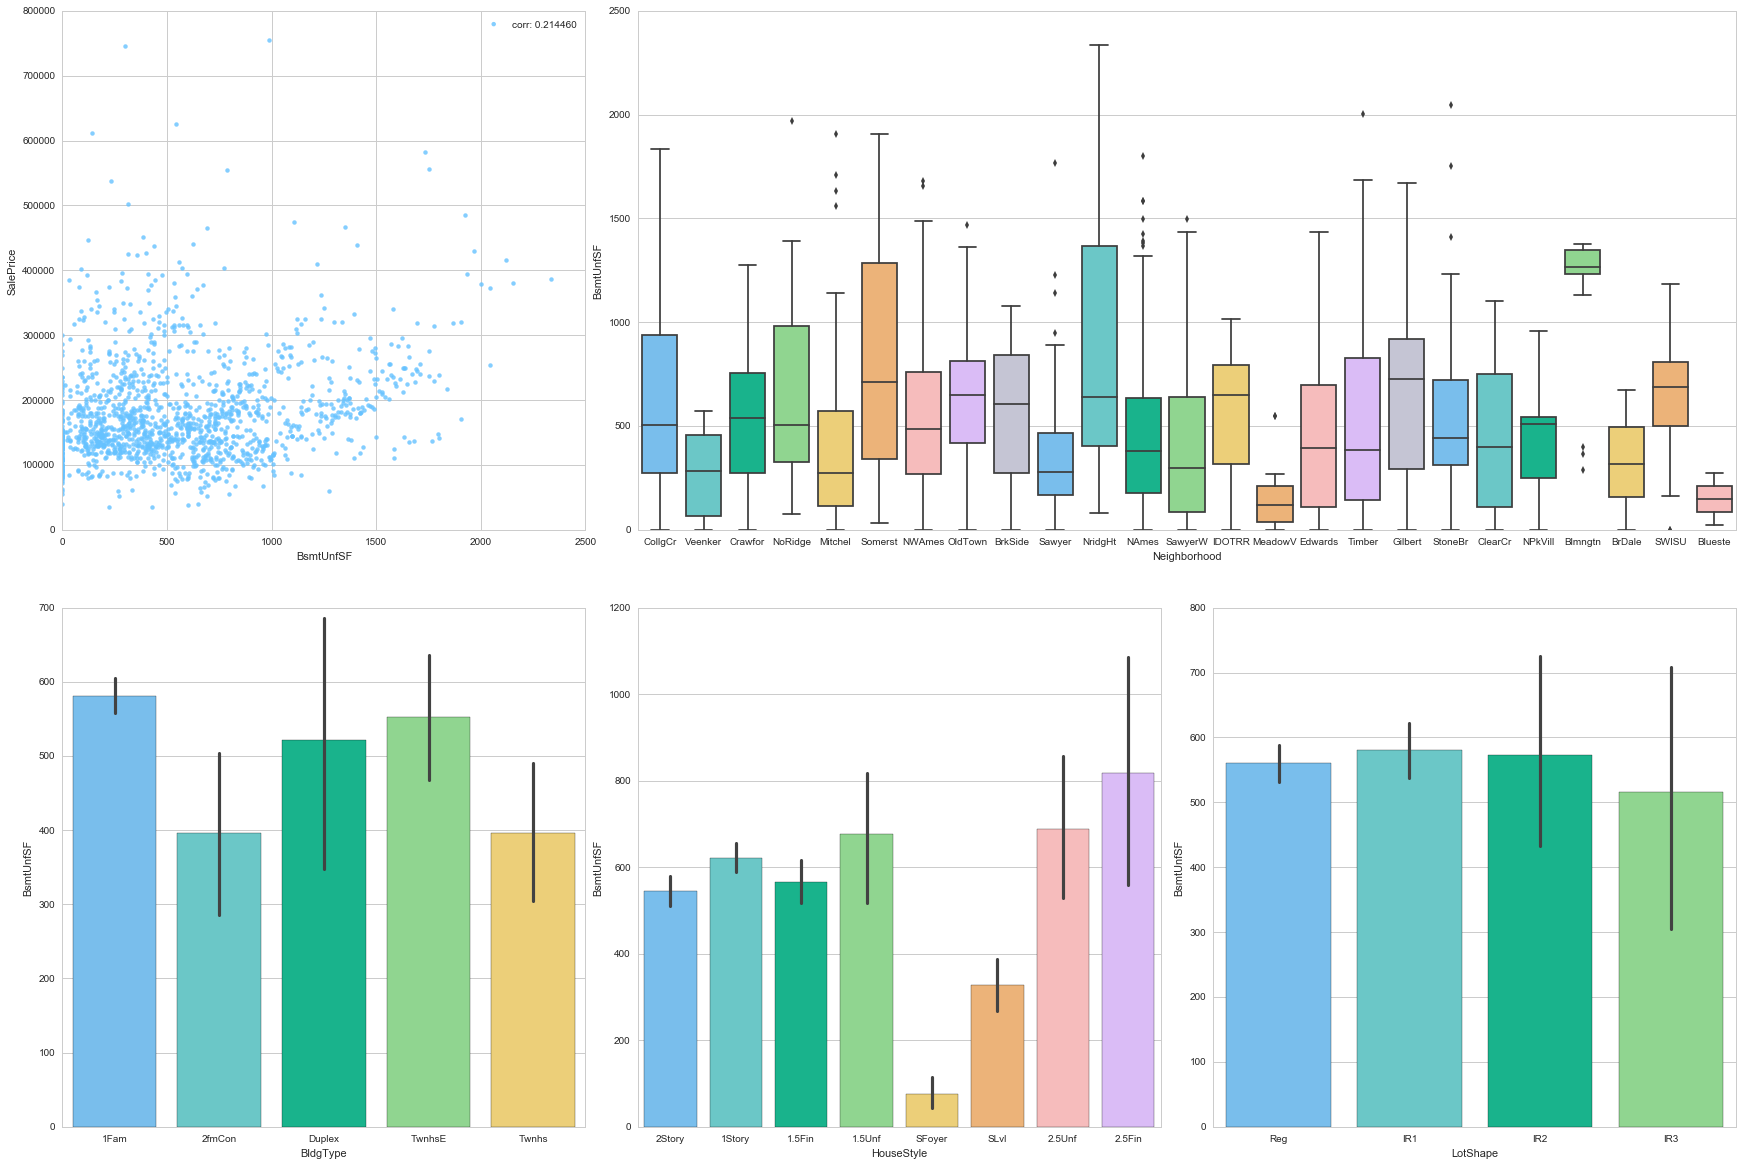

In [37]:
feature = 'BsmtUnfSF'
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 20))

# plot
plt.subplot(grid[0, 0])
g = sns.regplot(x=train[feature], y=train['SalePrice'], fit_reg=False,
                label = "corr: %2f"%(pearsonr(train[feature], train['SalePrice'])[0]))
g = g.legend(loc="best")
g.axes.set_xlim(0,)
g.axes.set_ylim(0,)

# plot
plt.subplot(grid[0, 1:])
sns.boxplot(x='Neighborhood', y=feature, data=train, palette = mycols)

# plot
plt.subplot(grid[1, 0]);
sns.barplot(x='BldgType', y=feature, data=train, palette = mycols)

# plot
plt.subplot(grid[1, 1]);
sns.barplot(x='HouseStyle', y=feature, data=train, palette = mycols)

# plot
plt.subplot(grid[1, 2]);
sns.barplot(x='LotShape', y=feature, data=train, palette = mycols);

**COMMENT**
- This feature is positively correlated to the sale price. A fraction of the data is assigned a 0 value.
- The area of unfinished basement varies greatly from one neighborhood to the other.
- The same conclusion can be made when looking at the type of house.  
  
As previously performed, we will now bin the data.

In [38]:
all_data['BsmtUnfSF'] = pd.qcut(all_data['BsmtUnfSF'],[0,0.25,0.50,0.75,1],range(1,5))
all_data['BsmtUnfSF'].unique()

[1, 2, 3, 4]
Categories (4, int64): [1 < 2 < 3 < 4]

In [39]:
all_data = pd.get_dummies(all_data,columns=['BsmtUnfSF'],prefix=['BsmtUnfSF'])
all_data.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave  None      Reg   
1          20       RL         80.0     9600   Pave  None      Reg   
2          60       RL         68.0    11250   Pave  None      IR1   
3          70       RL         60.0     9550   Pave  None      IR1   
4          60       RL         84.0    14260   Pave  None      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation  BsmtQual  BsmtCond  \
0       196.0        Gd        TA      PConc         3         3   
1         0.0        TA        TA     CBlock         3         3   
2       162.0        Gd        TA      PConc         3         3   
3         0.0        TA        TA     BrkTil         2         4   
4       350.0        Gd        TA      PConc         3         3   

   BsmtExposure  TotalBsmtSF Heating HeatingQC CentralAir Electrical  \
0             1        856.0    GasA        Ex          Y      SBrkr   
1             4       1262.0    GasA        Ex          Y      SBrkr   
2             2        920.0    GasA        Ex          Y      SBrkr   
3             1        756.0    GasA        Gd          Y      SBrkr   
4             3       1145.0    GasA        Ex          Y      SBrkr   

   1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
0       856       854             0       1710           1.0           0.0   
1      1262         0             0       1262           0.0           1.0   
2       920       866             0       1786           1.0           0.0   
3       961       756             0       1717           1.0           0.0   
4      1145      1053             0       2198           1.0           0.0   

   FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  TotRmsAbvGrd  \
0         2         1             3             1          Gd             8   
1         2         0             3             1          TA             6   
2         2         1             3             1          Gd             6   
3         1         0             3             1          Gd             7   
4         2         1             4             1          Gd             9   

  Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt GarageFinish  \
0        Typ           0        None     Attchd       2003.0          RFn   
1        Typ           1          TA     Attchd       1976.0          RFn   
2        Typ           1          TA     Attchd       2001.0          RFn   
3        Typ           1          Gd     Detchd       1998.0          Unf   
4        Typ           1          TA     Attchd       2000.0          RFn   

   GarageCars  GarageArea Ga

**TotalBsmtSF**

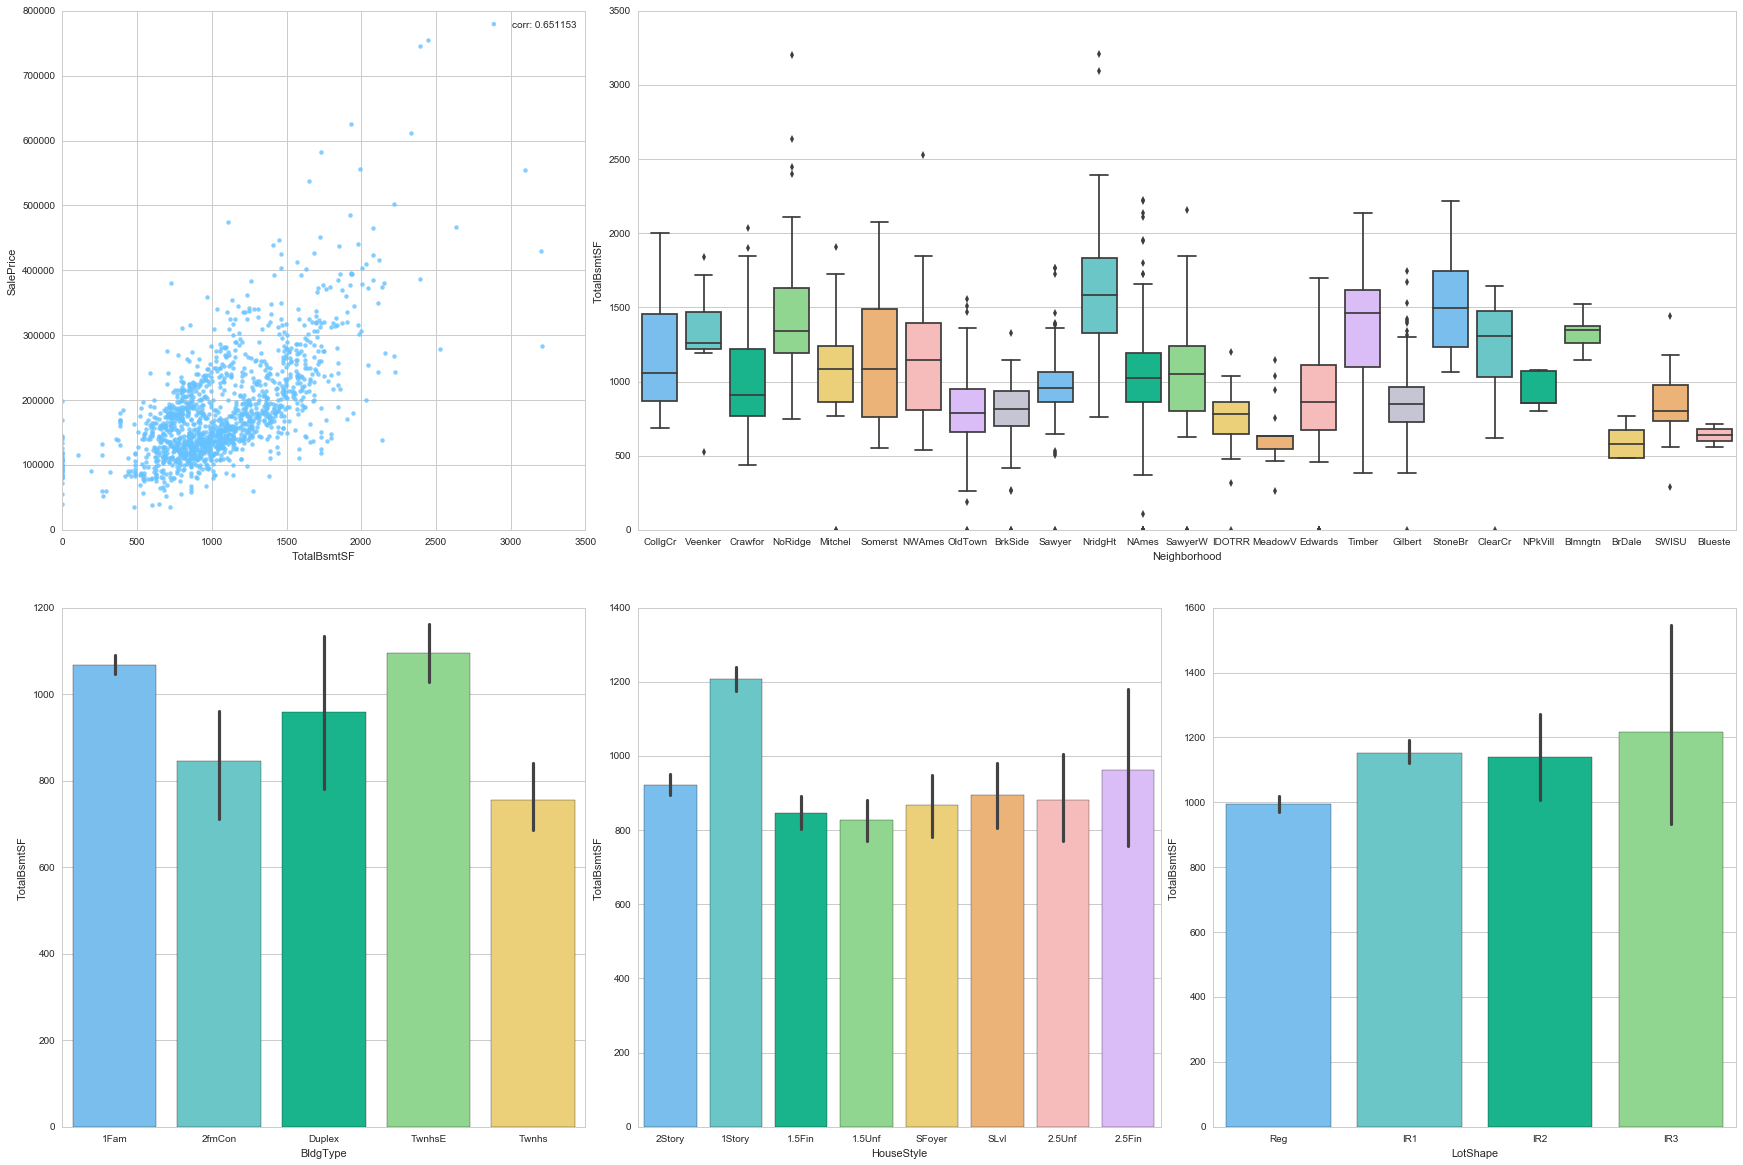

In [40]:
feature = 'TotalBsmtSF'
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 20))

# plot
plt.subplot(grid[0, 0])
g = sns.regplot(x=train[feature], y=train['SalePrice'], fit_reg=False,
                label = "corr: %2f"%(pearsonr(train[feature], train['SalePrice'])[0]))
g = g.legend(loc="best")
g.axes.set_xlim(0,)
g.axes.set_ylim(0,)

# plot
plt.subplot(grid[0, 1:])
sns.boxplot(x='Neighborhood', y=feature, data=train, palette = mycols)

# plot
plt.subplot(grid[1, 0]);
sns.barplot(x='BldgType', y=feature, data=train, palette = mycols)

# plot
plt.subplot(grid[1, 1]);
sns.barplot(x='HouseStyle', y=feature, data=train, palette = mycols)

# plot
plt.subplot(grid[1, 2]);
sns.barplot(x='LotShape', y=feature, data=train, palette = mycols);

**COMMENT**
- This feature is strongly positively correlated to the sale price. A small fraction of the data is assigned a 0 value.
- The area of unfinished basement varies greatly from one neighborhood to the other.
- However, the type of the house does not have a large impact on this feature.  
  
As previously performed, we will now bin the data.

In [41]:
all_data['TotalBsmtSF_Band'] = pd.cut(all_data['TotalBsmtSF'],10)
all_data['TotalBsmtSF_Band'].unique()

[(509.5, 1019.0], (1019.0, 1528.5], (1528.5, 2038.0], (-5.095, 509.5], (2038.0, 2547.5], (3057.0, 3566.5], (2547.5, 3057.0], (4585.5, 5095.0]]
Categories (8, interval[float64]): [(-5.095, 509.5] < (509.5, 1019.0] < (1019.0, 1528.5] < (1528.5, 2038.0] < (2038.0, 2547.5] < (2547.5, 3057.0] < (3057.0, 3566.5] < (4585.5, 5095.0]]

In [42]:
all_data.loc[all_data['TotalBsmtSF']<=509.5, 'TotalBsmtSF'] = 1
all_data.loc[(all_data['TotalBsmtSF']>509.5) & (all_data['TotalBsmtSF']<=1019), 'TotalBsmtSF'] = 2
all_data.loc[(all_data['TotalBsmtSF']>1019) & (all_data['TotalBsmtSF']<=1528.5), 'TotalBsmtSF'] = 3
all_data.loc[(all_data['TotalBsmtSF']>1528.5) & (all_data['TotalBsmtSF']<=2038), 'TotalBsmtSF'] = 4
all_data.loc[(all_data['TotalBsmtSF']>2038) & (all_data['TotalBsmtSF']<=2547.5), 'TotalBsmtSF'] = 5
all_data.loc[(all_data['TotalBsmtSF']>2547.5) & (all_data['TotalBsmtSF']<=3057), 'TotalBsmtSF'] = 6
all_data.loc[(all_data['TotalBsmtSF']>3057) & (all_data['TotalBsmtSF']<=3566.5), 'TotalBsmtSF'] = 7
all_data.loc[all_data['TotalBsmtSF']>3566.5, 'TotalBsmtSF'] = 8

all_data['TotalBsmtSF'] = all_data['TotalBsmtSF'].astype(int)
all_data.drop('TotalBsmtSF_Band', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["TotalBsmtSF"], prefix="TotalBsmtSF")
all_data.head(3)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave  None      Reg   
1          20       RL         80.0     9600   Pave  None      Reg   
2          60       RL         68.0    11250   Pave  None      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation  BsmtQual  BsmtCond  \
0       196.0        Gd        TA      PConc         3         3   
1         0.0        TA        TA     CBlock         3         3   
2       162.0        Gd        TA      PConc         3         3   

   BsmtExposure Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  \
0             1    GasA        Ex          Y      SBrkr       856       854   
1             4    GasA        Ex          Y      SBrkr      1262         0   
2             2    GasA        Ex          Y      SBrkr       920       866   

   LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  \
0             0       1710           1.0           0.0         2         1   
1             0       1262           0.0           1.0         2         0   
2             0       1786           1.0           0.0         2         1   

   BedroomAbvGr  KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  \
0             3             1          Gd             8        Typ   
1             3             1          TA             6        Typ   
2             3             1          Gd             6        Typ   

   Fireplaces FireplaceQu GarageType  GarageYrBlt GarageFinish  GarageCars  \
0           0        None     Attchd       2003.0          RFn         2.0   
1           1          TA     Attchd       1976.0          RFn         2.0   
2           1          TA     Attchd       2001.0          RFn         2.0   

   GarageArea GarageQual GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  \
0       548.0         TA         TA          Y           0           61   
1       460.0         TA         TA          Y         298            0   
2       608.0         TA         TA          Y           0           42   

   EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea PoolQC Fence MiscFeature  \
0              0          0            0         0   None  None        None   
1              0          0            0         0   None  None        None   
2              0          0            0         0   None  None        None   

   MiscVal  MoSold  YrSold SaleType SaleCondition  OverallQual-2  GrLivArea-2  \
0        0       2    2008       WD        Normal             49      2924100   
1        0       5    2007       WD        Normal             36      1592644   
2        0       9    2008       WD        Normal             49      3189796   

   TotalBsmtSF-2  GarageCars-2  GarageArea-2  1stFlrSF-2  FullBath-2  \
0       732736.0           4.0      300304.0      732736           4   
1      1592644.0           4.0      211600.0     1592644           4   
2       846400.0           4.0      369664.0      846400           4   

   TotRmsAbvGrd-2  YearBuilt-2  YearRemodAdd-2  GarageYrBlt-2  MasVnrArea-2  \
0              64      4012009         4012

**1stFlrSF**

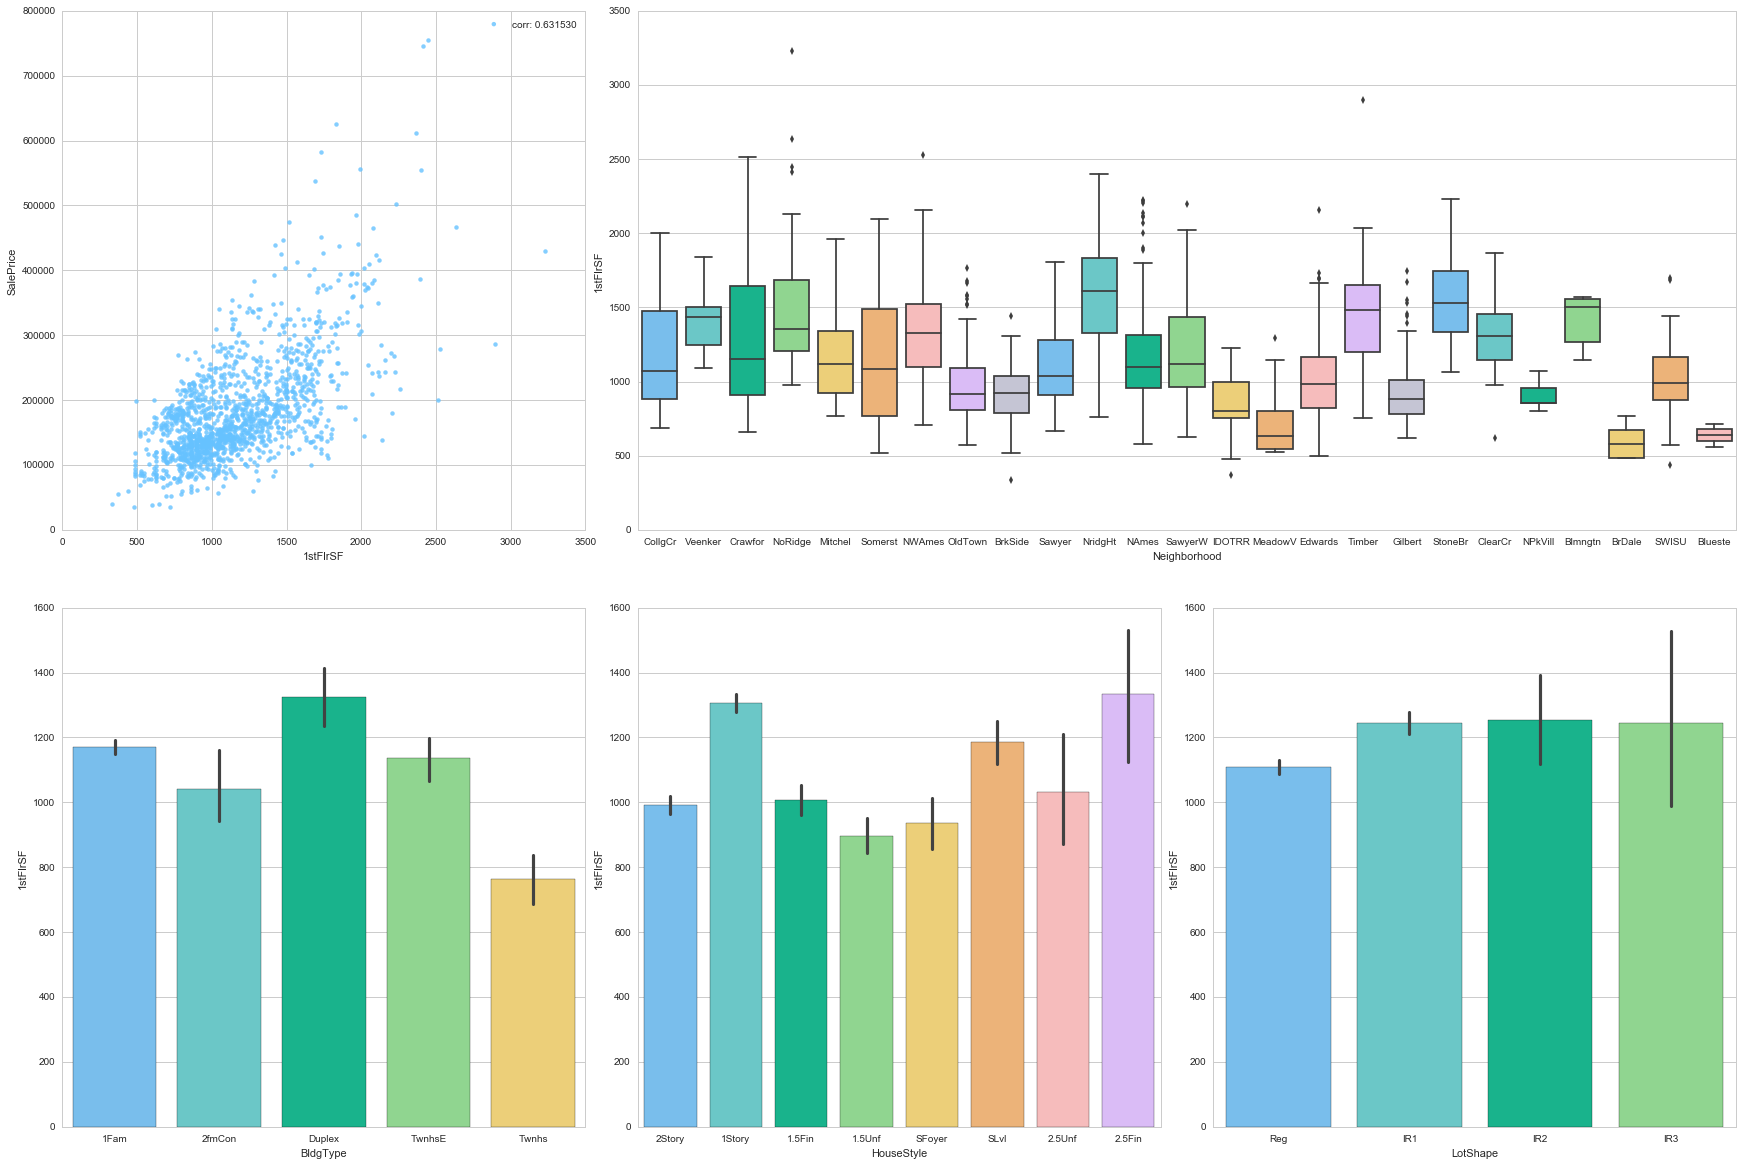

In [43]:
feature = '1stFlrSF'
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 20))

# plot
plt.subplot(grid[0, 0])
g = sns.regplot(x=train[feature], y=train['SalePrice'], fit_reg=False,
                label = "corr: %2f"%(pearsonr(train[feature], train['SalePrice'])[0]))
g = g.legend(loc="best")
g.axes.set_xlim(0,)
g.axes.set_ylim(0,)

# plot
plt.subplot(grid[0, 1:])
sns.boxplot(x='Neighborhood', y=feature, data=train, palette = mycols)

# plot
plt.subplot(grid[1, 0]);
sns.barplot(x='BldgType', y=feature, data=train, palette = mycols)

# plot
plt.subplot(grid[1, 1]);
sns.barplot(x='HouseStyle', y=feature, data=train, palette = mycols)

# plot
plt.subplot(grid[1, 2]);
sns.barplot(x='LotShape', y=feature, data=train, palette = mycols);

In [44]:
all_data['1stFlrSF'] = pd.qcut(all_data['1stFlrSF'],[x/6. for x in range(7)],range(1,7))
all_data['1stFlrSF'].unique()

[2, 4, 3, 1, 6, 5]
Categories (6, int64): [1 < 2 < 3 < 4 < 5 < 6]

In [45]:
all_data = pd.get_dummies(all_data, columns = ["1stFlrSF"], prefix="1stFlrSF")
all_data.head(3)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave  None      Reg   
1          20       RL         80.0     9600   Pave  None      Reg   
2          60       RL         68.0    11250   Pave  None      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation  BsmtQual  BsmtCond  \
0       196.0        Gd        TA      PConc         3         3   
1         0.0        TA        TA     CBlock         3         3   
2       162.0        Gd        TA      PConc         3         3   

   BsmtExposure Heating HeatingQC CentralAir Electrical  2ndFlrSF  \
0             1    GasA        Ex          Y      SBrkr       854   
1             4    GasA        Ex          Y      SBrkr         0   
2             2    GasA        Ex          Y      SBrkr       866   

   LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  \
0             0       1710           1.0           0.0         2         1   
1             0       1262           0.0           1.0         2         0   
2             0       1786           1.0           0.0         2         1   

   BedroomAbvGr  KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  \
0             3             1          Gd             8        Typ   
1             3             1          TA             6        Typ   
2             3             1          Gd             6        Typ   

   Fireplaces FireplaceQu GarageType  GarageYrBlt GarageFinish  GarageCars  \
0           0        None     Attchd       2003.0          RFn         2.0   
1           1          TA     Attchd       1976.0          RFn         2.0   
2           1          TA     Attchd       2001.0          RFn         2.0   

   GarageArea GarageQual GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  \
0       548.0         TA         TA          Y           0           61   
1       460.0         TA         TA          Y         298            0   
2       608.0         TA         TA          Y           0           42   

   EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea PoolQC Fence MiscFeature  \
0              0          0            0         0   None  None        None   
1              0          0            0         0   None  None        None   
2              0          0            0         0   None  None        None   

   MiscVal  MoSold  YrSold SaleType SaleCondition  OverallQual-2  GrLivArea-2  \
0        0       2    2008       WD        Normal             49      2924100   
1        0       5    2007       WD        Normal             36      1592644   
2        0       9    2008       WD        Normal             49      3189796   

   TotalBsmtSF-2  GarageCars-2  GarageArea-2  1stFlrSF-2  FullBath-2  \
0       732736.0           4.0      300304.0      732736           4   
1      1592644.0           4.0      211600.0     1592644           4   
2       846400.0           4.0      369664.0      846400           4   

   TotRmsAbvGrd-2  YearBuilt-2  YearRemodAdd-2  GarageYrBlt-2  MasVnrArea-2  \
0              64      4012009         4012009      4012009.0       38416.0   
1   

**2ndFlrSF**

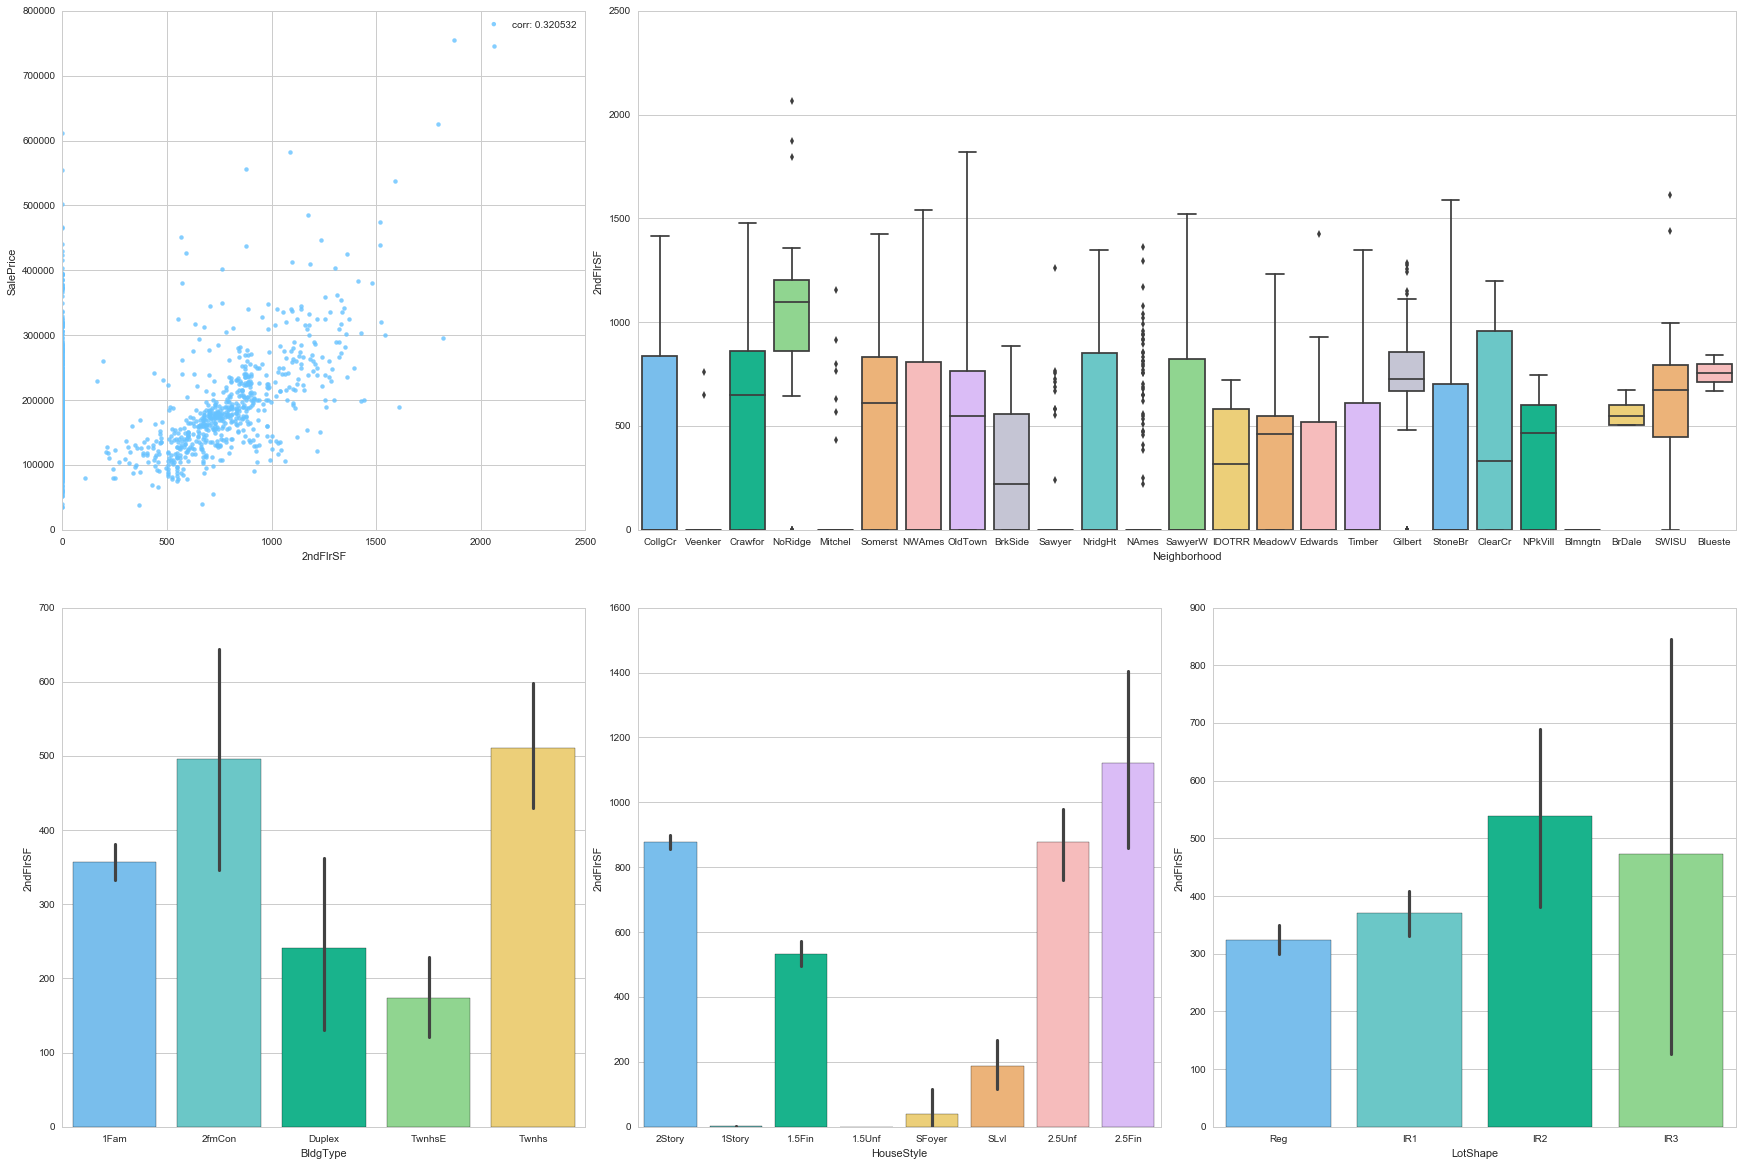

In [46]:
feature = '2ndFlrSF'
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 20))

# plot
plt.subplot(grid[0, 0])
g = sns.regplot(x=train[feature], y=train['SalePrice'], fit_reg=False,
                label = "corr: %2f"%(pearsonr(train[feature], train['SalePrice'])[0]))
g = g.legend(loc="best")
g.axes.set_xlim(0,)
g.axes.set_ylim(0,)

# plot
plt.subplot(grid[0, 1:])
sns.boxplot(x='Neighborhood', y=feature, data=train, palette = mycols)

# plot
plt.subplot(grid[1, 0]);
sns.barplot(x='BldgType', y=feature, data=train, palette = mycols)

# plot
plt.subplot(grid[1, 1]);
sns.barplot(x='HouseStyle', y=feature, data=train, palette = mycols)

# plot
plt.subplot(grid[1, 2]);
sns.barplot(x='LotShape', y=feature, data=train, palette = mycols);

**COMMENT**
- This feature is strongly positively correlated to the sale price. Moreover, a large number of data points are assigned to the value 0. This can be explained because a large number of individual houses are only built with one floor.
- The surface of the second floor varies greatly from one neighborhood to the other.
- However, the type of the house does not have a large impact on this feature.  
  
As previously performed, we will now bin the data.

In [47]:
all_data['2ndFlrSF_band'] = pd.cut(all_data['2ndFlrSF'], 6)
all_data['2ndFlrSF_band'].unique()

[(688.333, 1032.5], (-2.065, 344.167], (1032.5, 1376.667], (344.167, 688.333], (1376.667, 1720.833], (1720.833, 2065.0]]
Categories (6, interval[float64]): [(-2.065, 344.167] < (344.167, 688.333] < (688.333, 1032.5] < (1032.5, 1376.667] < (1376.667, 1720.833] < (1720.833, 2065.0]]

In [48]:
all_data.loc[all_data['2ndFlrSF']<=344.167, '2ndFlrSF'] = 1
all_data.loc[(all_data['2ndFlrSF']>344.167) & (all_data['2ndFlrSF']<=688.333), '2ndFlrSF'] = 2
all_data.loc[(all_data['2ndFlrSF']>688.333) & (all_data['2ndFlrSF']<=1032.5), '2ndFlrSF'] = 3
all_data.loc[(all_data['2ndFlrSF']>1032.5) & (all_data['2ndFlrSF']<=1376.667), '2ndFlrSF'] = 4
all_data.loc[(all_data['2ndFlrSF']>1376.667) & (all_data['2ndFlrSF']<=1720.833), '2ndFlrSF'] = 5
all_data.loc[all_data['2ndFlrSF']>1720.833, '2ndFlrSF'] = 6
all_data['2ndFlrSF'] = all_data['2ndFlrSF'].astype(int)

all_data.drop('2ndFlrSF_band', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["2ndFlrSF"], prefix="2ndFlrSF")
all_data.head(3)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave  None      Reg   
1          20       RL         80.0     9600   Pave  None      Reg   
2          60       RL         68.0    11250   Pave  None      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation  BsmtQual  BsmtCond  \
0       196.0        Gd        TA      PConc         3         3   
1         0.0        TA        TA     CBlock         3         3   
2       162.0        Gd        TA      PConc         3         3   

   BsmtExposure Heating HeatingQC CentralAir Electrical  LowQualFinSF  \
0             1    GasA        Ex          Y      SBrkr             0   
1             4    GasA        Ex          Y      SBrkr             0   
2             2    GasA        Ex          Y      SBrkr             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710           1.0           0.0         2         1             3   
1       1262           0.0           1.0         2         0             3   
2       1786           1.0           0.0         2         1             3   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0        None   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   

  GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea GarageQual  \
0     Attchd       2003.0          RFn         2.0       548.0         TA   
1     Attchd       1976.0          RFn         2.0       460.0         TA   
2     Attchd       2001.0          RFn         2.0       608.0         TA   

  GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  \
0         TA          Y           0           61              0          0   
1         TA          Y         298            0              0          0   
2         TA          Y           0           42              0          0   

   ScreenPorch  PoolArea PoolQC Fence MiscFeature  MiscVal  MoSold  YrSold  \
0            0         0   None  None        None        0       2    2008   
1            0         0   None  None        None        0       5    2007   
2            0         0   None  None        None        0       9    2008   

  SaleType SaleCondition  OverallQual-2  GrLivArea-2  TotalBsmtSF-2  \
0       WD        Normal             49      2924100       732736.0   
1       WD        Normal             36      1592644      1592644.0   
2       WD        Normal             49      3189796       846400.0   

   GarageCars-2  GarageArea-2  1stFlrSF-2  FullBath-2  TotRmsAbvGrd-2  \
0           4.0      300304.0      732736           4              64   
1           4.0      211600.0     1592644           4              36   
2           4.0      369664.0      846400           4              36   

   YearBuilt-2  YearRemodAdd-2  GarageYrBlt-2  MasVnrArea-2  Fireplaces-2  \
0      4012009         4012009      4012009.0       38416.0  

**LowQualFinSF**

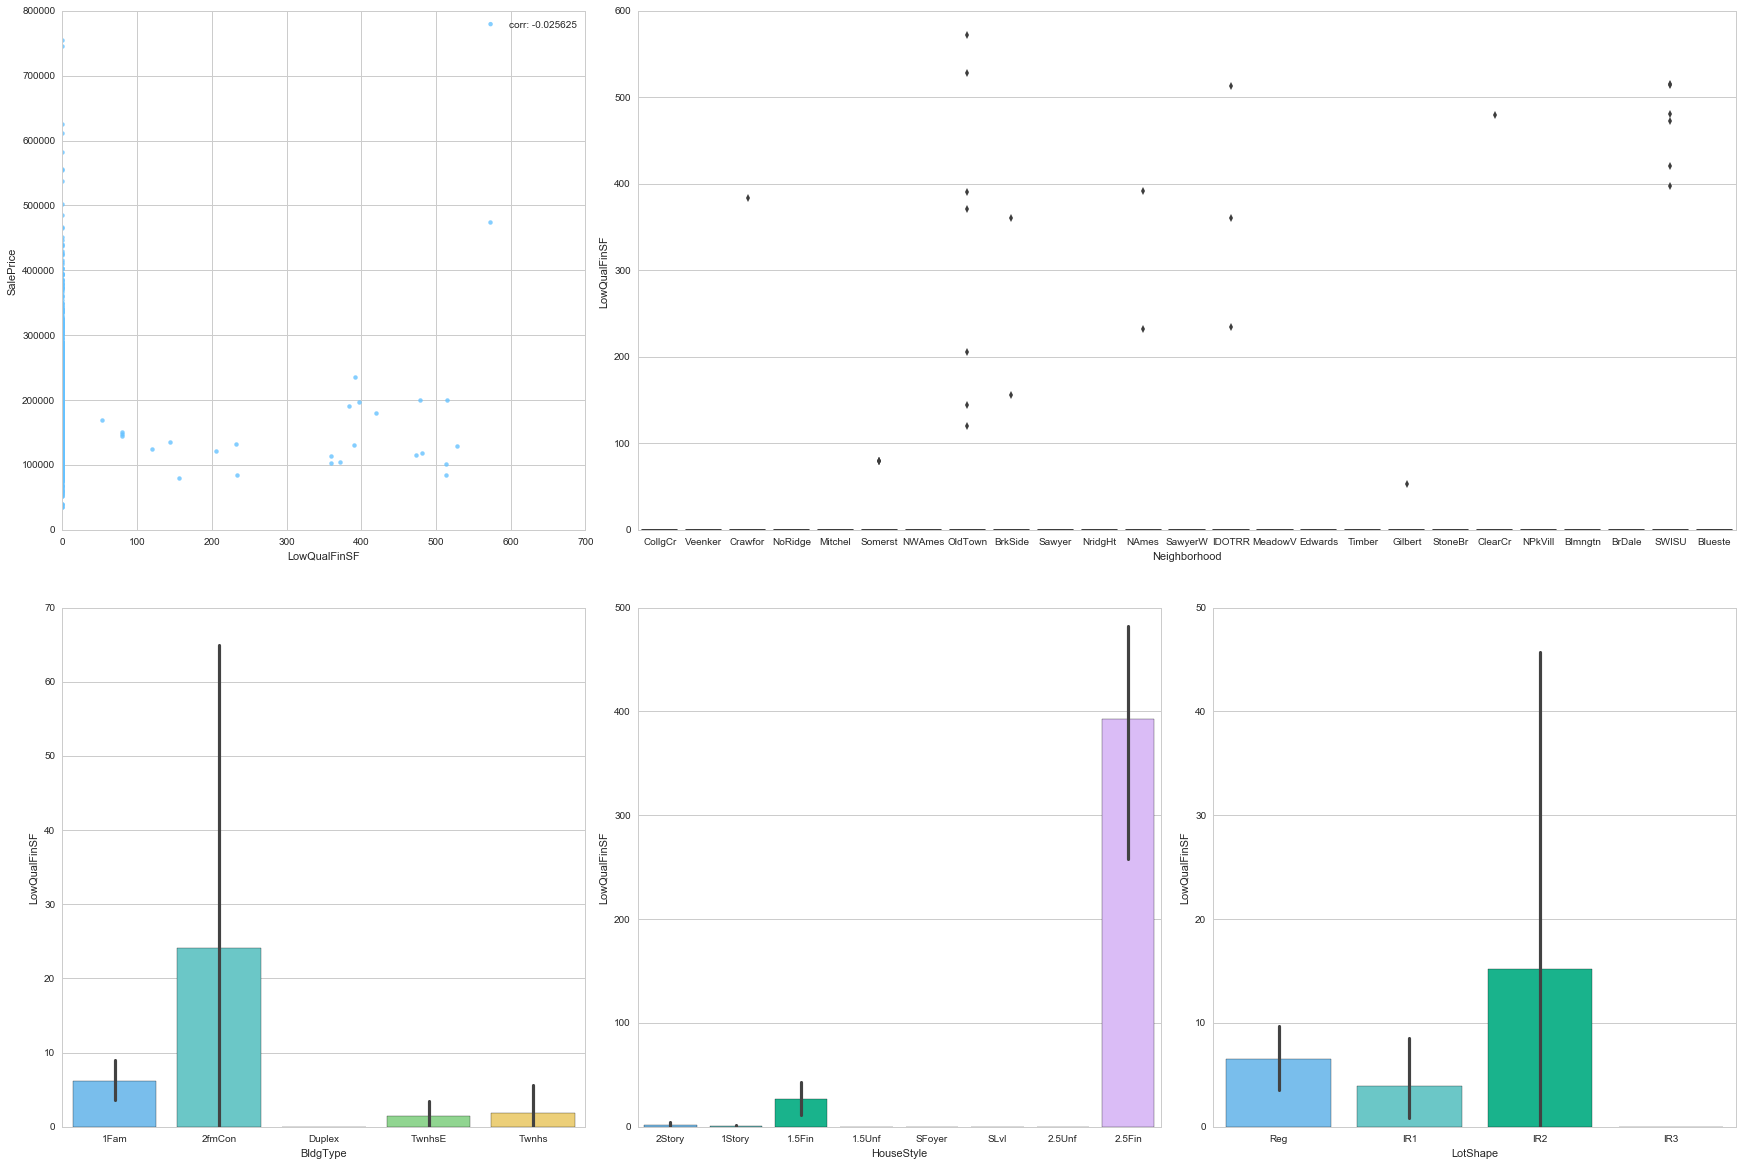

In [49]:
feature = 'LowQualFinSF'
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 20))

# plot
plt.subplot(grid[0, 0])
g = sns.regplot(x=train[feature], y=train['SalePrice'], fit_reg=False,
                label = "corr: %2f"%(pearsonr(train[feature], train['SalePrice'])[0]))
g = g.legend(loc="best")
g.axes.set_xlim(0,)
g.axes.set_ylim(0,)

# plot
plt.subplot(grid[0, 1:])
sns.boxplot(x='Neighborhood', y=feature, data=train, palette = mycols)

# plot
plt.subplot(grid[1, 0]);
sns.barplot(x='BldgType', y=feature, data=train, palette = mycols)

# plot
plt.subplot(grid[1, 1]);
sns.barplot(x='HouseStyle', y=feature, data=train, palette = mycols)

# plot
plt.subplot(grid[1, 2]);
sns.barplot(x='LotShape', y=feature, data=train, palette = mycols);

**COMMENT**
- Most of the data is assigned the value 0.

As previously performed, we will simply flag the non-zero records.

In [50]:
# create a flag feature that corresponds to 0 values
all_data['LowQualFinSF_flag'] = all_data['LowQualFinSF'].map(lambda x: 0 if x==0 else 1)
all_data.drop('LowQualFinSF', axis=1, inplace=True)

**BsmtHalfBath BsmtFullBath, HalfBath, FullBathz**  
For this features, we will simply sum all four values to obtain the total number of bathrooms.

In [51]:
all_data['TotalBathrooms'] = all_data['BsmtHalfBath'] + all_data['BsmtFullBath'] + all_data['HalfBath'] + all_data['FullBath']
all_data.drop(['BsmtHalfBath', 'BsmtFullBath', 'HalfBath', 'FullBath'], axis=1, inplace=True)

**BedroomAbvGr**

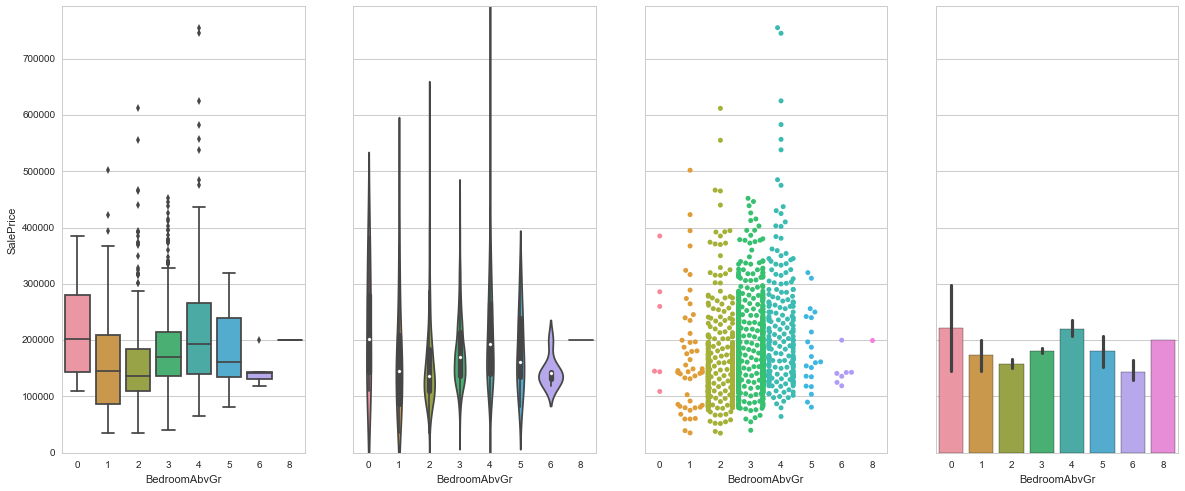

In [52]:
feature = 'BedroomAbvGr'
fig, axarr = plt.subplots(1,4,figsize =(20, 8),sharey=True)

# plot
#plt.subplot(1,4,1)
sns.boxplot(x=feature, y='SalePrice',data=train,ax=axarr[0])

# plot
#plt.subplot(1,4,2)
plot = sns.violinplot(x=feature, y='SalePrice',data=train, showmeans=False,
               showmedians=False,showextrema=False,ax=axarr[1])
axarr[1].set_ylabel("")

# plot
#plt.subplot(1,4,3)
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,ax=axarr[2])
axarr[2].set_ylabel("")

# purpose
#plt.subplot(1,4,4)
sns.barplot(x=feature, y='SalePrice',data=train,ax=axarr[3])
axarr[3].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

**COMMENT**
- Most houses have between two and four bedrooms above grade level.

**KitchenAbvGr**

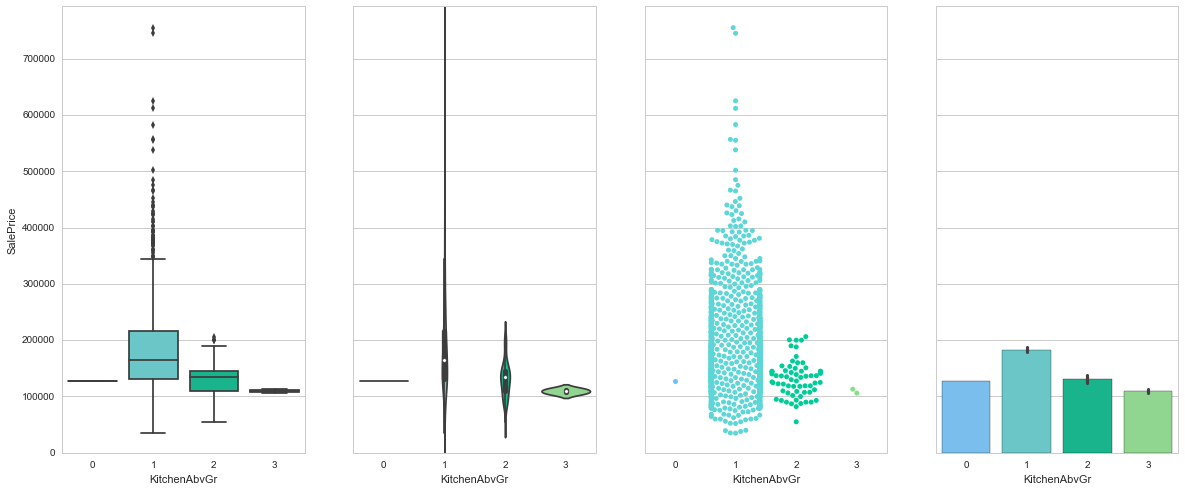

In [53]:
feature = 'KitchenAbvGr'
fig, axarr = plt.subplots(1,4,figsize =(20, 8),sharey=True)

# plot
#plt.subplot(1,4,1)
sns.boxplot(x=feature, y='SalePrice',data=train,ax=axarr[0])

# plot
#plt.subplot(1,4,2)
plot = sns.violinplot(x=feature, y='SalePrice',data=train, showmeans=False,
               showmedians=False,showextrema=False,ax=axarr[1])
axarr[1].set_ylabel("")

# plot
#plt.subplot(1,4,3)
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,ax=axarr[2])
axarr[2].set_ylabel("")

# purpose
#plt.subplot(1,4,4)
sns.barplot(x=feature, y='SalePrice',data=train,ax=axarr[3])
axarr[3].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

**COMMENT**
- Most houses have one kitchen.

**KitchenQual**

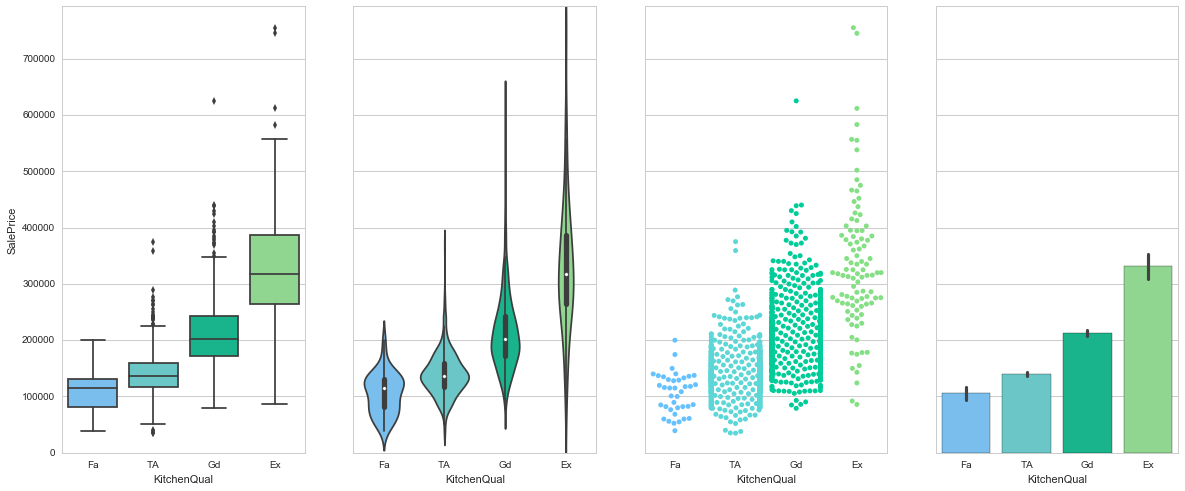

In [54]:
feature = 'KitchenQual'
order = ['Fa', 'TA', 'Gd', 'Ex']
fig, axarr = plt.subplots(1,4,figsize =(20, 8),sharey=True)

# plot
#plt.subplot(1,4,1)
sns.boxplot(x=feature, y='SalePrice',data=train,order=order,ax=axarr[0])

# plot
#plt.subplot(1,4,2)
plot = sns.violinplot(x=feature, y='SalePrice',data=train, showmeans=False,
               showmedians=False,showextrema=False,order=order,ax=axarr[1])
axarr[1].set_ylabel("")

# plot
#plt.subplot(1,4,3)
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,order=order,ax=axarr[2])
axarr[2].set_ylabel("")

# purpose
#plt.subplot(1,4,4)
sns.barplot(x=feature, y='SalePrice',data=train,order=order,ax=axarr[3])
axarr[3].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

**COMMENT**: We found an order of the classes for KitchenQual that produces an increase in the sale price. We will use this to create a ordinal feature.

In [55]:
all_data['KitchenQual'] = all_data['KitchenQual'].map({"Fa":1, "TA":2, "Gd":3, "Ex":4})
all_data['KitchenQual'].unique()

array([3, 2, 4, 1])

**TotRmsAbvGrd**

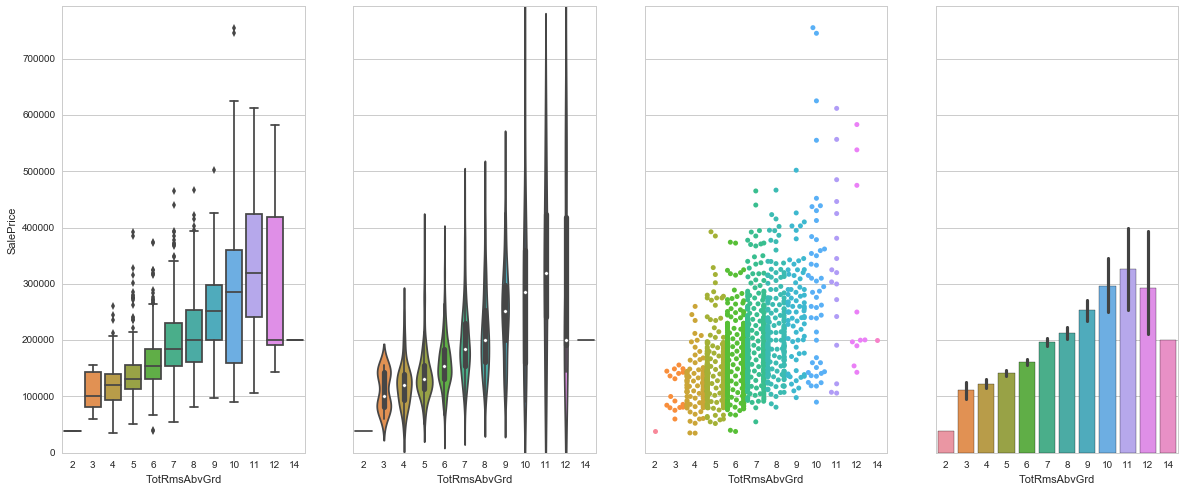

In [56]:
feature = 'TotRmsAbvGrd'
fig, axarr = plt.subplots(1,4,figsize =(20, 8),sharey=True)

# plot
#plt.subplot(1,4,1)
sns.boxplot(x=feature, y='SalePrice',data=train,ax=axarr[0])

# plot
#plt.subplot(1,4,2)
plot = sns.violinplot(x=feature, y='SalePrice',data=train, showmeans=False,
               showmedians=False,showextrema=False,ax=axarr[1])
axarr[1].set_ylabel("")

# plot
#plt.subplot(1,4,3)
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,ax=axarr[2])
axarr[2].set_ylabel("")

# purpose
#plt.subplot(1,4,4)
sns.barplot(x=feature, y='SalePrice',data=train,ax=axarr[3])
axarr[3].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

**COMMENT**
- There seems to be a positive correlation between the number of rooms and the sale prince.
- The extreme classes (2, 12, and 14) do not have enought data for to be reliable.

**Fireplaces**

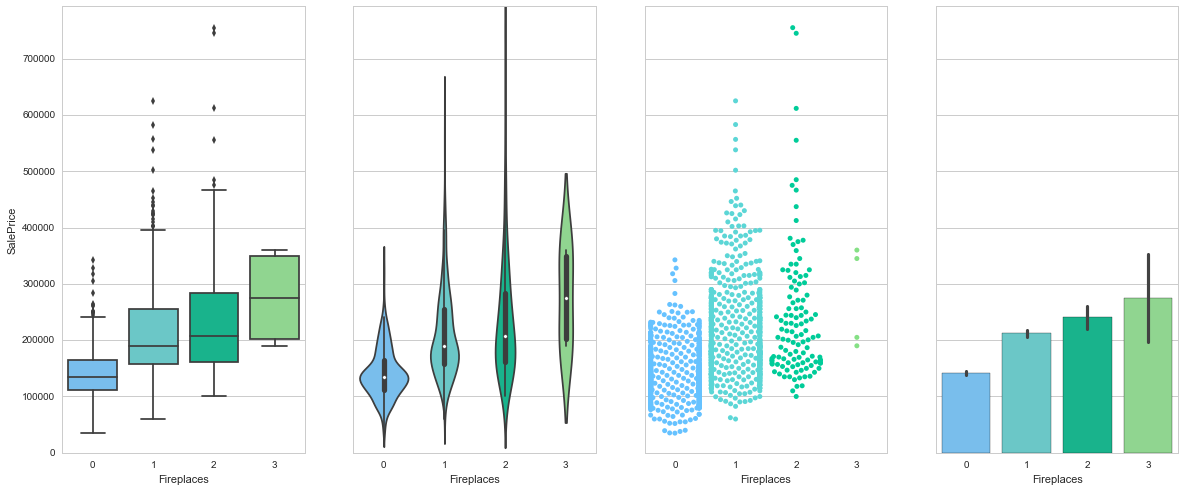

In [57]:
feature = 'Fireplaces'
fig, axarr = plt.subplots(1,4,figsize =(20, 8),sharey=True)

# plot
#plt.subplot(1,4,1)
sns.boxplot(x=feature, y='SalePrice',data=train,ax=axarr[0])

# plot
#plt.subplot(1,4,2)
plot = sns.violinplot(x=feature, y='SalePrice',data=train, showmeans=False,
               showmedians=False,showextrema=False,ax=axarr[1])
axarr[1].set_ylabel("")

# plot
#plt.subplot(1,4,3)
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,ax=axarr[2])
axarr[2].set_ylabel("")

# purpose
#plt.subplot(1,4,4)
sns.barplot(x=feature, y='SalePrice',data=train,ax=axarr[3])
axarr[3].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

**COMMENT**
- There seems to be a positive correlation between the number of fireplaces and the sale prince.
- The extreme classe (3) do not have enought data for to be reliable.

**FireplaceQu**

In [58]:
train['FireplaceQu'].unique()

array([nan, 'TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object)

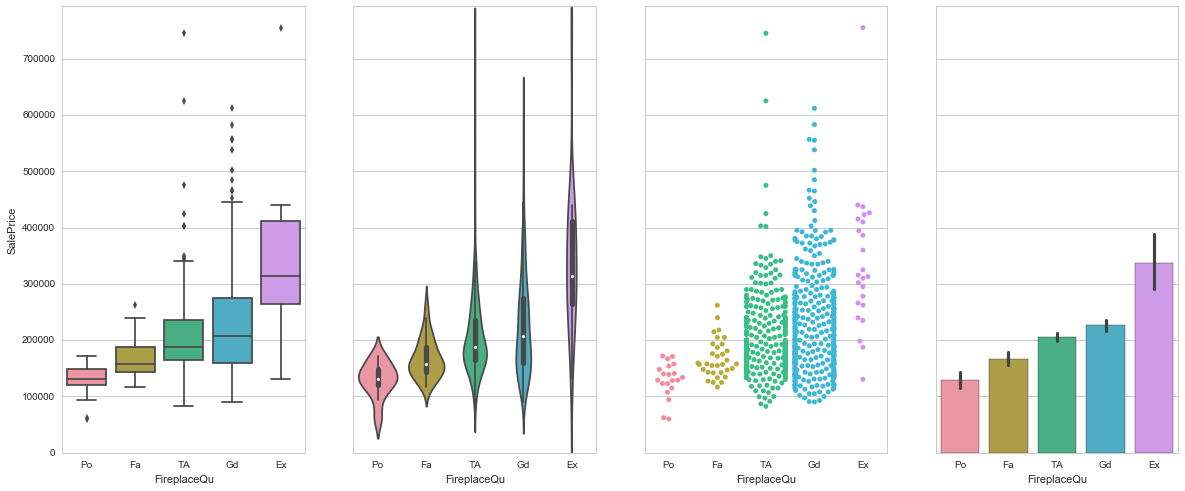

In [59]:
feature = 'FireplaceQu'
order = ["Po", "Fa", "TA", "Gd", "Ex"]
fig, axarr = plt.subplots(1,4,figsize =(20, 8),sharey=True)

# plot
#plt.subplot(1,4,1)
sns.boxplot(x=feature, y='SalePrice',data=train,order=order,ax=axarr[0])

# plot
#plt.subplot(1,4,2)
plot = sns.violinplot(x=feature, y='SalePrice',data=train, showmeans=False,
               showmedians=False,showextrema=False,order=order,ax=axarr[1])
axarr[1].set_ylabel("")

# plot
#plt.subplot(1,4,3)
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,order=order,ax=axarr[2])
axarr[2].set_ylabel("")

# purpose
#plt.subplot(1,4,4)
sns.barplot(x=feature, y='SalePrice',data=train,order=order,ax=axarr[3])
axarr[3].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

**COMMENT**: We found an order of the classes for FireplaceQu that produces an increase in the sale price. We will use this to create a ordinal feature.

In [60]:
all_data['FireplaceQu'] = all_data['FireplaceQu'].map({"None":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
all_data['FireplaceQu'].unique()

array([0, 3, 4, 2, 5, 1])

**GrLivArea**

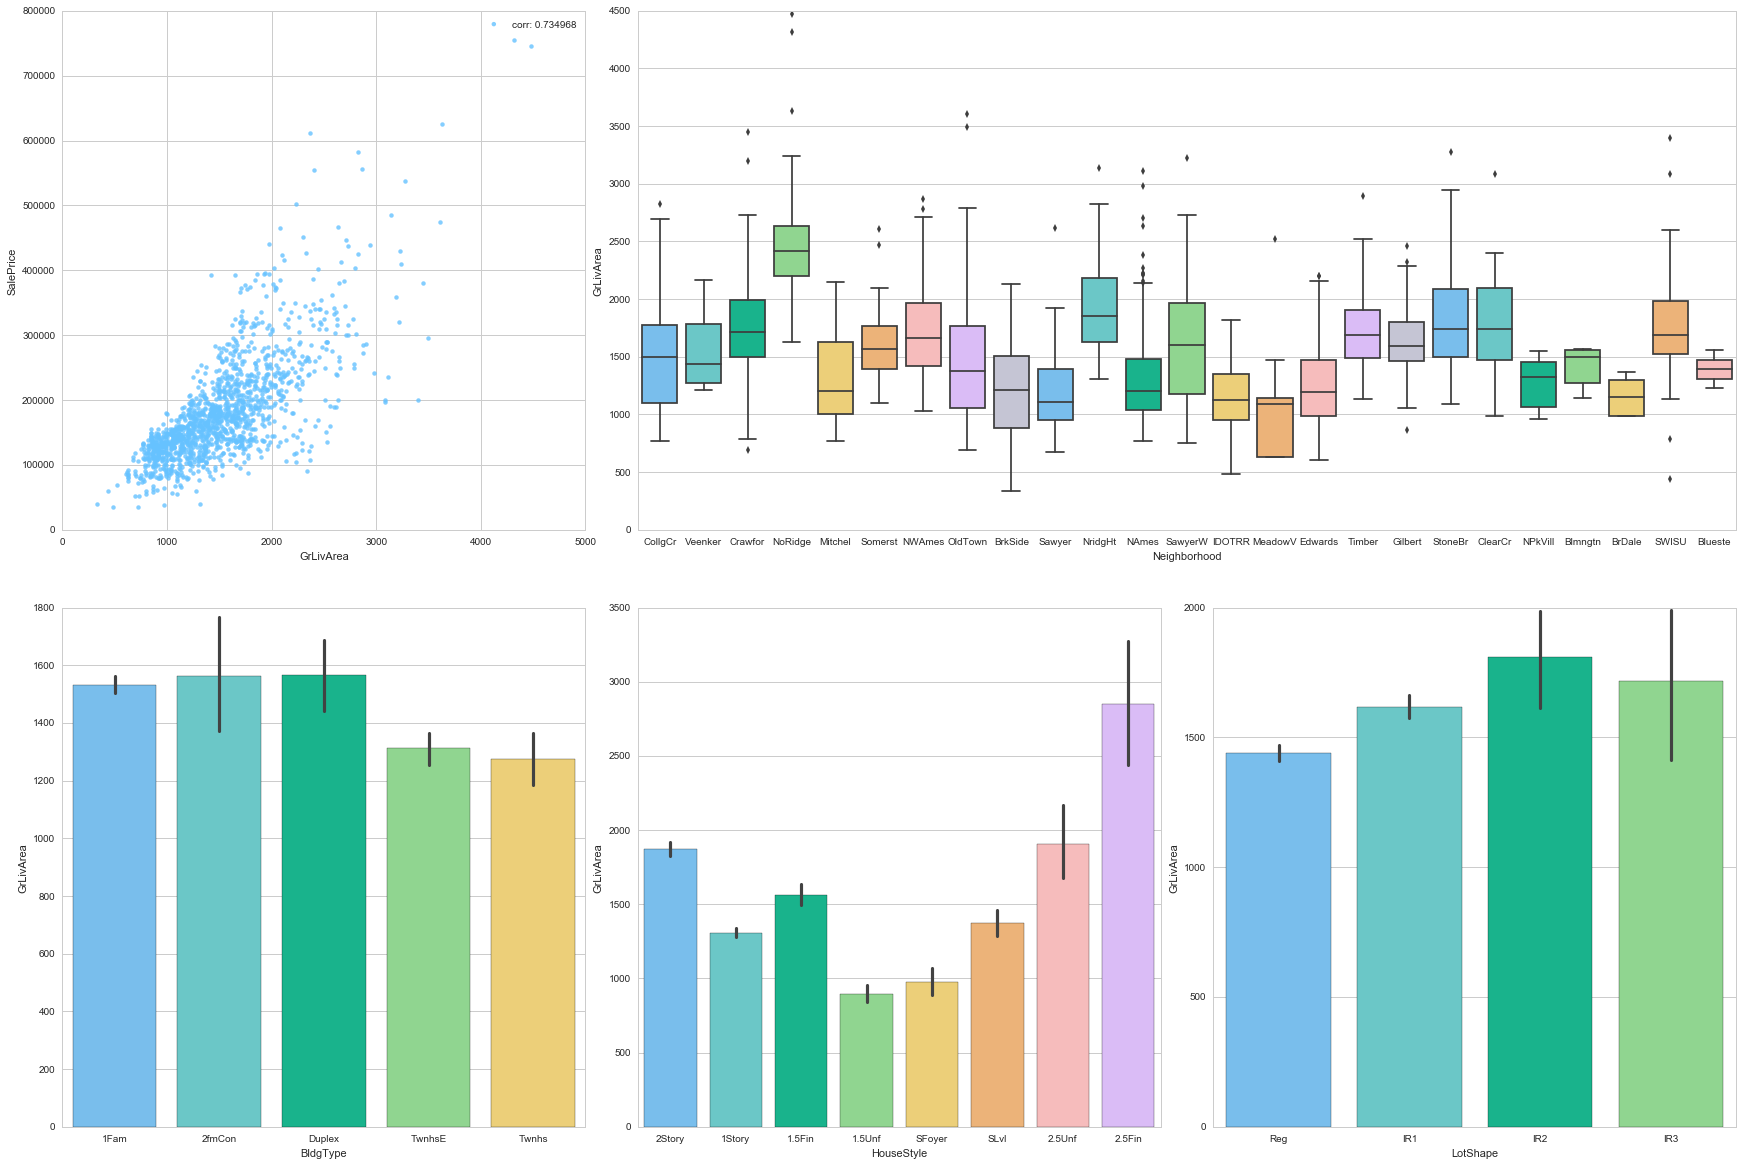

In [61]:
feature = 'GrLivArea'
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 20))

# plot
plt.subplot(grid[0, 0])
g = sns.regplot(x=train[feature], y=train['SalePrice'], fit_reg=False,
                label = "corr: %2f"%(pearsonr(train[feature], train['SalePrice'])[0]))
g = g.legend(loc="best")
g.axes.set_xlim(0,)
g.axes.set_ylim(0,)

# plot
plt.subplot(grid[0, 1:])
sns.boxplot(x='Neighborhood', y=feature, data=train, palette = mycols)

# plot
plt.subplot(grid[1, 0]);
sns.barplot(x='BldgType', y=feature, data=train, palette = mycols)

# plot
plt.subplot(grid[1, 1]);
sns.barplot(x='HouseStyle', y=feature, data=train, palette = mycols)

# plot
plt.subplot(grid[1, 2]);
sns.barplot(x='LotShape', y=feature, data=train, palette = mycols);

**COMMENT**
- This feature is strongly positively correlated to the sale price. Moreover, a large number of data points are assigned to the value 0. This can be explained because a large number of individual houses are only built with one floor.
- This feature varies greatly from one neighborhood to the other.
- However, the type of the house does not have a large impact on this feature.  
  
As previously performed, we will now bin the data.

In [62]:
all_data['GrLivArea_band'] = pd.cut(all_data['GrLivArea'], 6)
all_data['GrLivArea_band'].unique()

[(1127.5, 1921.0], (1921.0, 2714.5], (329.239, 1127.5], (2714.5, 3508.0], (3508.0, 4301.5], (4301.5, 5095.0]]
Categories (6, interval[float64]): [(329.239, 1127.5] < (1127.5, 1921.0] < (1921.0, 2714.5] < (2714.5, 3508.0] < (3508.0, 4301.5] < (4301.5, 5095.0]]

In [63]:
all_data.loc[all_data['GrLivArea']<=1127.5, 'GrLivArea'] = 1
all_data.loc[(all_data['GrLivArea']>1127.5) & (all_data['GrLivArea']<=1921.0), 'GrLivArea'] = 2
all_data.loc[(all_data['GrLivArea']>1921.0) & (all_data['GrLivArea']<=2714.5), 'GrLivArea'] = 3
all_data.loc[(all_data['GrLivArea']>2714.5) & (all_data['GrLivArea']<=3508.0), 'GrLivArea'] = 4
all_data.loc[(all_data['GrLivArea']>3508.0) & (all_data['GrLivArea']<=4301.5), 'GrLivArea'] = 5
all_data.loc[all_data['GrLivArea']>4301.5, 'GrLivArea'] = 6
all_data['GrLivArea'] = all_data['GrLivArea'].astype(int)

all_data.drop('GrLivArea_band', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["GrLivArea"], prefix="GrLivArea")
all_data.head(3)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave  None      Reg   
1          20       RL         80.0     9600   Pave  None      Reg   
2          60       RL         68.0    11250   Pave  None      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation  BsmtQual  BsmtCond  \
0       196.0        Gd        TA      PConc         3         3   
1         0.0        TA        TA     CBlock         3         3   
2       162.0        Gd        TA      PConc         3         3   

   BsmtExposure Heating HeatingQC CentralAir Electrical  BedroomAbvGr  \
0             1    GasA        Ex          Y      SBrkr             3   
1             4    GasA        Ex          Y      SBrkr             3   
2             2    GasA        Ex          Y      SBrkr             3   

   KitchenAbvGr  KitchenQual  TotRmsAbvGrd Functional  Fireplaces  \
0             1            3             8        Typ           0   
1             1            2             6        Typ           1   
2             1            3             6        Typ           1   

   FireplaceQu GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea  \
0            0     Attchd       2003.0          RFn         2.0       548.0   
1            3     Attchd       1976.0          RFn         2.0       460.0   
2            3     Attchd       2001.0          RFn         2.0       608.0   

  GarageQual GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  \
0         TA         TA          Y           0           61              0   
1         TA         TA          Y         298            0              0   
2         TA         TA          Y           0           42              0   

   3SsnPorch  ScreenPorch  PoolArea PoolQC Fence MiscFeature  MiscVal  MoSold  \
0          0            0         0   None  None        None        0       2   
1          0            0         0   None  None        None        0       5   
2          0            0         0   None  None        None        0       9   

   YrSold SaleType SaleCondition  OverallQual-2  GrLivArea-2  TotalBsmtSF-2  \
0    2008       WD        Normal             49      2924100       732736.0   
1    2007       WD        Normal             36      1592644      1592644.0   
2    2008       WD        Normal             49      3189796       846400.0   

   GarageCars-2  GarageArea-2  1stFlrSF-2  FullBath-2  TotRmsAbvGrd-2  \
0           4.0      300304.0      732736           4              64   
1           4.0      211600.0     1592644           4              36   
2           4.0      369664.0      846400           4              36   

   YearBuilt-2  YearRemodAdd-2  GarageYrBlt-2  MasVnrArea-2  Fireplaces-2  \
0      4012009         4012009      4012009.0       38416.0             0   
1      3904576         3904576      3904576.0           0.0             1   
2      4004001         4008004      4004001.0       26244.0             1   

   BsmtFinSF1-2  LotFrontage-2  2ndFlrSF-2  WoodDeckSF-2  OpenPorchSF-2  \
0      498436.0         4225.0      729316             0   

### Exterior
The following variables are assigned to the "Exterior" group.
- MS SubClass (Nominal): Identifies the type of dwelling involved in the sale.
- Bldg Type (Nominal): Type of dwelling
- House Style (Nominal): Style of dwelling
- Overall Qual (Ordinal): Rates the overall material and finish of the house
- Overall Cond (Ordinal): Rates the overall condition of the house
- Year Built (Discrete): Original construction date
- Year Remod/Add (Discrete): Remodel date (same as construction date if no remodeling or additions)
- Foundation (Nominal): Type of foundation
- Functional (Ordinal): Home functionality (Assume typical unless deductions are warranted)
- Roof Style (Nominal): Type of roof
- Roof Matl (Nominal): Roof material
- Exterior 1 (Nominal): Exterior covering on house
- Exterior 2 (Nominal): Exterior covering on house (if more than one material)
- Mas Vnr Type (Nominal): Masonry veneer type
- Mas Vnr Area (Continuous): Masonry veneer area in square feet
- Exter Qual (Ordinal): Evaluates the quality of the material on the exterior 
- Exter Cond (Ordinal): Evaluates the present condition of the material on the exterior
- Garage Type (Nominal): Garage location
- Garage Yr Blt (Discrete): Year garage was built
- Garage Finish (Ordinal)	: Interior finish of the garage
- Garage Cars (Discrete): Size of garage in car capacity
- Garage Area (Continuous): Size of garage in square feet
- Garage Qual (Ordinal): Garage quality
- Garage Cond (Ordinal): Garage condition
- Wood Deck SF (Continuous): Wood deck area in square feet
- Open Porch SF (Continuous): Open porch area in square feet
- Enclosed Porch (Continuous): Enclosed porch area in square feet
- 3-Ssn Porch (Continuous): Three season porch area in square feet
- Screen Porch (Continuous): Screen porch area in square feet
- Pool Area (Continuous): Pool area in square feet
- Pool QC (Ordinal): Pool quality
- Fence (Ordinal): Fence quality

**MSSubClass**

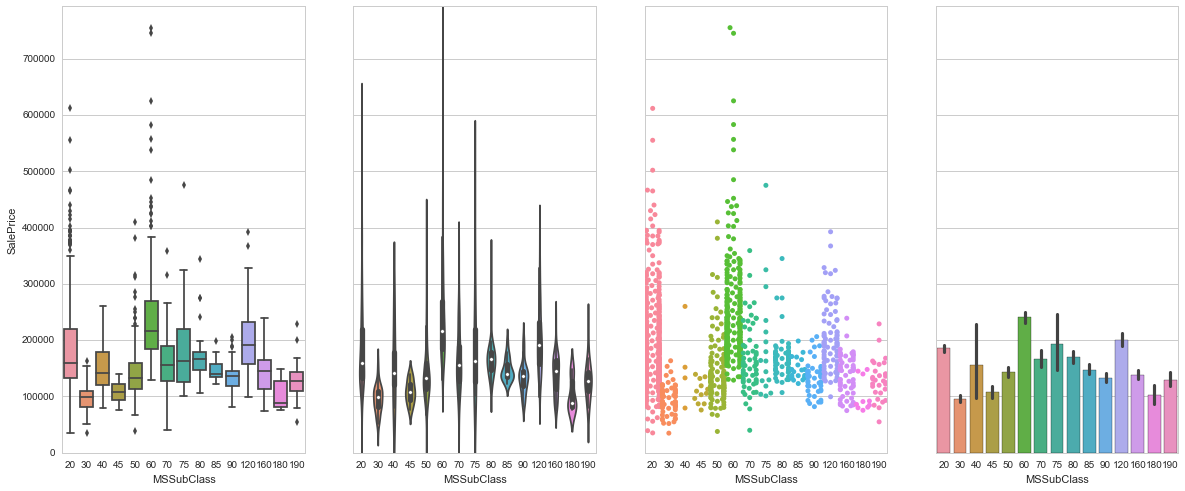

In [64]:
feature = 'MSSubClass'
fig, axarr = plt.subplots(1,4,figsize =(20, 8),sharey=True)

# plot
#plt.subplot(1,4,1)
sns.boxplot(x=feature, y='SalePrice',data=train,ax=axarr[0])

# plot
#plt.subplot(1,4,2)
plot = sns.violinplot(x=feature, y='SalePrice',data=train, showmeans=False,
               showmedians=False,showextrema=False,ax=axarr[1])
axarr[1].set_ylabel("")

# plot
#plt.subplot(1,4,3)
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,ax=axarr[2])
axarr[2].set_ylabel("")

# purpose
#plt.subplot(1,4,4)
sns.barplot(x=feature, y='SalePrice',data=train,ax=axarr[3])
axarr[3].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

**COMMENT**
- Although this feature contains numerical value, it is meant to describe building style. We therefore turn the data into strings.

In [65]:
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)

all_data = pd.get_dummies(all_data, columns = ["MSSubClass"], prefix="MSSubClass")

**BldgType**

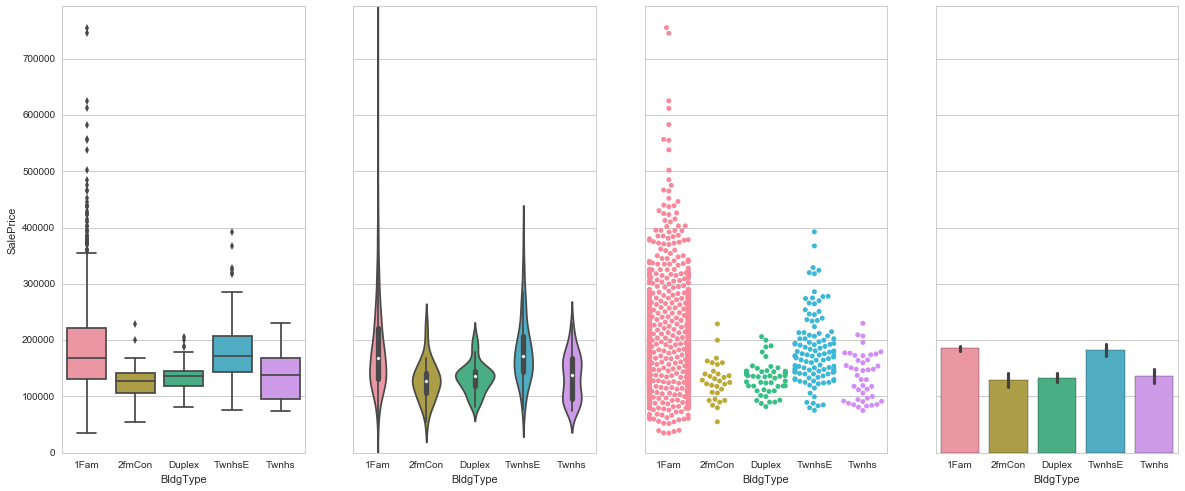

In [66]:
feature = 'BldgType'
fig, axarr = plt.subplots(1,4,figsize =(20, 8),sharey=True)

# plot
#plt.subplot(1,4,1)
sns.boxplot(x=feature, y='SalePrice',data=train,ax=axarr[0])

# plot
#plt.subplot(1,4,2)
plot = sns.violinplot(x=feature, y='SalePrice',data=train, showmeans=False,
               showmedians=False,showextrema=False,ax=axarr[1])
axarr[1].set_ylabel("")

# plot
#plt.subplot(1,4,3)
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,ax=axarr[2])
axarr[2].set_ylabel("")

# purpose
#plt.subplot(1,4,4)
sns.barplot(x=feature, y='SalePrice',data=train,ax=axarr[3])
axarr[3].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

**COMMENT**
- The feature is transformed using dummies.

In [67]:
all_data = pd.get_dummies(all_data, columns = ["BldgType"], prefix="BldgType")

**HouseStyle**

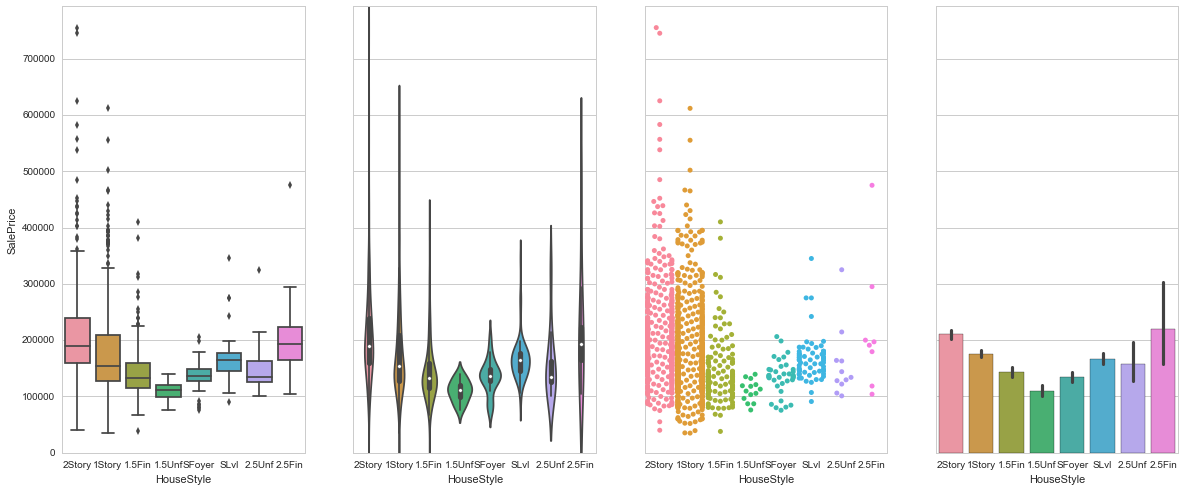

In [68]:
feature = 'HouseStyle'
fig, axarr = plt.subplots(1,4,figsize =(20, 8),sharey=True)

# plot
#plt.subplot(1,4,1)
sns.boxplot(x=feature, y='SalePrice',data=train,ax=axarr[0])

# plot
#plt.subplot(1,4,2)
plot = sns.violinplot(x=feature, y='SalePrice',data=train, showmeans=False,
               showmedians=False,showextrema=False,ax=axarr[1])
axarr[1].set_ylabel("")

# plot
#plt.subplot(1,4,3)
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,ax=axarr[2])
axarr[2].set_ylabel("")

# purpose
#plt.subplot(1,4,4)
sns.barplot(x=feature, y='SalePrice',data=train,ax=axarr[3])
axarr[3].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

**COMMENT**
- The first two categories present a large number of extremely high values.
- This feature is turned into a set of dummy variables.

In [69]:
all_data = pd.get_dummies(all_data, columns = ["HouseStyle"], prefix="HouseStyle")

**OverallQual**

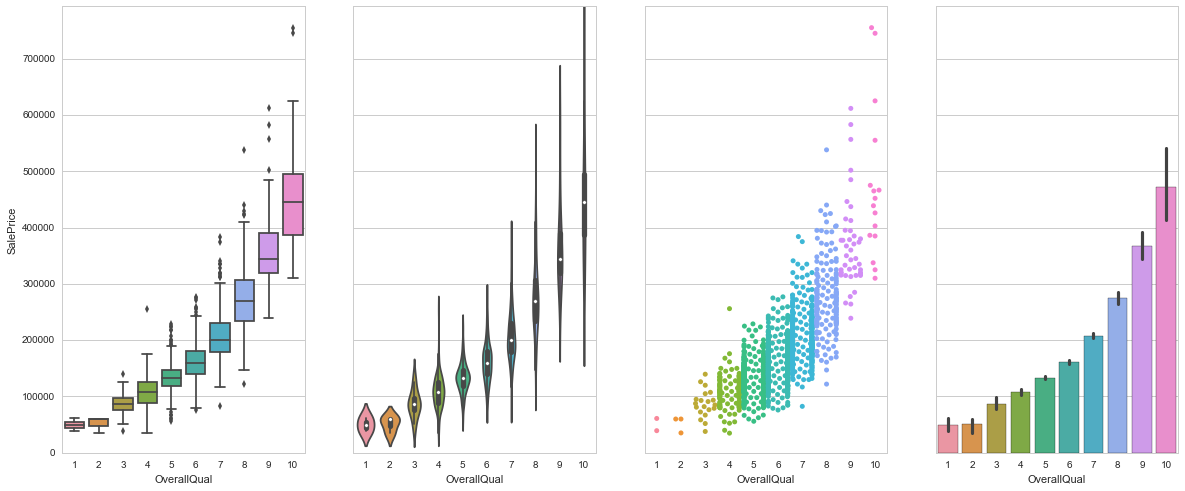

In [70]:
feature = 'OverallQual'
fig, axarr = plt.subplots(1,4,figsize =(20, 8),sharey=True)

# plot
#plt.subplot(1,4,1)
sns.boxplot(x=feature, y='SalePrice',data=train,ax=axarr[0])

# plot
#plt.subplot(1,4,2)
plot = sns.violinplot(x=feature, y='SalePrice',data=train, showmeans=False,
               showmedians=False,showextrema=False,ax=axarr[1])
axarr[1].set_ylabel("")

# plot
#plt.subplot(1,4,3)
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,ax=axarr[2])
axarr[2].set_ylabel("")

# purpose
#plt.subplot(1,4,4)
sns.barplot(x=feature, y='SalePrice',data=train,ax=axarr[3])
axarr[3].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

**COMMENT**
- As expected, the overall quality is strongly positively correlated to the sale price.
  
The choice is made to keep this ordinal feature as is.

**OverallCond**

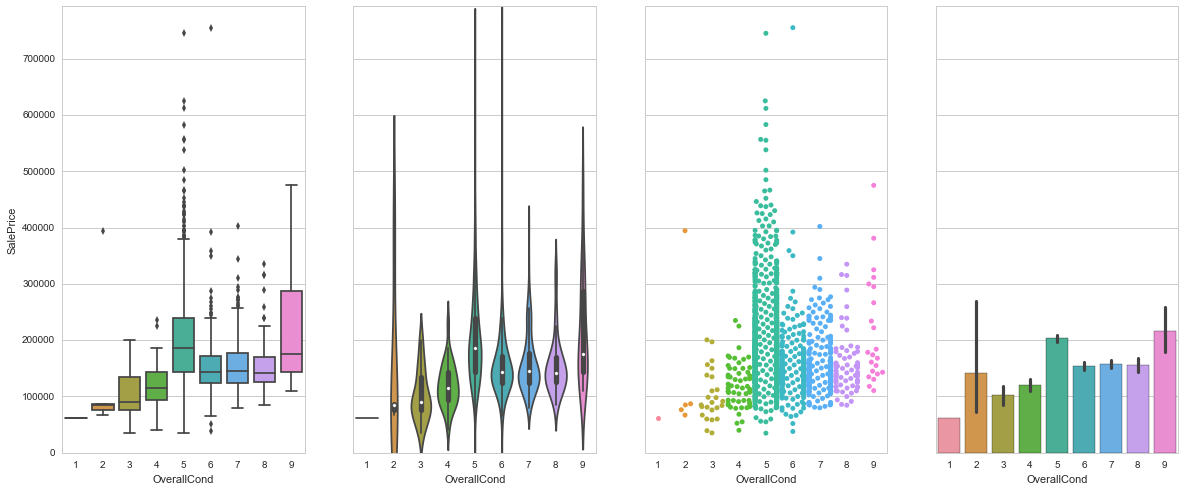

In [71]:
feature = 'OverallCond'
fig, axarr = plt.subplots(1,4,figsize =(20, 8),sharey=True)

# plot
#plt.subplot(1,4,1)
sns.boxplot(x=feature, y='SalePrice',data=train,ax=axarr[0])

# plot
#plt.subplot(1,4,2)
plot = sns.violinplot(x=feature, y='SalePrice',data=train, showmeans=False,
               showmedians=False,showextrema=False,ax=axarr[1])
axarr[1].set_ylabel("")

# plot
#plt.subplot(1,4,3)
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,ax=axarr[2])
axarr[2].set_ylabel("")

# purpose
#plt.subplot(1,4,4)
sns.barplot(x=feature, y='SalePrice',data=train,ax=axarr[3])
axarr[3].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

**COMMENT**
- As expected, the overall condition is correlated to the sale price. However, the class corresponding to a value of 5 has a higher average sale price than the class corresponding to the value 9. 

**YearRemodAdd**

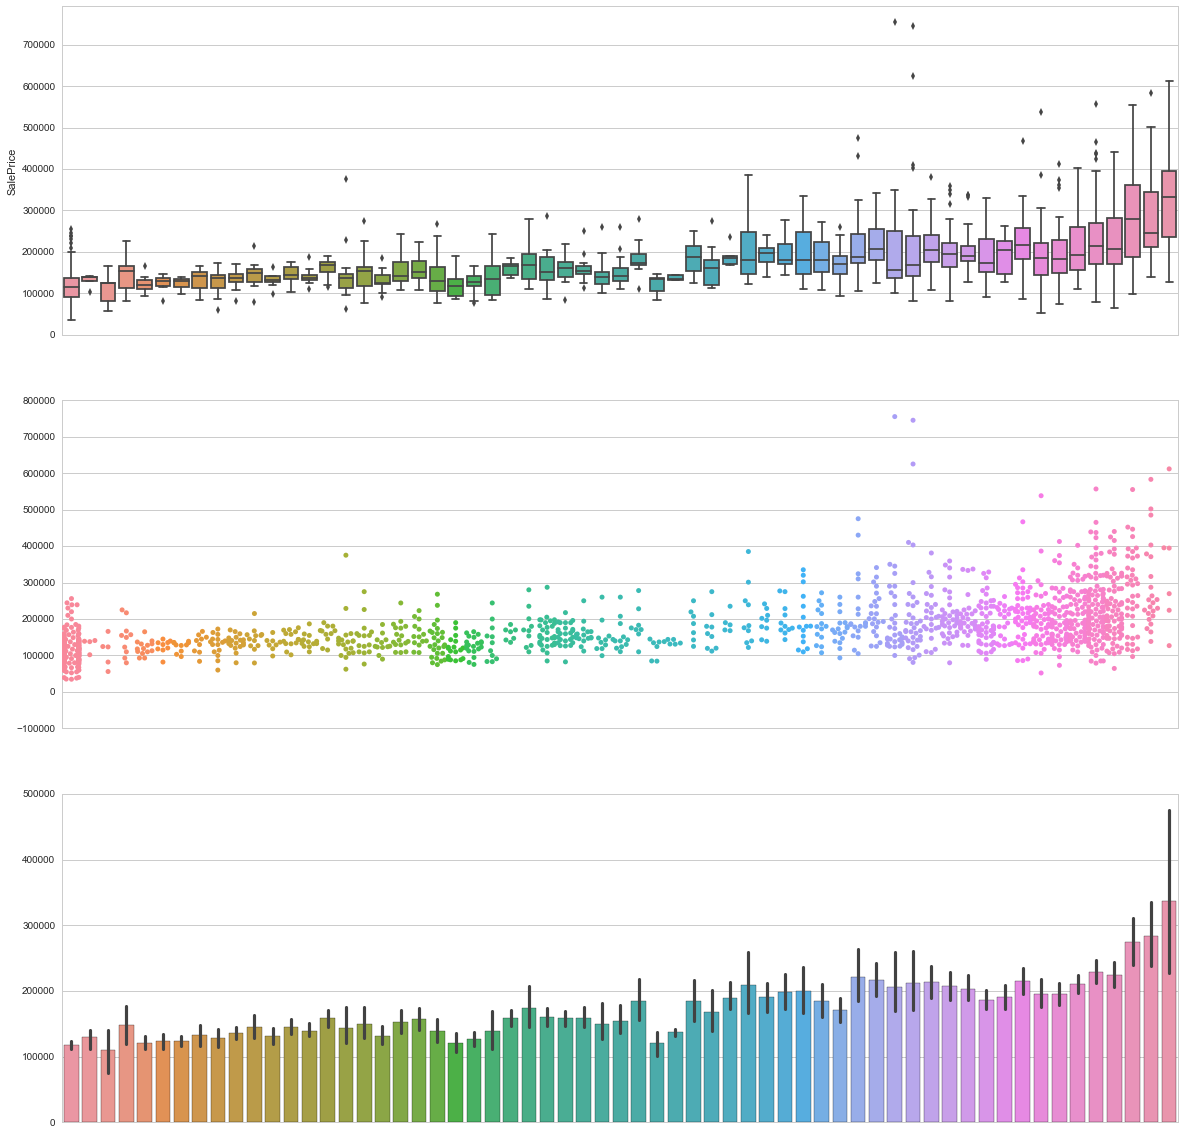

In [72]:
feature = 'YearRemodAdd'
fig, axarr = plt.subplots(3,1,figsize =(20, 20))

# plot
#plt.subplot(1,4,1)
sns.boxplot(x=feature, y='SalePrice',data=train,ax=axarr[0])
axarr[0].axes.get_xaxis().set_visible(False)

# plot
#plt.subplot(1,4,3)
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,ax=axarr[1])
axarr[1].set_ylabel("")
axarr[1].axes.get_xaxis().set_visible(False)

# purpose
#plt.subplot(1,4,4)
sns.barplot(x=feature, y='SalePrice',data=train,ax=axarr[2])
axarr[2].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05)
axarr[2].axes.get_xaxis().set_visible(False);

**COMMENT**
- The newer the remodeling the higher the sale price.

**YearBuilt**

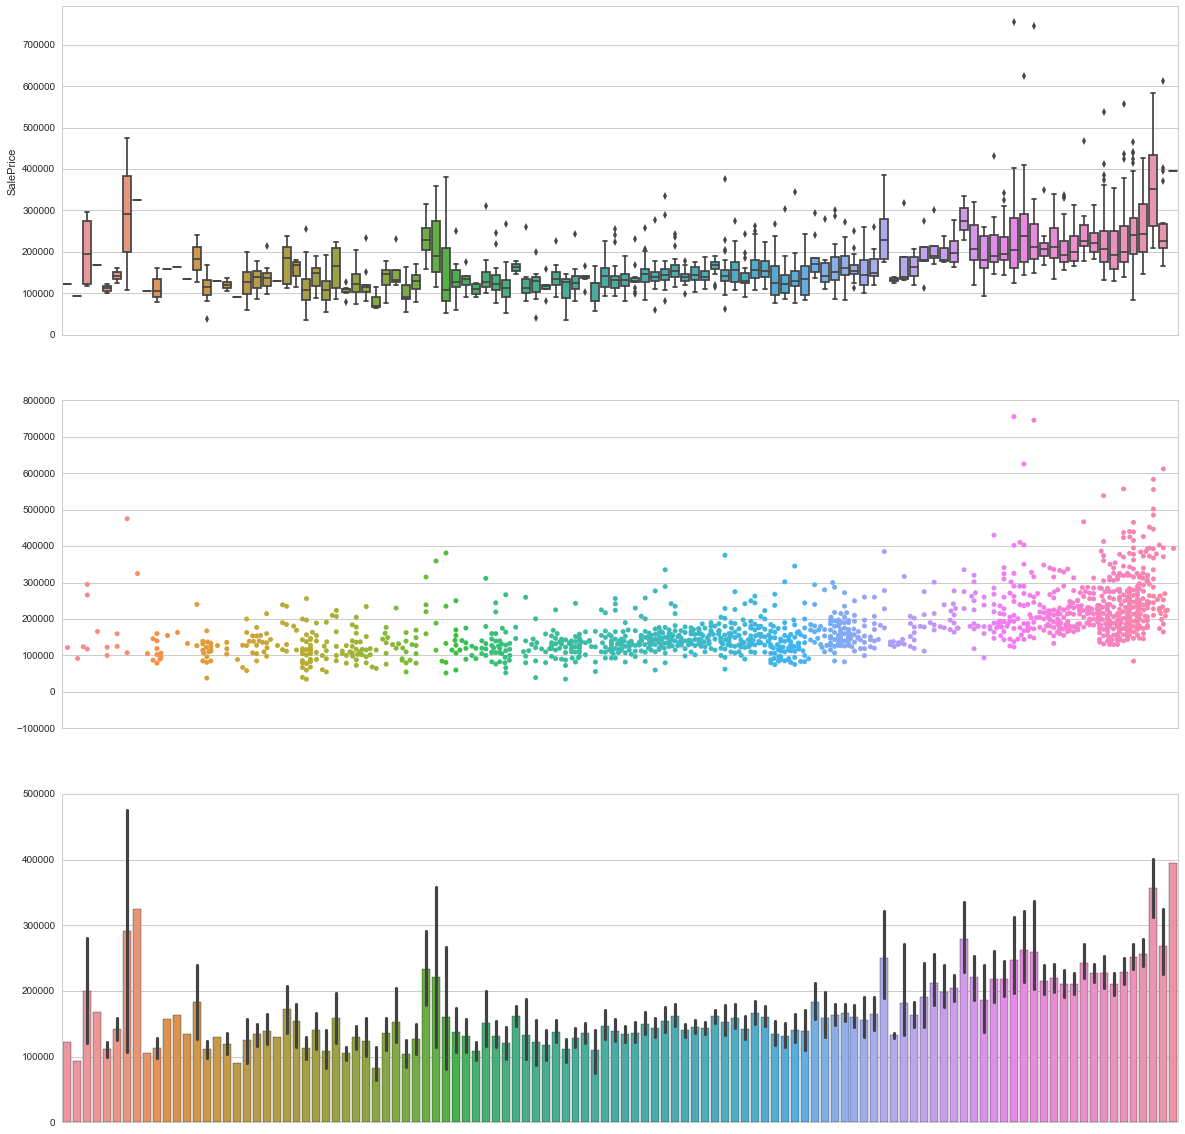

In [73]:
feature = 'YearBuilt'
fig, axarr = plt.subplots(3,1,figsize =(20, 20))

# plot
#plt.subplot(1,4,1)
plot = sns.boxplot(x=feature, y='SalePrice',data=train,ax=axarr[0])
axarr[0].axes.get_xaxis().set_visible(False)

# plot
#plt.subplot(1,4,3)
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,ax=axarr[1])
axarr[1].set_ylabel("")
axarr[1].axes.get_xaxis().set_visible(False)

# purpose
#plt.subplot(1,4,4)
sns.barplot(x=feature, y='SalePrice',data=train,ax=axarr[2])
axarr[2].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05)
axarr[2].axes.get_xaxis().set_visible(False);

**COMMENT**
- The general trend seems to depict a higher sale price for newer constructions.
- We bin the data

In [74]:
all_data['YearBuilt'] = pd.qcut(all_data['YearBuilt'],[0,0.20,0.40,0.60,0.80,1.0],range(1,6))
all_data['YearBuilt'].unique()

[4, 3, 1, 5, 2]
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [75]:
all_data = pd.get_dummies(all_data, columns = ["YearBuilt"], prefix="YearBuilt")

**Foundation**

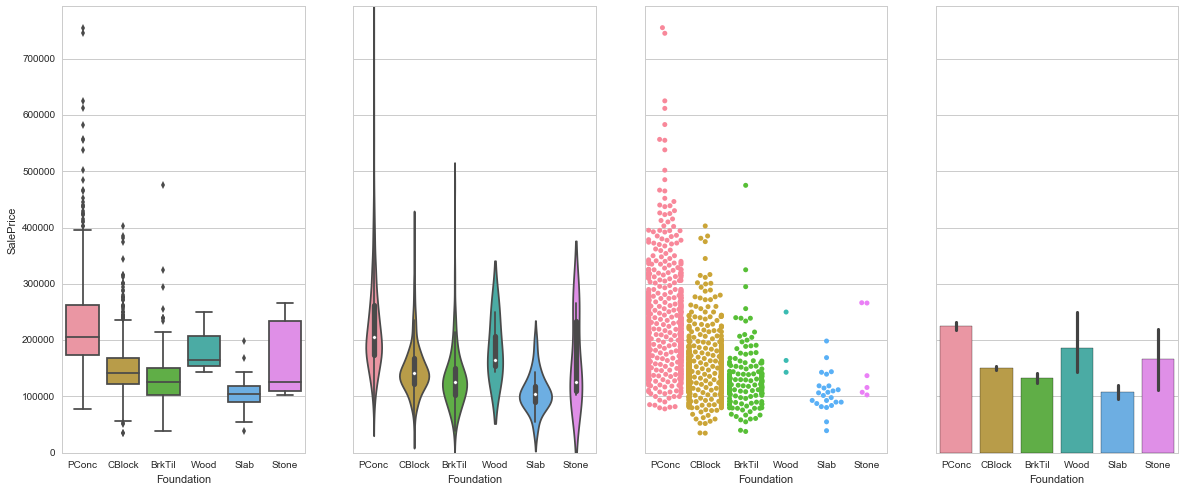

In [76]:
feature = 'Foundation'
fig, axarr = plt.subplots(1,4,figsize =(20, 8),sharey=True)

# plot
#plt.subplot(1,4,1)
sns.boxplot(x=feature, y='SalePrice',data=train,ax=axarr[0])

# plot
#plt.subplot(1,4,2)
plot = sns.violinplot(x=feature, y='SalePrice',data=train, showmeans=False,
               showmedians=False,showextrema=False,ax=axarr[1])
axarr[1].set_ylabel("")

# plot
#plt.subplot(1,4,3)
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,ax=axarr[2])
axarr[2].set_ylabel("")

# purpose
#plt.subplot(1,4,4)
sns.barplot(x=feature, y='SalePrice',data=train,ax=axarr[3])
axarr[3].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

**COMMENT**
- The data is mostly gathered into the first three classes.
  
We create dummies features.

In [77]:
all_data = pd.get_dummies(all_data, columns = ["Foundation"], prefix="Foundation")

**Functional**

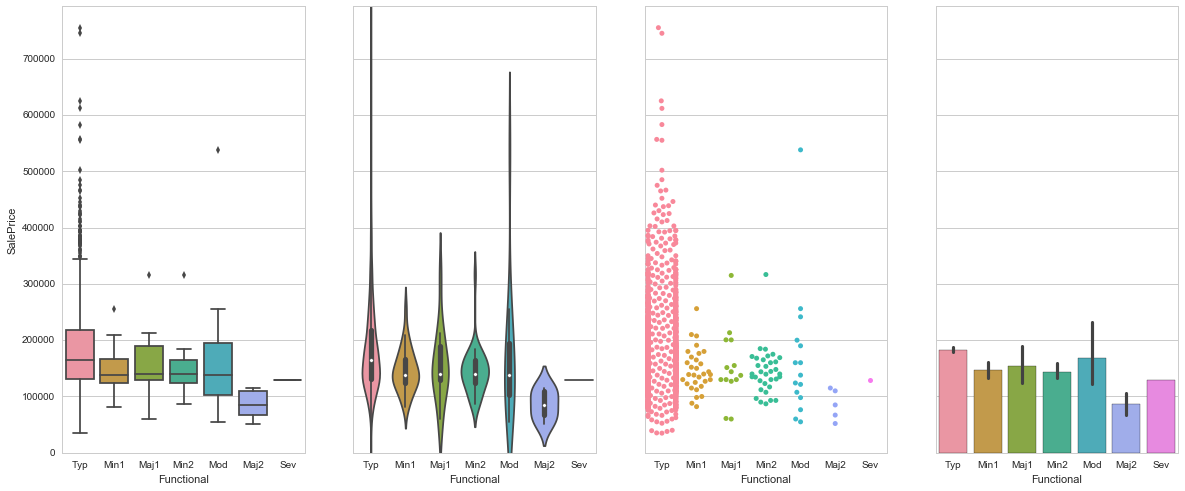

In [78]:
feature = 'Functional'
fig, axarr = plt.subplots(1,4,figsize =(20, 8),sharey=True)

# plot
#plt.subplot(1,4,1)
sns.boxplot(x=feature, y='SalePrice',data=train,ax=axarr[0])

# plot
#plt.subplot(1,4,2)
plot = sns.violinplot(x=feature, y='SalePrice',data=train, showmeans=False,
               showmedians=False,showextrema=False,ax=axarr[1])
axarr[1].set_ylabel("")

# plot
#plt.subplot(1,4,3)
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,ax=axarr[2])
axarr[2].set_ylabel("")

# purpose
#plt.subplot(1,4,4)
sns.barplot(x=feature, y='SalePrice',data=train,ax=axarr[3])
axarr[3].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

**COMMENT**
- Most of the data is stored under the "Typ" class.
- From the information about the dataset, we can identify an order with which the classes can be organized. The "Typ" class corresponds to the highest rank within this ordinal feature.

In [79]:
all_data['Functional'] = all_data['Functional'].map({"Sev":1, "Maj2":2, "Maj1":3, "Mod":4, "Min2":5, "Min1":6, "Typ":7})
all_data['Functional'].unique()

array([7, 6, 3, 5, 4, 2, 1])

**RoofStyle**

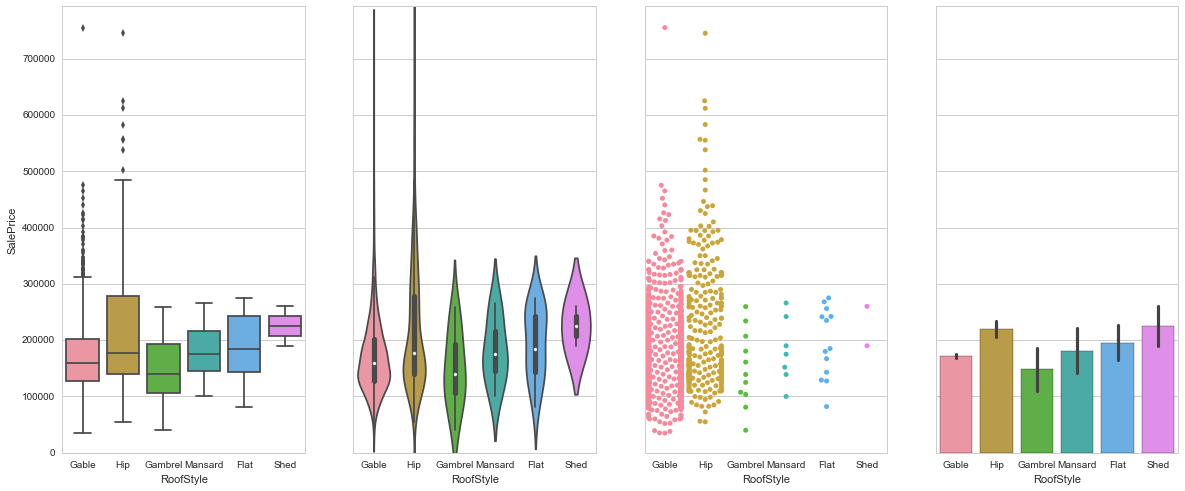

In [80]:
feature = 'RoofStyle'
fig, axarr = plt.subplots(1,4,figsize =(20, 8),sharey=True)

# plot
#plt.subplot(1,4,1)
sns.boxplot(x=feature, y='SalePrice',data=train,ax=axarr[0])

# plot
#plt.subplot(1,4,2)
plot = sns.violinplot(x=feature, y='SalePrice',data=train, showmeans=False,
               showmedians=False,showextrema=False,ax=axarr[1])
axarr[1].set_ylabel("")

# plot
#plt.subplot(1,4,3)
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,ax=axarr[2])
axarr[2].set_ylabel("")

# purpose
#plt.subplot(1,4,4)
sns.barplot(x=feature, y='SalePrice',data=train,ax=axarr[3])
axarr[3].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

**COMMENT**
- Most of the data is stored under the "Gable" and "Hip" classes.
- We create dummy variables to store the data.

In [81]:
all_data = pd.get_dummies(all_data, columns = ["RoofStyle"], prefix="RoofStyle")

**RoofMatl**

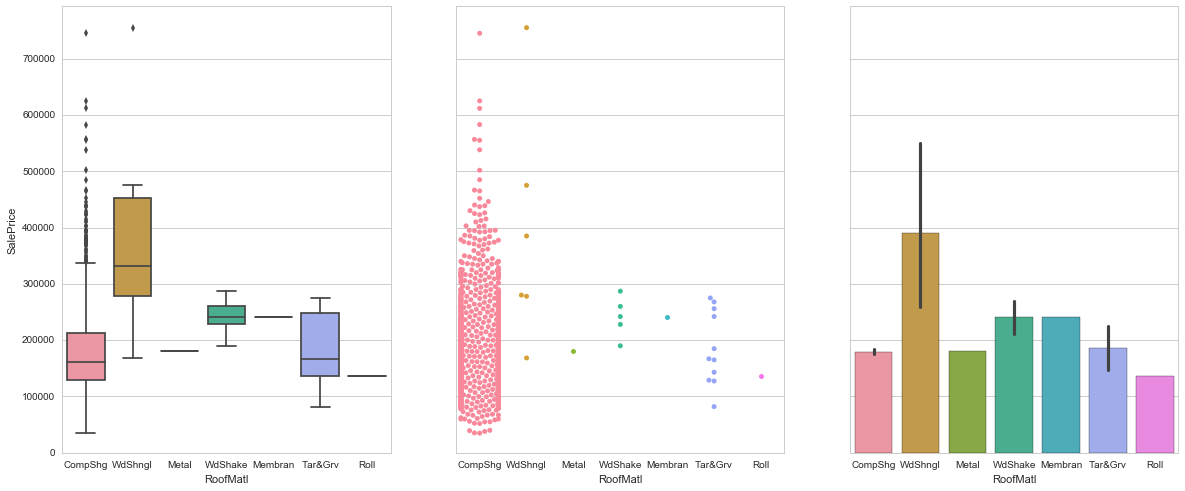

In [82]:
feature = 'RoofMatl'
fig, axarr = plt.subplots(1,3,figsize =(20, 8),sharey=True)

# plot
sns.boxplot(x=feature, y='SalePrice',data=train,ax=axarr[0])

# plot
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,ax=axarr[1])
axarr[1].set_ylabel("")

# purpose
sns.barplot(x=feature, y='SalePrice',data=train,ax=axarr[2])
axarr[2].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

**COMMENT**
- Almost the entiere dataset is stored under "CompShg" class.
- We create dummy variables to store the data.

In [83]:
all_data = pd.get_dummies(all_data, columns = ["RoofMatl"], prefix="RoofMatl")

**Exterior1st and Exterior2nd**
After inspection, it appears that most of the houses have the same class for the extrior features. We will use this to minimize the redundancy of the stored information.

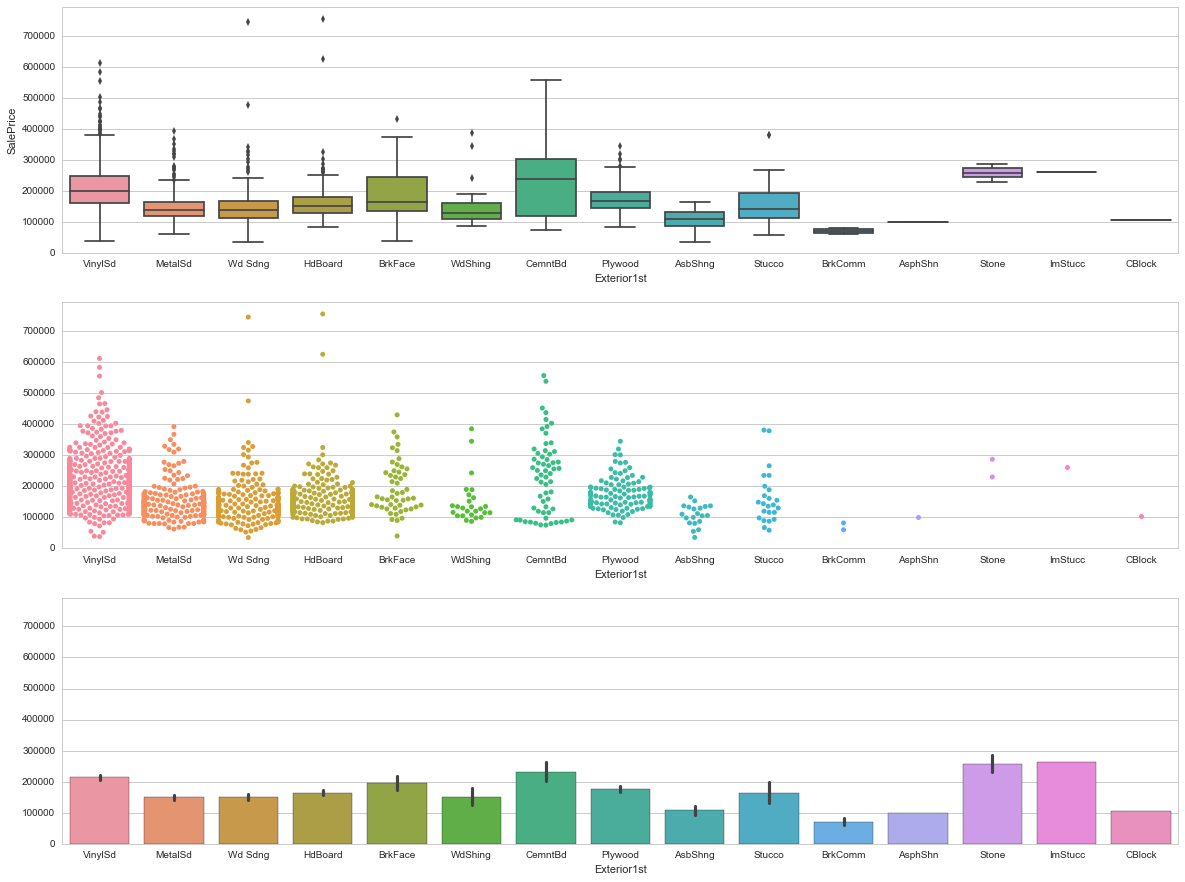

In [84]:
feature = 'Exterior1st'
fig, axarr = plt.subplots(3,1,figsize =(20, 15),sharey=True)

# plot
sns.boxplot(x=feature, y='SalePrice',data=train,ax=axarr[0])

# plot
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,ax=axarr[1])
axarr[1].set_ylabel("")

# purpose
sns.barplot(x=feature, y='SalePrice',data=train,ax=axarr[2])
axarr[2].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

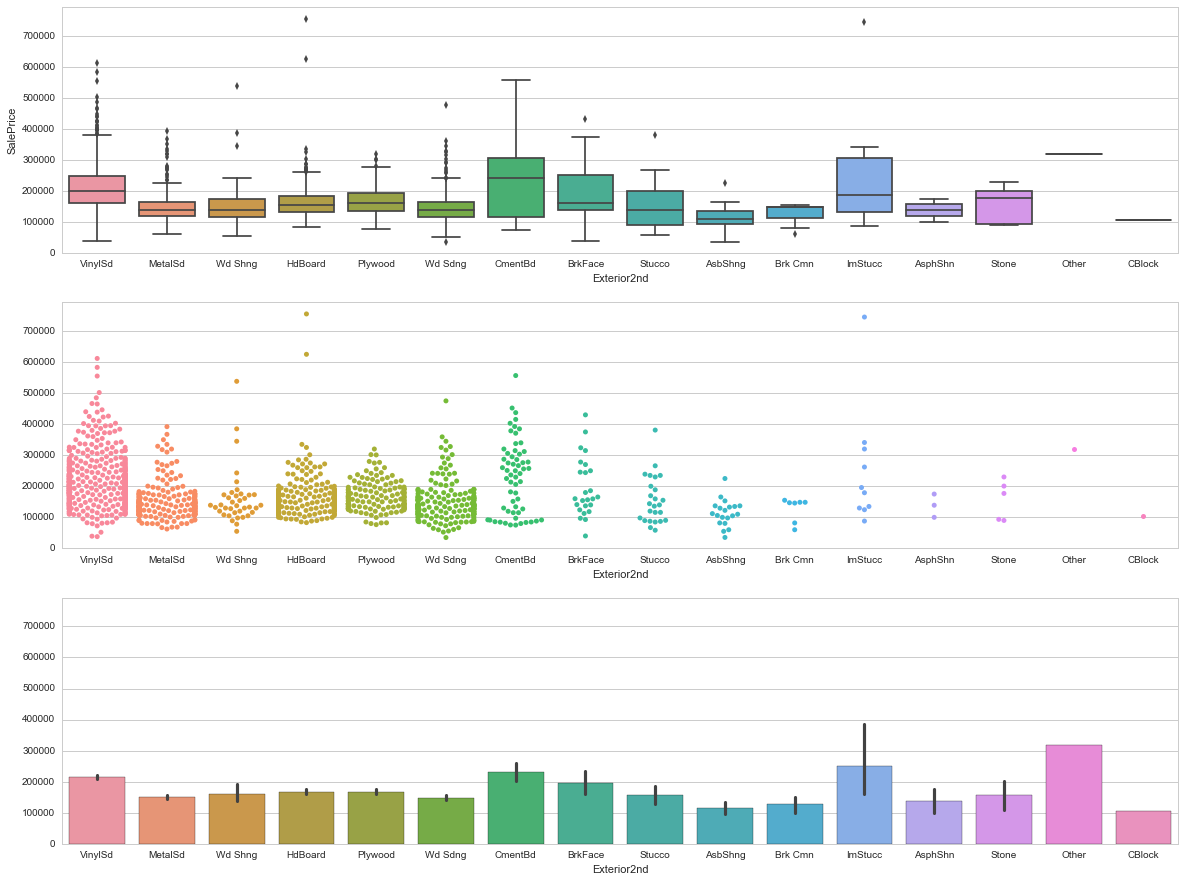

In [85]:
feature = 'Exterior2nd'
fig, axarr = plt.subplots(3,1,figsize =(20, 15),sharey=True)

# plot
sns.boxplot(x=feature, y='SalePrice',data=train,ax=axarr[0])

# plot
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,ax=axarr[1])
axarr[1].set_ylabel("")

# purpose
sns.barplot(x=feature, y='SalePrice',data=train,ax=axarr[2])
axarr[2].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

**COMMMENT**
- Most records have the save value for both exterior features.

In [86]:
def SameExt(row):
    if row['Exterior1st'] == row['Exterior2nd']:
        return 1
    else:
        return 0

all_data['SameExterior_flag'] = all_data.apply(SameExt,axis=1)
all_data[['Exterior1st','Exterior2nd','SameExterior_flag']].head()
all_data = pd.get_dummies(all_data, columns = ["Exterior1st"], prefix="Exterior1st")

In [87]:
all_data.drop('Exterior2nd', axis=1, inplace=True)

**MasVnrType**

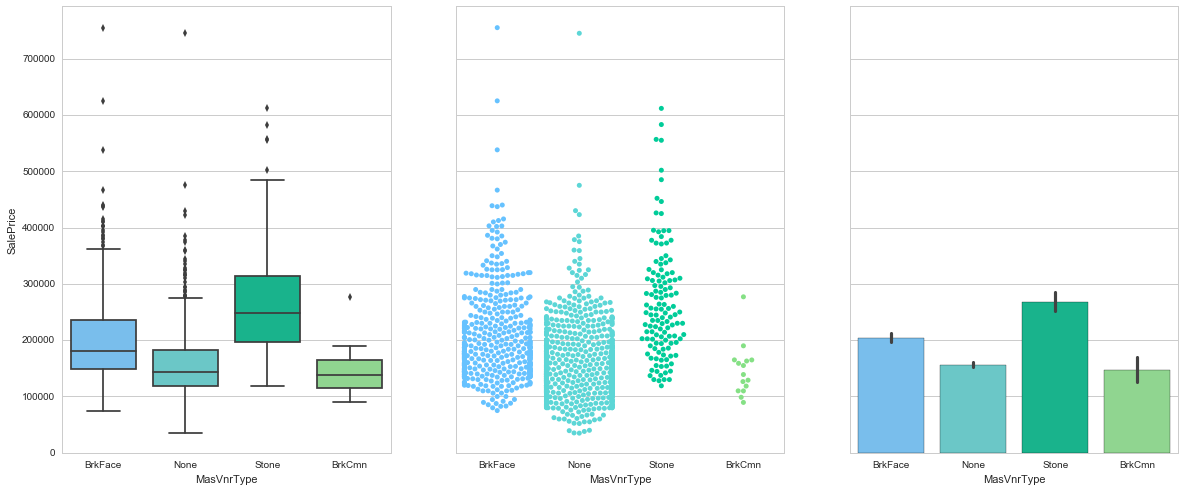

In [88]:
feature = 'MasVnrType'
fig, axarr = plt.subplots(1,3,figsize =(20, 8),sharey=True)

# plot
sns.boxplot(x=feature, y='SalePrice',data=train,ax=axarr[0])

# plot
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,ax=axarr[1])
axarr[1].set_ylabel("")

# purpose
sns.barplot(x=feature, y='SalePrice',data=train,ax=axarr[2])
axarr[2].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

**COMMENT*
- Each class leads to a different average sale price.
- Most of the data is stored in the first three classes.
  
We store the data into four dummy features.

In [89]:
all_data = pd.get_dummies(all_data, columns = ["MasVnrType"], prefix="MasVnrType")

**MasVnrArea**

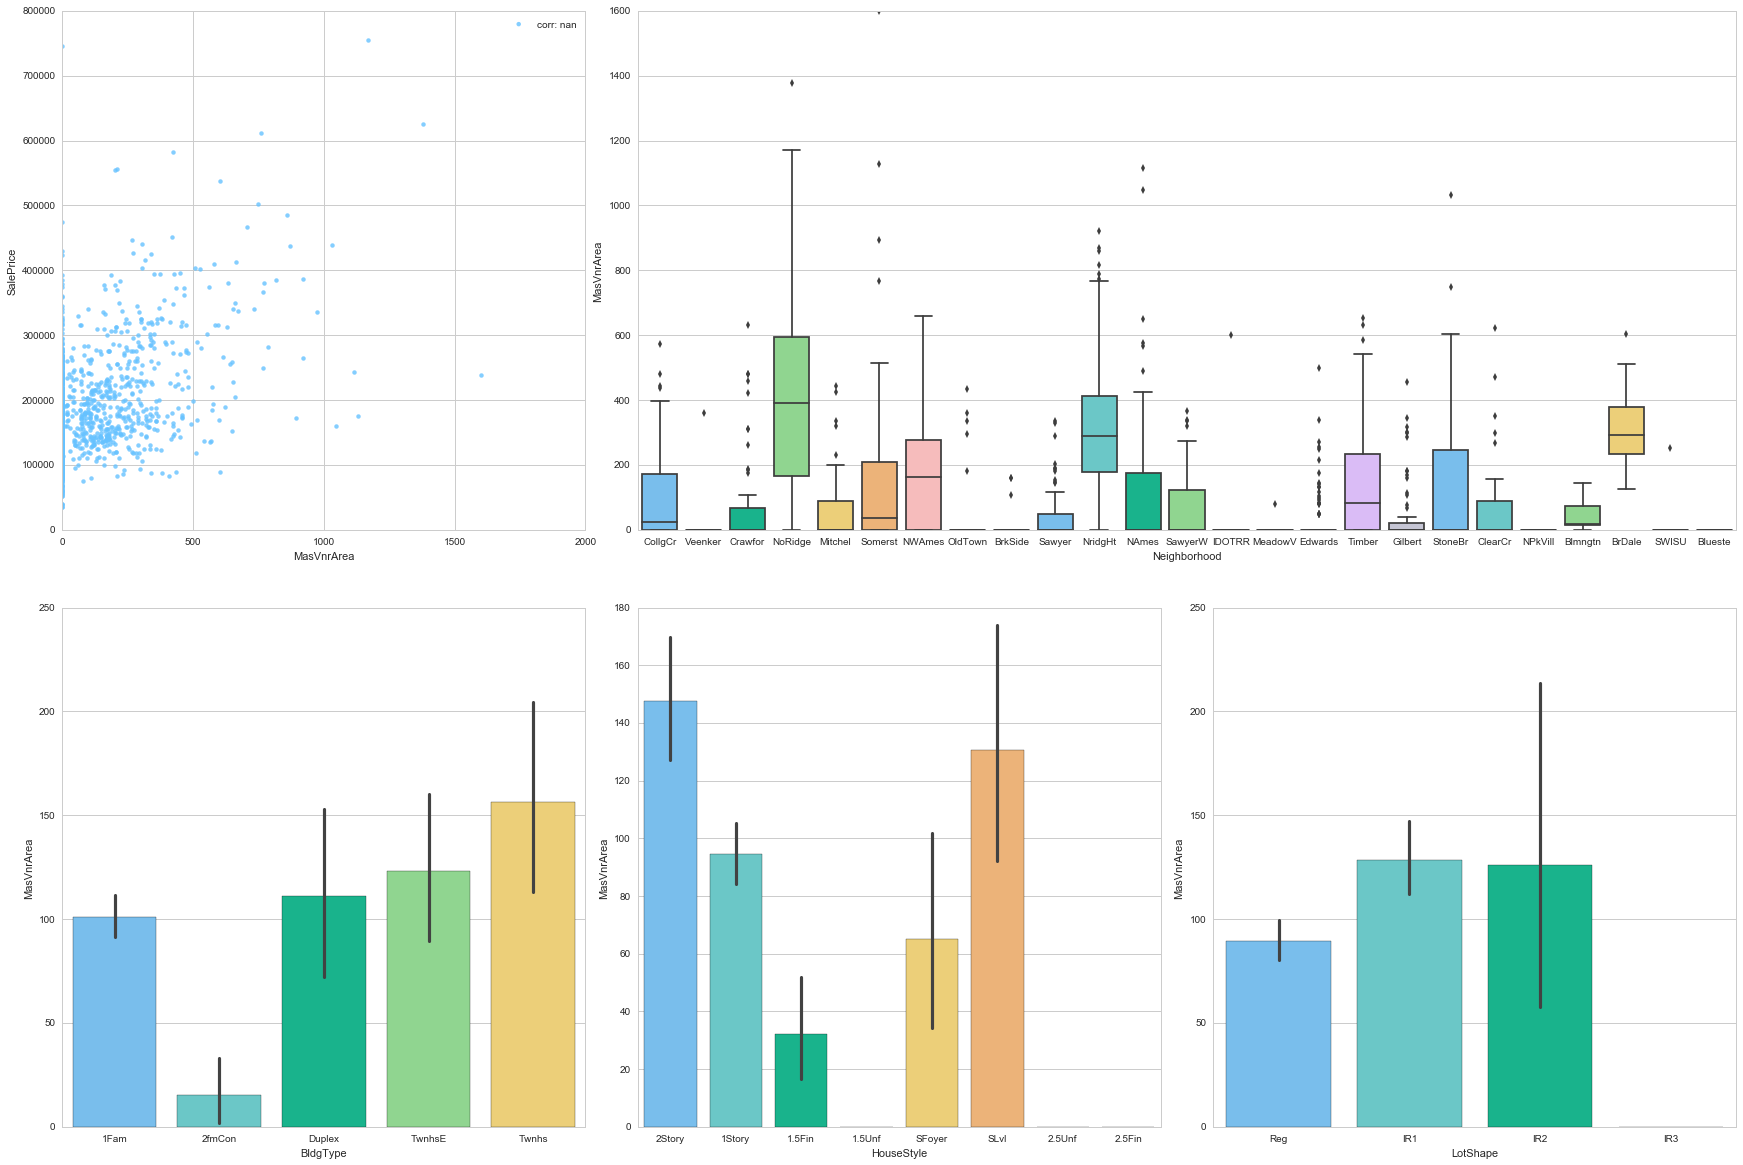

In [90]:
feature = 'MasVnrArea'
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 20))

# plot
plt.subplot(grid[0, 0])
g = sns.regplot(x=train[feature], y=train['SalePrice'], fit_reg=False,
                label = "corr: %2f"%(pearsonr(train[feature], train['SalePrice'])[0]))
g = g.legend(loc="best")
g.axes.set_xlim(0,)
g.axes.set_ylim(0,)

# plot
plt.subplot(grid[0, 1:])
sns.boxplot(x='Neighborhood', y=feature, data=train, palette = mycols)

# plot
plt.subplot(grid[1, 0]);
sns.barplot(x='BldgType', y=feature, data=train, palette = mycols)

# plot
plt.subplot(grid[1, 1]);
sns.barplot(x='HouseStyle', y=feature, data=train, palette = mycols)

# plot
plt.subplot(grid[1, 2]);
sns.barplot(x='LotShape', y=feature, data=train, palette = mycols);

**COMMENT**
- There is no clear correlation between this feature and the sale price.
- Most of the data is assigned a value of 0.
  
For simplicity, this feature is dropped.

In [91]:
all_data.drop('MasVnrArea', axis=1, inplace=True)

**ExterQual**

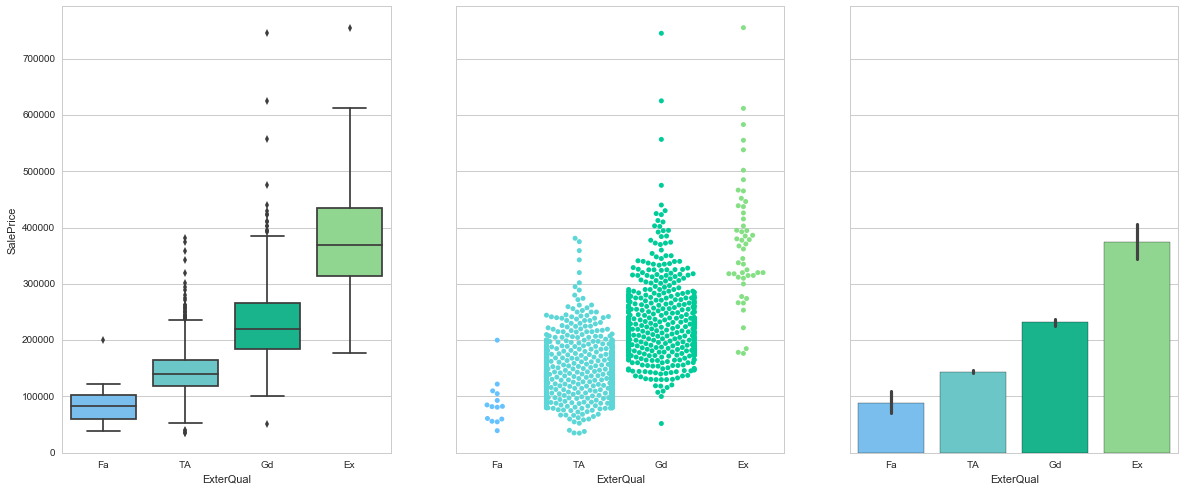

In [92]:
feature = 'ExterQual'
order = ['Fa', 'TA', 'Gd', 'Ex']
fig, axarr = plt.subplots(1,3,figsize =(20, 8),sharey=True)

# plot
sns.boxplot(x=feature, y='SalePrice',data=train,ax=axarr[0],order=order)

# plot
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,ax=axarr[1],order=order)
axarr[1].set_ylabel("")

# purpose
sns.barplot(x=feature, y='SalePrice',data=train,ax=axarr[2],order=order)
axarr[2].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

**COMMENT**
- This is an ordinal feature. The classes are arrange to create an increase in sale price from one feature to another.
- We convert this feature into a numerical feature.
- Most of the data is stored in the two central classes.

In [93]:
all_data['ExterQual'] = all_data['ExterQual'].map({"None":0, "Fa":1, "TA":2, "Gd":3, "Ex":4})
all_data['ExterQual'].unique()

array([3, 2, 4, 1])

**ExterCond**

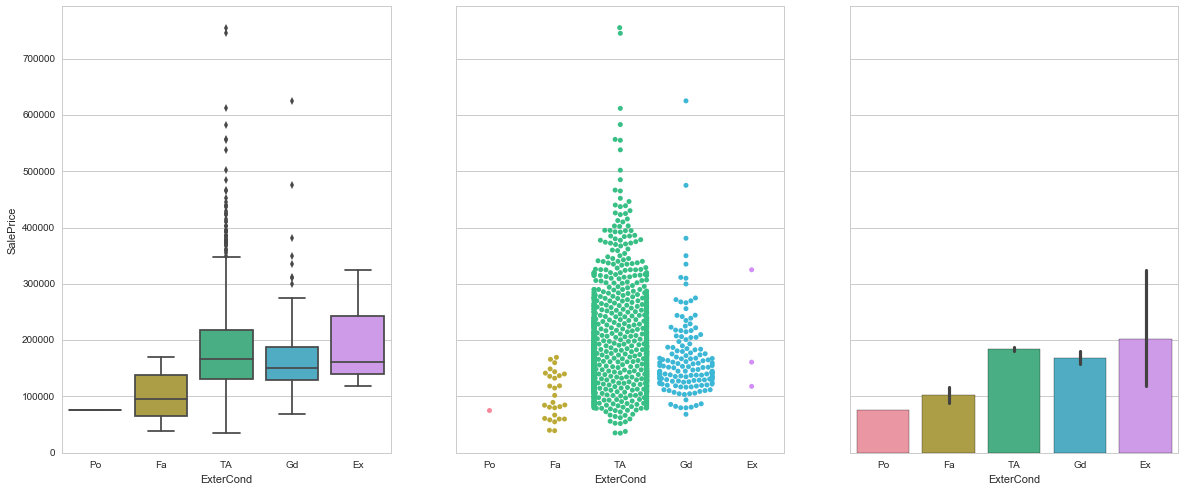

In [94]:
feature = 'ExterCond'
order = ['Po','Fa','TA','Gd', 'Ex']
fig, axarr = plt.subplots(1,3,figsize =(20, 8),sharey=True)

# plot
sns.boxplot(x=feature, y='SalePrice',data=train,ax=axarr[0],order=order)

# plot
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,ax=axarr[1],order=order)
axarr[1].set_ylabel("")

# purpose
sns.barplot(x=feature, y='SalePrice',data=train,ax=axarr[2],order=order)
axarr[2].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

**COMMENT**
- This is an ordinal feature but the sale price does not reflect the feature order.
- We create dummy features to bin the data.
- Most of the data is stored in the two central classes.

In [95]:
all_data = pd.get_dummies(all_data, columns = ["ExterCond"], prefix="ExterCond")

**GarageType**

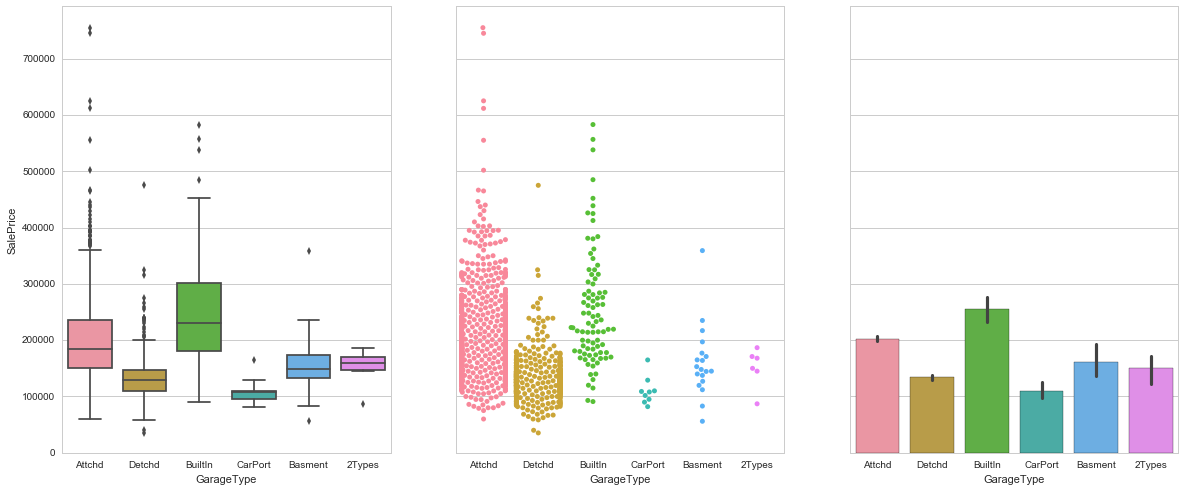

In [96]:
feature = 'GarageType'
fig, axarr = plt.subplots(1,3,figsize =(20, 8),sharey=True)

# plot
sns.boxplot(x=feature, y='SalePrice',data=train,ax=axarr[0])

# plot
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,ax=axarr[1])
axarr[1].set_ylabel("")

# purpose
sns.barplot(x=feature, y='SalePrice',data=train,ax=axarr[2])
axarr[2].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

**COMMENT**
- There is no real order within this categorical feature.
- We bin the data in dummy features.

In [97]:
all_data = pd.get_dummies(all_data, columns = ["GarageType"], prefix="GarageType")

**GarageYrBlt**

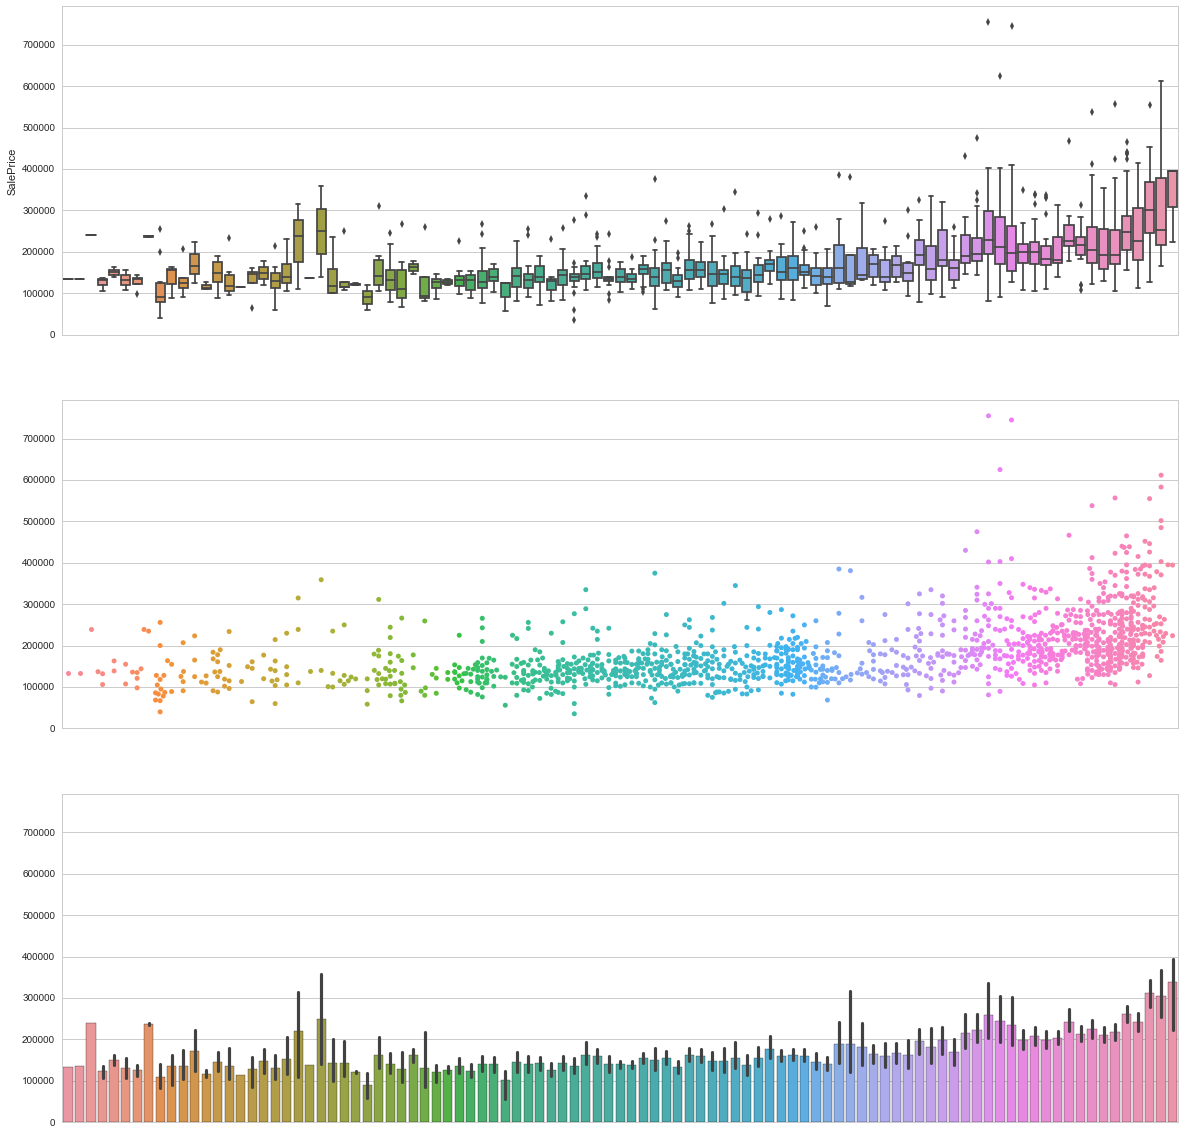

In [98]:
feature = 'GarageYrBlt'
fig, axarr = plt.subplots(3,1,figsize =(20, 20))

# plot
#plt.subplot(1,4,1)
plot = sns.boxplot(x=feature, y='SalePrice',data=train,ax=axarr[0])
axarr[0].axes.get_xaxis().set_visible(False)

# plot
#plt.subplot(1,4,3)
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,ax=axarr[1])
axarr[1].set_ylabel("")
axarr[1].axes.get_xaxis().set_visible(False)

# purpose
#plt.subplot(1,4,4)
sns.barplot(x=feature, y='SalePrice',data=train,ax=axarr[2])
axarr[2].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05)
axarr[1].set_ylim(0,train['SalePrice'].max()*1.05)
axarr[2].set_ylim(0,train['SalePrice'].max()*1.05)
axarr[2].axes.get_xaxis().set_visible(False);

**COMMENT**
- For recent constructions, it seems that there is an upward trend. For older constructions, the average sale price seems to be fairly constant.
- We bin the data

In [99]:
all_data['GarageYrBlt'] = pd.qcut(all_data['GarageYrBlt'],[0,0.40,0.50,0.75,1],range(1,5))
all_data['GarageYrBlt'].unique()

[4, 2, 3, 1]
Categories (4, int64): [1 < 2 < 3 < 4]

In [100]:
all_data = pd.get_dummies(all_data, columns = ["GarageYrBlt"], prefix="GarageYrBlt")

**GarageFinish**

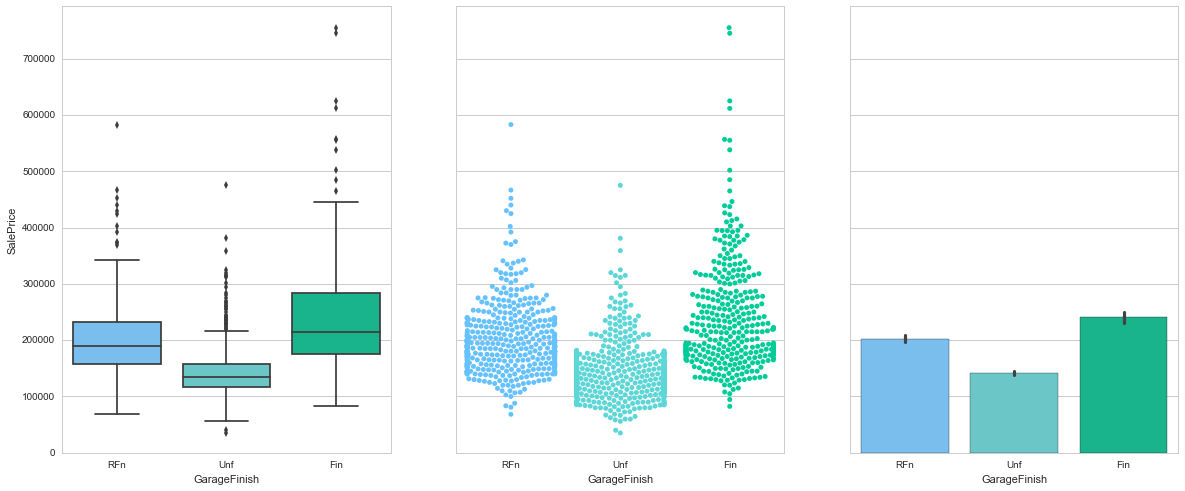

In [101]:
feature = 'GarageFinish'
fig, axarr = plt.subplots(1,3,figsize =(20, 8),sharey=True)

# plot
sns.boxplot(x=feature, y='SalePrice',data=train,ax=axarr[0])

# plot
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,ax=axarr[1])
axarr[1].set_ylabel("")

# purpose
sns.barplot(x=feature, y='SalePrice',data=train,ax=axarr[2])
axarr[2].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

**COMMENT**
- The data is evenly distributed amongst the three classes.
- We use dummy features since there is no clear order between the sale prices.

In [102]:
all_data = pd.get_dummies(all_data, columns = ["GarageFinish"], prefix="GarageFinish")

**GarageCars**

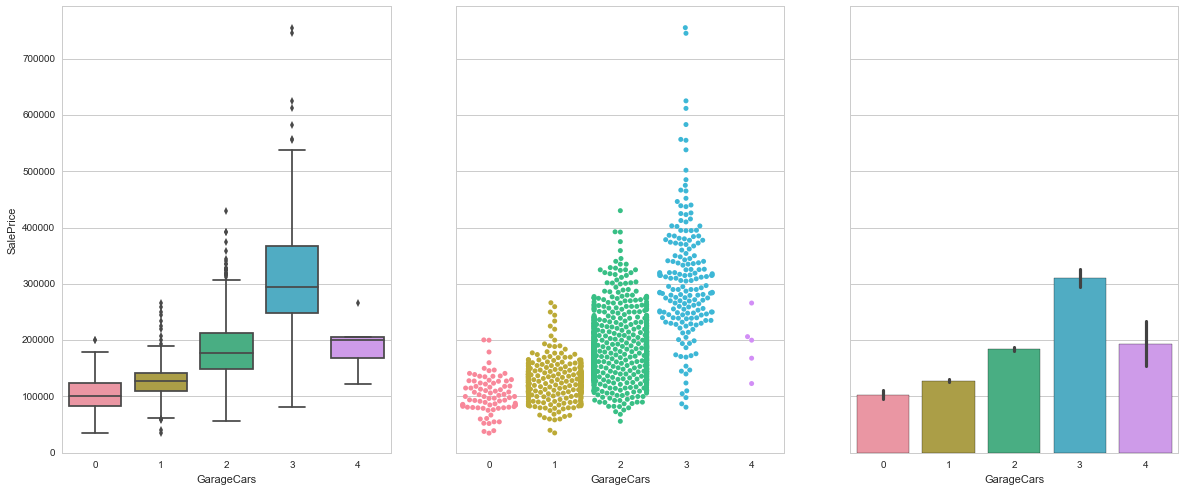

In [103]:
feature = 'GarageCars'
fig, axarr = plt.subplots(1,3,figsize =(20, 8),sharey=True)

# plot
sns.boxplot(x=feature, y='SalePrice',data=train,ax=axarr[0])

# plot
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,ax=axarr[1])
axarr[1].set_ylabel("")

# purpose
sns.barplot(x=feature, y='SalePrice',data=train,ax=axarr[2])
axarr[2].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

**COMMENT**
- There is a clear increase in sale price from class 0 to class 3. However, class 4 does not follow this trend. This can be explained by the low number of records with 4 car spaces.
- For this reason, we keep the data as is.

**GarageArea**

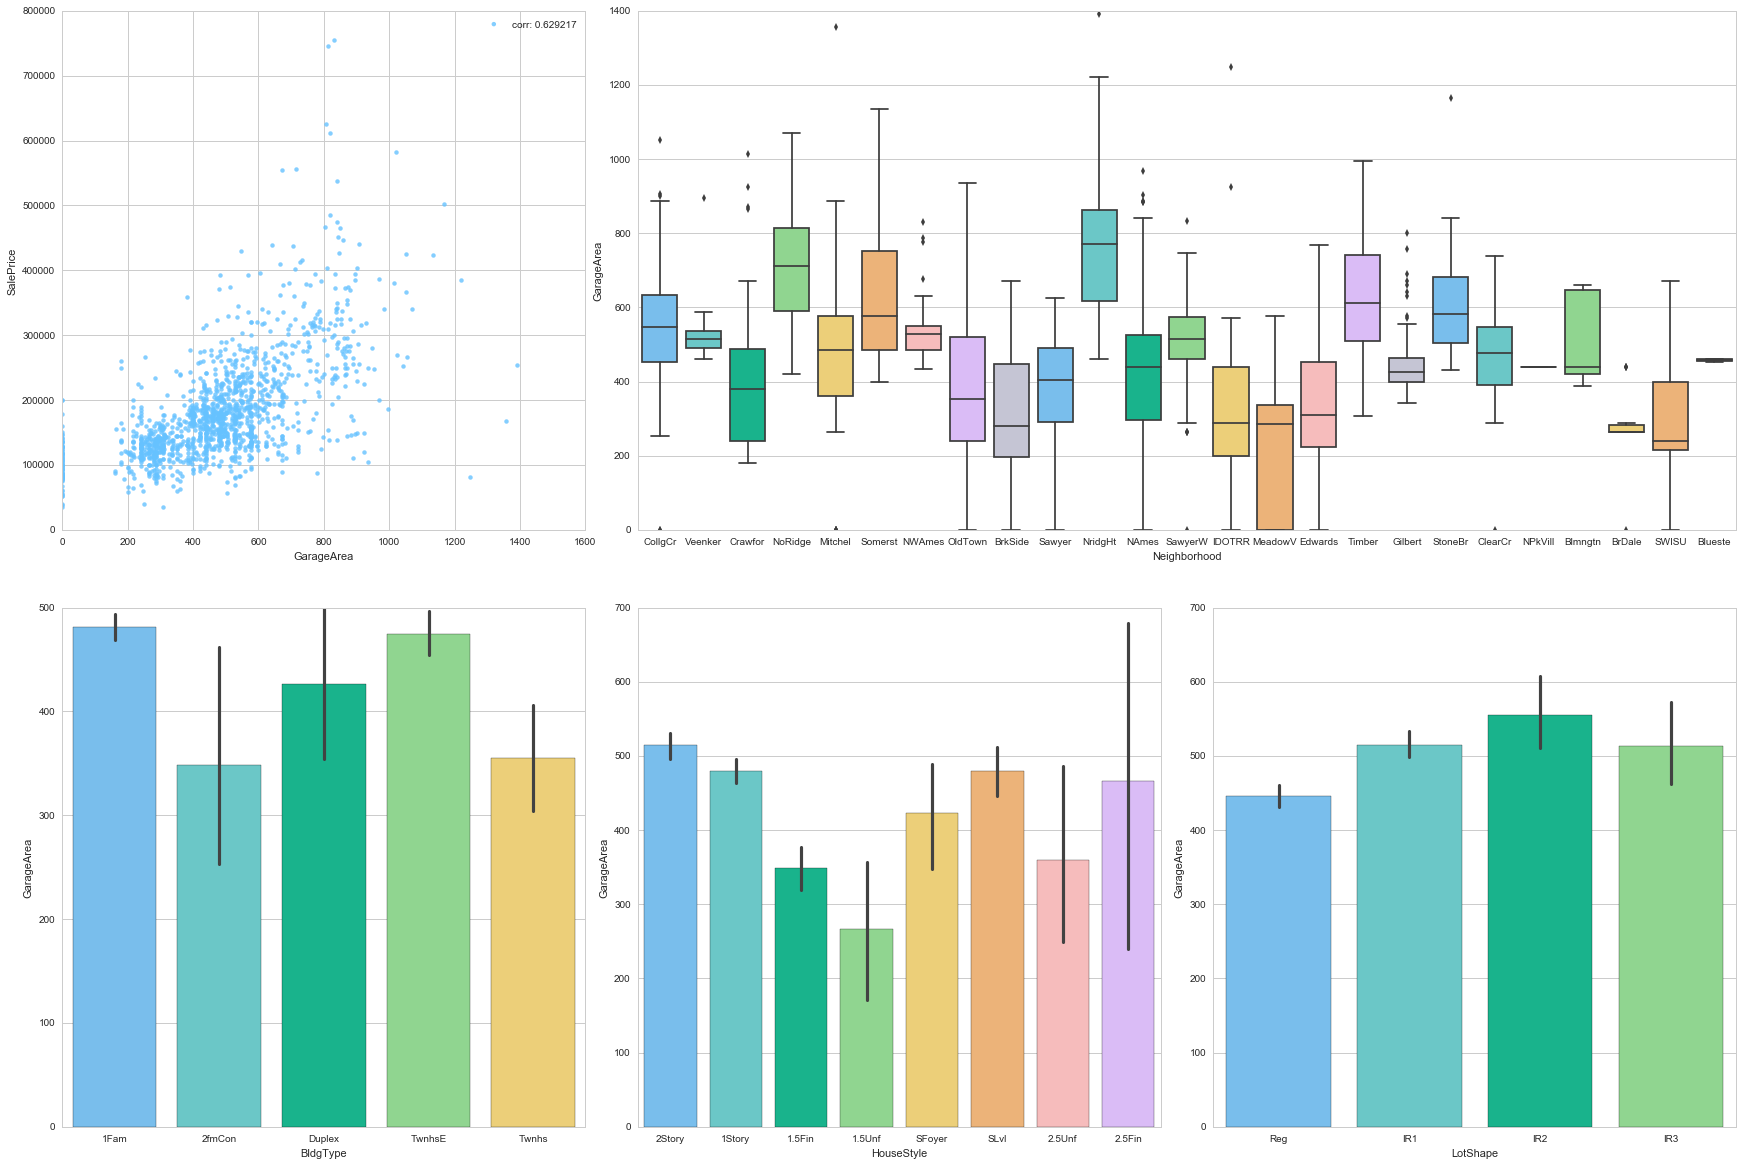

In [104]:
feature = 'GarageArea'
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 20))

# plot
plt.subplot(grid[0, 0])
g = sns.regplot(x=train[feature], y=train['SalePrice'], fit_reg=False,
                label = "corr: %2f"%(pearsonr(train[feature], train['SalePrice'])[0]))
g = g.legend(loc="best")
g.axes.set_xlim(0,)
g.axes.set_ylim(0,)

# plot
plt.subplot(grid[0, 1:])
sns.boxplot(x='Neighborhood', y=feature, data=train, palette = mycols)

# plot
plt.subplot(grid[1, 0]);
sns.barplot(x='BldgType', y=feature, data=train, palette = mycols)

# plot
plt.subplot(grid[1, 1]);
sns.barplot(x='HouseStyle', y=feature, data=train, palette = mycols)

# plot
plt.subplot(grid[1, 2]);
sns.barplot(x='LotShape', y=feature, data=train, palette = mycols);

**COMMENT**
- The sale price is strongly correlated to this feature (positive correlation).
- There is a high variation of this feature when looking at the neighborhoods.
  
We bin the data.

In [105]:
all_data['GarageArea'] = pd.qcut(all_data['GarageArea'],[0,0.20,0.40,0.60,0.80,1.0],range(1,6))
all_data['GarageArea'].unique()

[4, 3, 5, 1, 2]
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [106]:
all_data = pd.get_dummies(all_data, columns = ["GarageArea"], prefix="GarageArea")

**GarageQual**

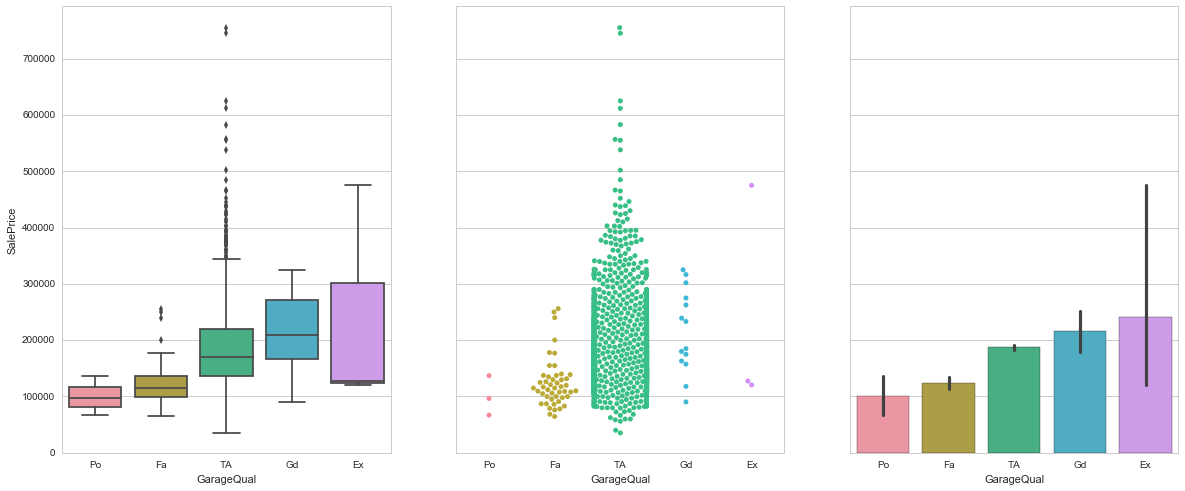

In [107]:
feature = 'GarageQual'
order=["Po", "Fa", "TA", "Gd", "Ex"]
fig, axarr = plt.subplots(1,3,figsize =(20, 8),sharey=True)

# plot
sns.boxplot(x=feature, y='SalePrice',data=train,ax=axarr[0],order=order)

# plot
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,ax=axarr[1],order=order)
axarr[1].set_ylabel("")

# purpose
sns.barplot(x=feature, y='SalePrice',data=train,ax=axarr[2],order=order)
axarr[2].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

**COMMENT**
- We found a sequence that leads to an increase in sale price. Only the Ex feature does not really match the ranking but the small number of Ex records is the reason for such a behavior.
- Because of the small number of records in the Po and Ex classes, we merge the Po class with the Fa class and the Ex class with the Gd class.

In [108]:
all_data['GarageQual'] = all_data['GarageQual'].map({"None":"None", "Po":"Low", "Fa":"Low", "TA":"TA", "Gd":"High", "Ex":"High"})
all_data['GarageQual'].unique()

array(['TA', 'Low', 'High', 'None'], dtype=object)

In [109]:
all_data = pd.get_dummies(all_data, columns = ["GarageQual"], prefix="GarageQual")

**GarageCond**

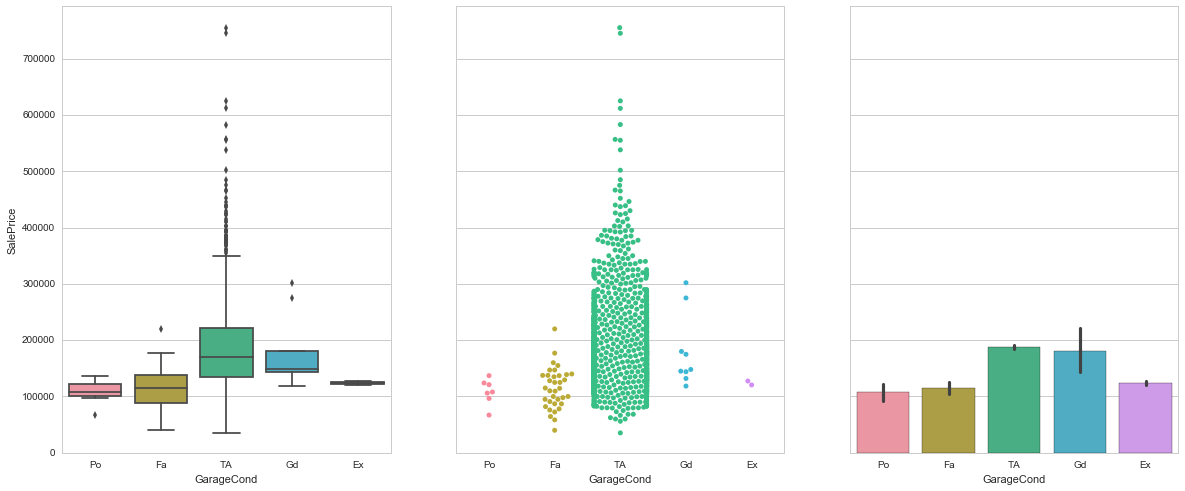

In [110]:
feature = 'GarageCond'
order=["Po", "Fa", "TA", "Gd", "Ex"]
fig, axarr = plt.subplots(1,3,figsize =(20, 8),sharey=True)

# plot
sns.boxplot(x=feature, y='SalePrice',data=train,ax=axarr[0],order=order)

# plot
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,ax=axarr[1],order=order)
axarr[1].set_ylabel("")

# purpose
sns.barplot(x=feature, y='SalePrice',data=train,ax=axarr[2],order=order)
axarr[2].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

**COMMENT**
- The observations made on the previous feature are still valid. We apply the same mapping.

In [111]:
all_data['GarageCond'] = all_data['GarageCond'].map({"None":"None", "Po":"Low", "Fa":"Low", "TA":"TA", "Gd":"High", "Ex":"High"})
all_data['GarageCond'].unique()

array(['TA', 'Low', 'None', 'High'], dtype=object)

In [112]:
all_data = pd.get_dummies(all_data, columns = ["GarageCond"], prefix="GarageCond")

**WoodDeckSF**

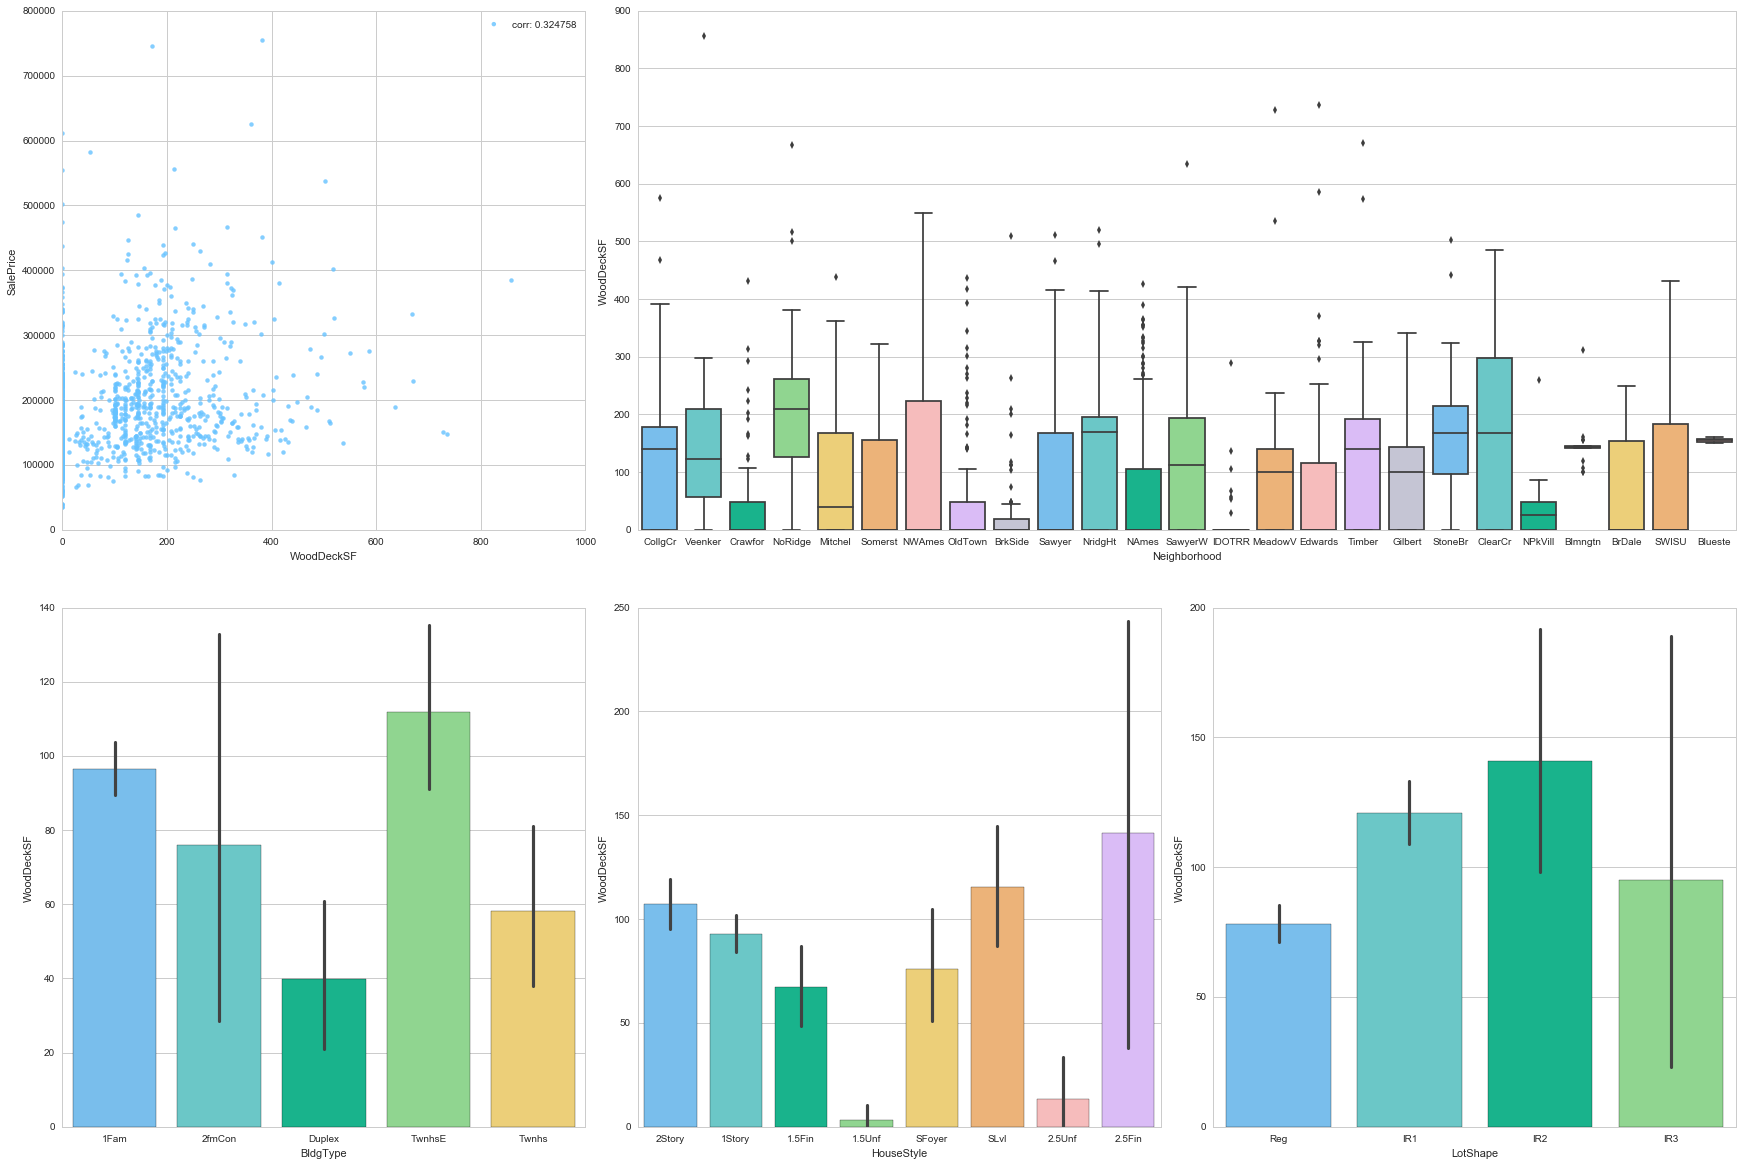

In [113]:
feature = 'WoodDeckSF'
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 20))

# plot
plt.subplot(grid[0, 0])
g = sns.regplot(x=train[feature], y=train['SalePrice'], fit_reg=False,
                label = "corr: %2f"%(pearsonr(train[feature], train['SalePrice'])[0]))
g = g.legend(loc="best")
g.axes.set_xlim(0,)
g.axes.set_ylim(0,)

# plot
plt.subplot(grid[0, 1:])
sns.boxplot(x='Neighborhood', y=feature, data=train, palette = mycols)

# plot
plt.subplot(grid[1, 0]);
sns.barplot(x='BldgType', y=feature, data=train, palette = mycols)

# plot
plt.subplot(grid[1, 1]);
sns.barplot(x='HouseStyle', y=feature, data=train, palette = mycols)

# plot
plt.subplot(grid[1, 2]);
sns.barplot(x='LotShape', y=feature, data=train, palette = mycols);

**COMMENT**
- There is a good positive correlation between the sale price and this feature..
- The neighborhood and location feature have a great impact on this feature.
- A large number of data points are assigned the value 0.


In [114]:
def NoWoodDeck(col):
    if col['WoodDeckSF'] == 0:
        return 1
    else:
        return 0
    
all_data['NoWoodDeck_Flag'] = all_data.apply(NoWoodDeck, axis=1)

In [115]:
all_data['WoodDeckSF'] = pd.qcut(all_data['WoodDeckSF'],[0,0.55,0.60,0.70,0.80,0.90,1.0],range(1,7))
all_data['WoodDeckSF'].unique()

[1, 6, 4, 5, 2, 3]
Categories (6, int64): [1 < 2 < 3 < 4 < 5 < 6]

In [116]:
all_data = pd.get_dummies(all_data, columns = ["WoodDeckSF"], prefix="WoodDeckSF")

**OpenPorchSF, EnclosedPorch, 3SsnPorch & ScreenPorch**
  
Similar to the sum of the bathroom areas, we sum the porch areas.

In [117]:
all_data['TotalPorchSF'] = all_data['OpenPorchSF'] + all_data['OpenPorchSF'] + \
    all_data['EnclosedPorch'] + all_data['3SsnPorch'] + all_data['ScreenPorch'] 
train['TotalPorchSF'] = train['OpenPorchSF'] + train['OpenPorchSF'] + \
    train['EnclosedPorch'] + train['3SsnPorch'] + train['ScreenPorch']

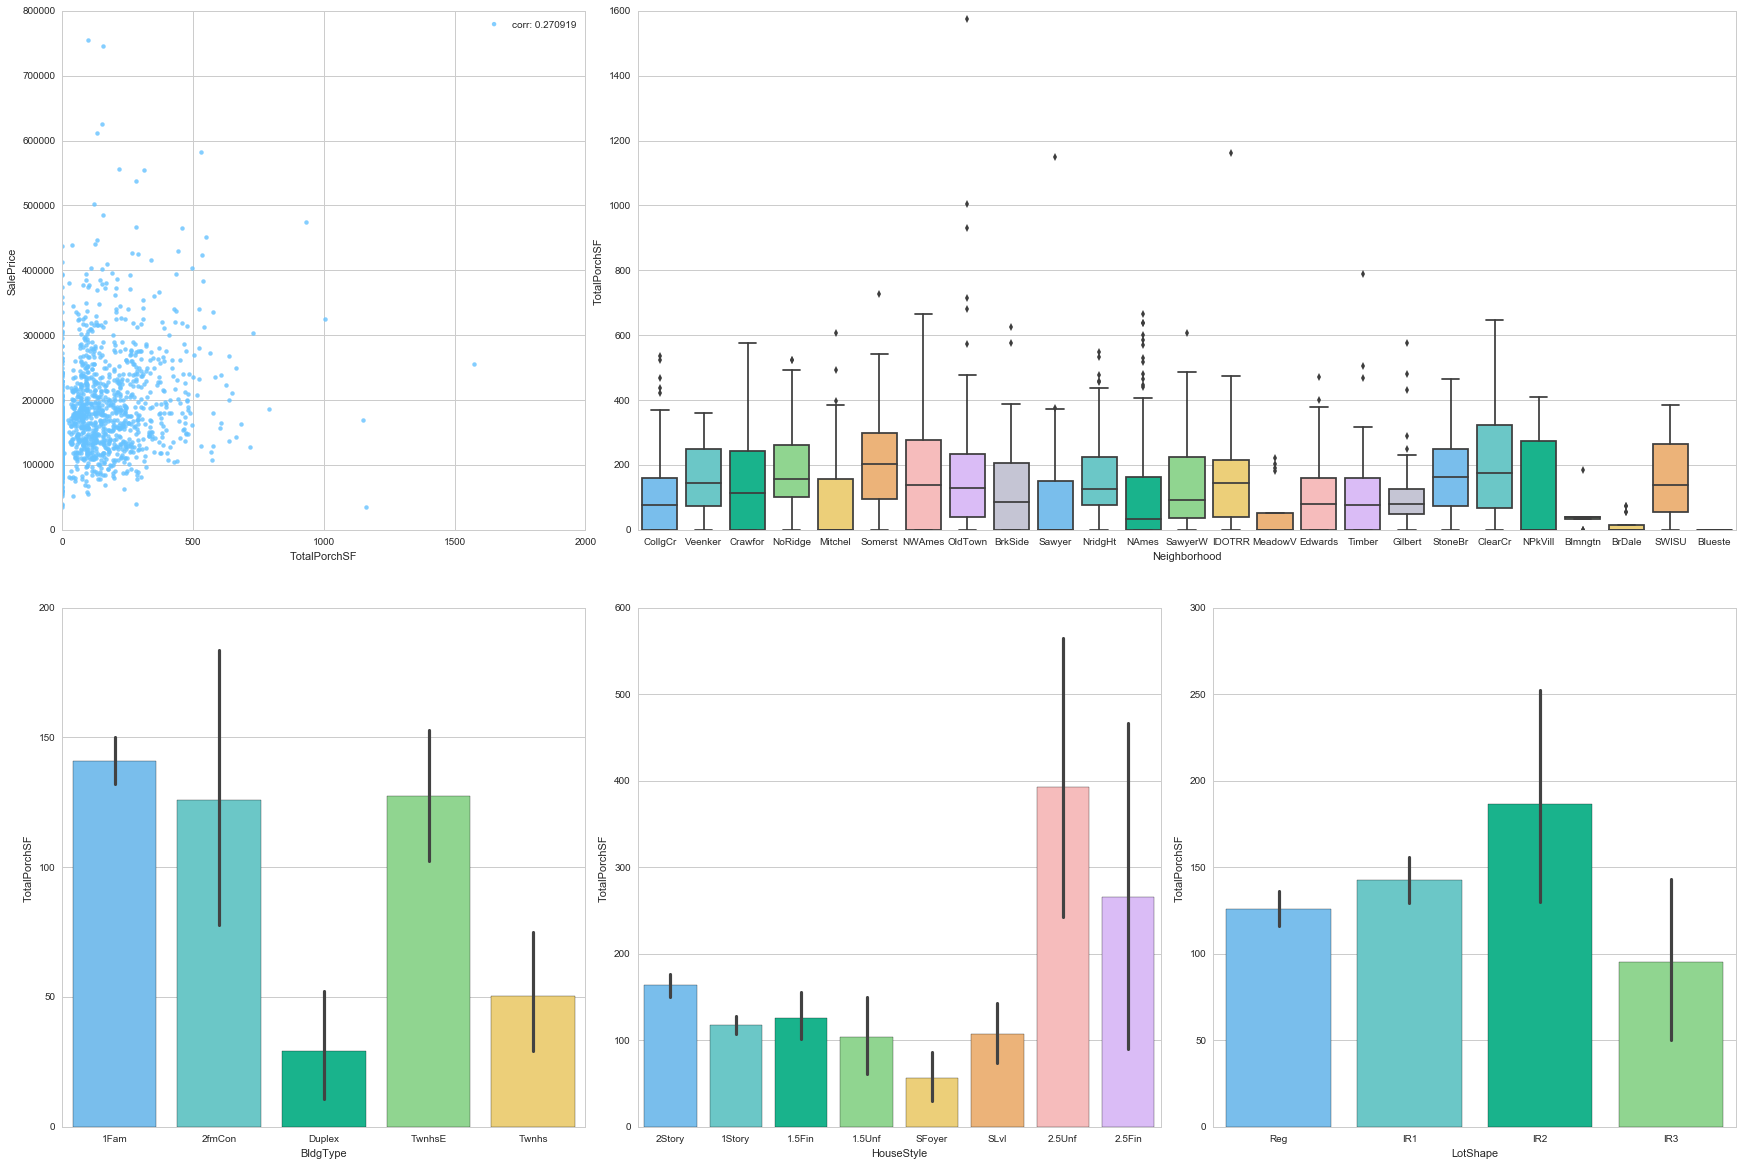

In [118]:
feature = 'TotalPorchSF'
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 20))

# plot
plt.subplot(grid[0, 0])
g = sns.regplot(x=train[feature], y=train['SalePrice'], fit_reg=False,
                label = "corr: %2f"%(pearsonr(train[feature], train['SalePrice'])[0]))
g = g.legend(loc="best")
g.axes.set_xlim(0,)
g.axes.set_ylim(0,)

# plot
plt.subplot(grid[0, 1:])
sns.boxplot(x='Neighborhood', y=feature, data=train, palette = mycols)

# plot
plt.subplot(grid[1, 0]);
sns.barplot(x='BldgType', y=feature, data=train, palette = mycols)

# plot
plt.subplot(grid[1, 1]);
sns.barplot(x='HouseStyle', y=feature, data=train, palette = mycols)

# plot
plt.subplot(grid[1, 2]);
sns.barplot(x='LotShape', y=feature, data=train, palette = mycols);

**COMMENT**
- Most of the data is assigned the value 0: we will create a flag.

In [119]:
def NoPorchFlag(col):
    if col['TotalPorchSF'] == 0:
        return 1
    else:
        return 0
    
all_data['NoPorch_Flag'] = all_data.apply(NoPorchFlag, axis=1)

In [120]:
all_data['TotalPorchSF'] = pd.qcut(all_data['TotalPorchSF'],[0,0.30,0.45,0.60,0.75,0.90,1.0],range(1,7))
all_data['TotalPorchSF'].unique()

[3, 1, 6, 4, 5, 2]
Categories (6, int64): [1 < 2 < 3 < 4 < 5 < 6]

In [121]:
all_data = pd.get_dummies(all_data, columns = ["TotalPorchSF"], prefix="TotalPorchSF")

**PoolArea**

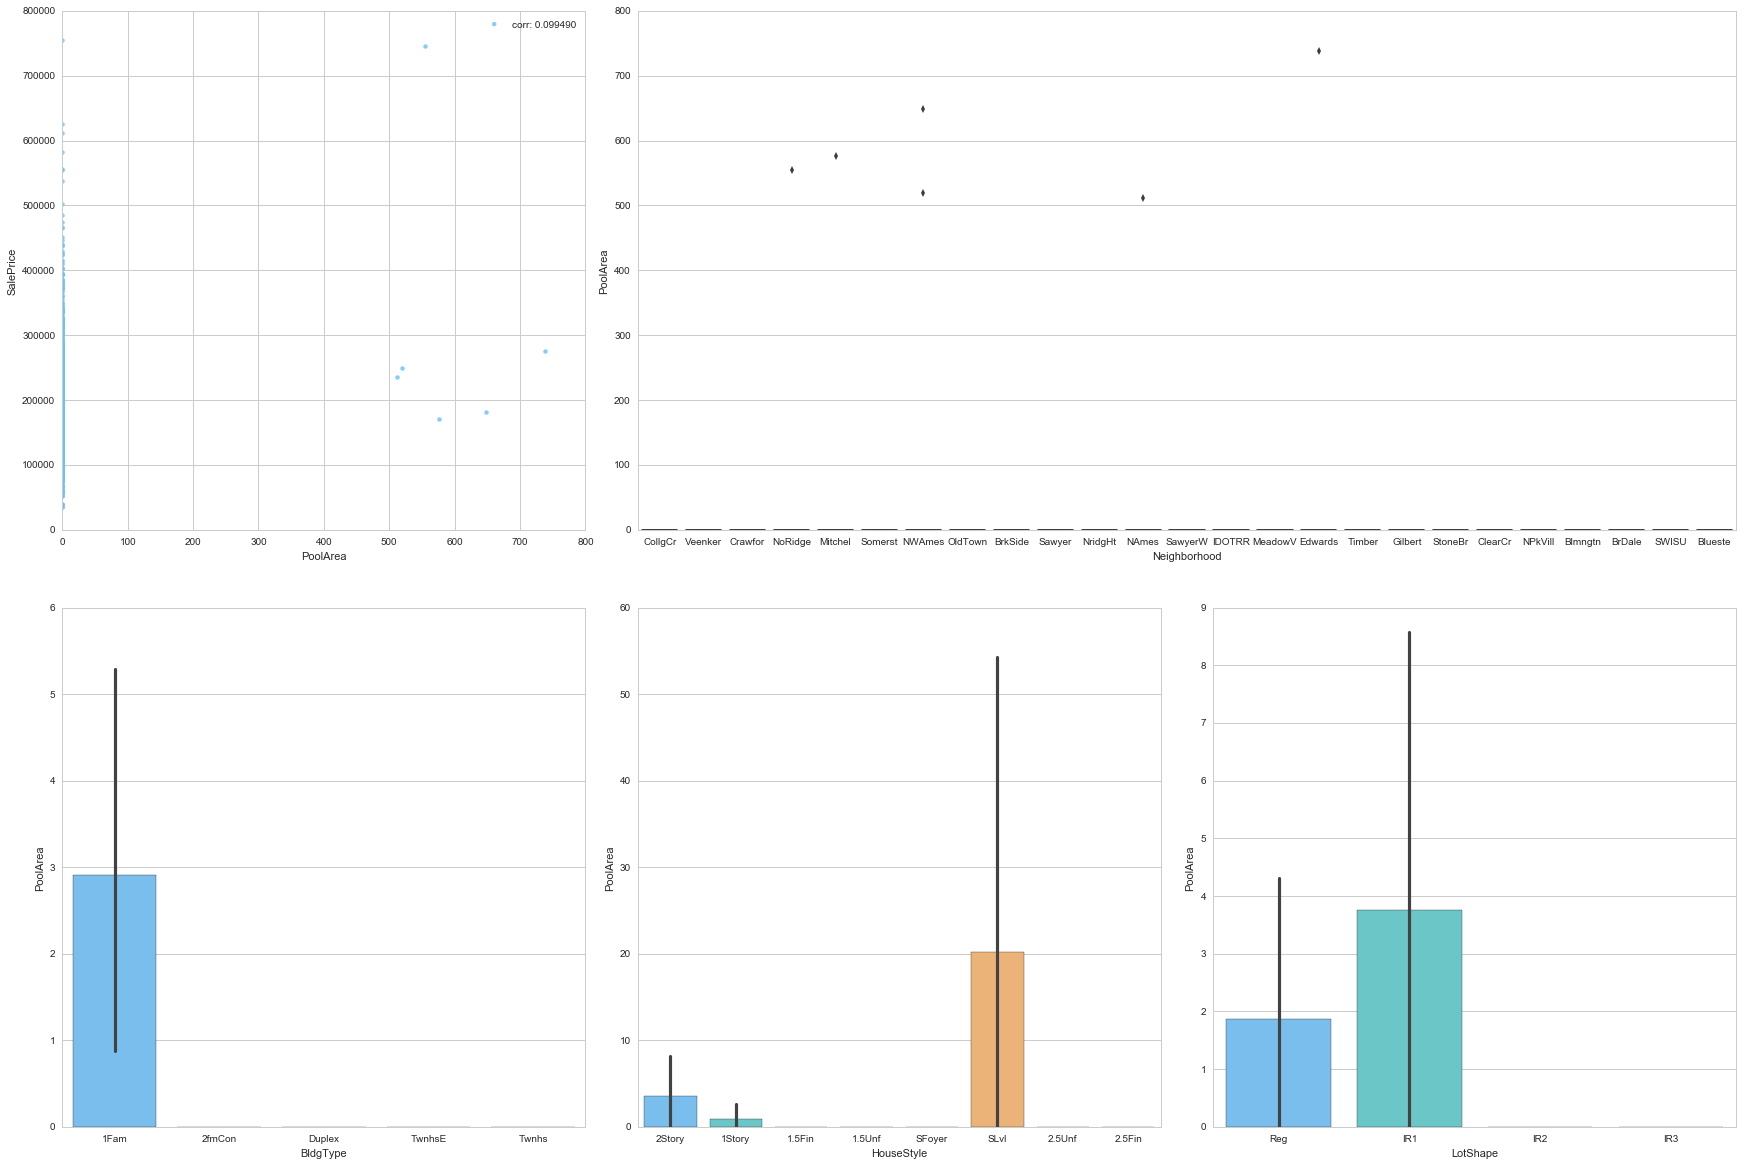

In [122]:
feature = 'PoolArea'
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 20))

# plot
plt.subplot(grid[0, 0])
g = sns.regplot(x=train[feature], y=train['SalePrice'], fit_reg=False,
                label = "corr: %2f"%(pearsonr(train[feature], train['SalePrice'])[0]))
g = g.legend(loc="best")
g.axes.set_xlim(0,)
g.axes.set_ylim(0,)

# plot
plt.subplot(grid[0, 1:])
sns.boxplot(x='Neighborhood', y=feature, data=train, palette = mycols)

# plot
plt.subplot(grid[1, 0]);
sns.barplot(x='BldgType', y=feature, data=train, palette = mycols)

# plot
plt.subplot(grid[1, 1]);
sns.barplot(x='HouseStyle', y=feature, data=train, palette = mycols)

# plot
plt.subplot(grid[1, 2]);
sns.barplot(x='LotShape', y=feature, data=train, palette = mycols);

**COMMENT**
- Most of the data is stored as 0. We will simply create a flag.
- Because of the lack of data, we will also drop the PoolQc feature.

In [123]:
def PoolFlag(col):
    if col['PoolArea'] == 0:
        return 0
    else:
        return 1
    
all_data['HasPool_Flag'] = all_data.apply(PoolFlag, axis=1)
all_data.drop('PoolArea', axis=1, inplace=True)

In [124]:
all_data.drop('PoolQC', axis=1, inplace=True)

**Fence**

In [125]:
all_data['Fence'].unique()

array(['None', 'MnPrv', 'GdWo', 'GdPrv', 'MnWw'], dtype=object)

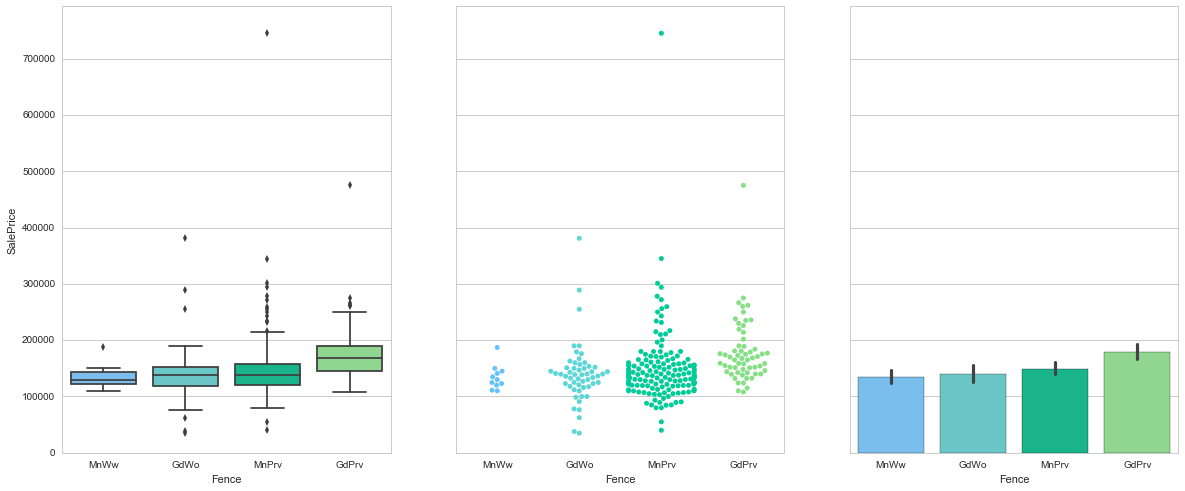

In [126]:
feature = 'Fence'
order=['MnWw', 'GdWo', 'MnPrv', 'GdPrv']
fig, axarr = plt.subplots(1,3,figsize =(20, 8),sharey=True)

# plot
sns.boxplot(x=feature, y='SalePrice',data=train,ax=axarr[0],order=order)

# plot
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,ax=axarr[1],order=order)
axarr[1].set_ylabel("")

# purpose
sns.barplot(x=feature, y='SalePrice',data=train,ax=axarr[2],order=order)
axarr[2].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

**COMMENT**
- The data is mostly stored in a single class.
- It is possibly to arrange the classes to create an ordinal sequence. However, the difference in average sale price between one class to another is too small to be used.

In [127]:
all_data = pd.get_dummies(all_data, columns = ["Fence"], prefix="Fence")

### Miscellaneous
The following variables are assigned to the "Miscellaneous" group.
- Order (Discrete): Observation number
- PID (Nominal): Parcel identification number  - can be used with city web site for parcel review. 
- MS Zoning (Nominal): Identifies the general zoning classification of the sale.
- Lot Frontage (Continuous): Linear feet of street connected to property
- Lot Area (Continuous): Lot size in square feet
- Street (Nominal): Type of road access to property      	
- Alley (Nominal): Type of alley access to property
- Lot Shape (Ordinal): General shape of property     
- Land Contour (Nominal): Flatness of the property
- Utilities (Ordinal): Type of utilities available
- Lot Config (Nominal): Lot configuration
- Land Slope (Ordinal): Slope of property
- Neighborhood (Nominal): Physical locations within Ames city limits (map available)
- Condition 1 (Nominal): Proximity to various conditions
- Condition 2 (Nominal): Proximity to various conditions (if more than one is present)
- Heating	(Nominal): Type of heating
- HeatingQC (Ordinal): Heating quality and condition
- Central Air (Nominal): Central air conditioning
- Electrical (Ordinal): Electrical system
- Paved Drive (Ordinal): Paved driveway
- Misc Feature (Nominal): Miscellaneous feature not covered in other categories
- Misc Val (Continuous): $Value of miscellaneous feature
- Mo Sold (Discrete): Month Sold (MM)
- Yr Sold (Discrete): Year Sold (YYYY)
- Sale Type (Nominal): Type of sale
- Sale Condition (Nominal): Condition of sale	

**MSZoning**

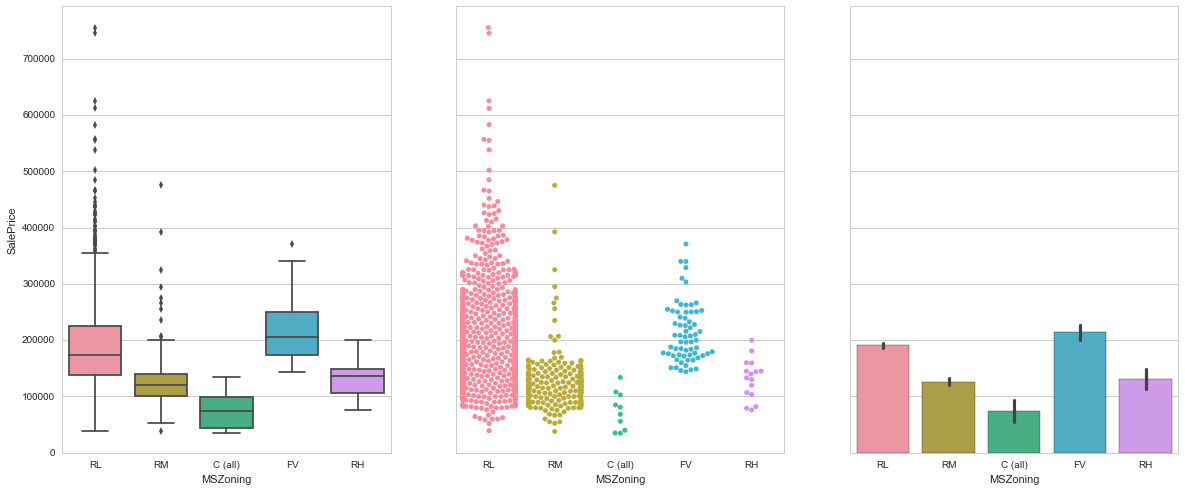

In [128]:
feature = 'MSZoning'
order=None
fig, axarr = plt.subplots(1,3,figsize =(20, 8),sharey=True)

# plot
sns.boxplot(x=feature, y='SalePrice',data=train,ax=axarr[0],order=order)

# plot
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,ax=axarr[1],order=order)
axarr[1].set_ylabel("")

# purpose
sns.barplot(x=feature, y='SalePrice',data=train,ax=axarr[2],order=order)
axarr[2].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

**COMMENT**
- The data is mostly contained is a single class.  
We convert the feature into a set of dummy variables.

In [129]:
all_data = pd.get_dummies(all_data, columns = ["MSZoning"], prefix="MSZoning")

**Neighborhood**

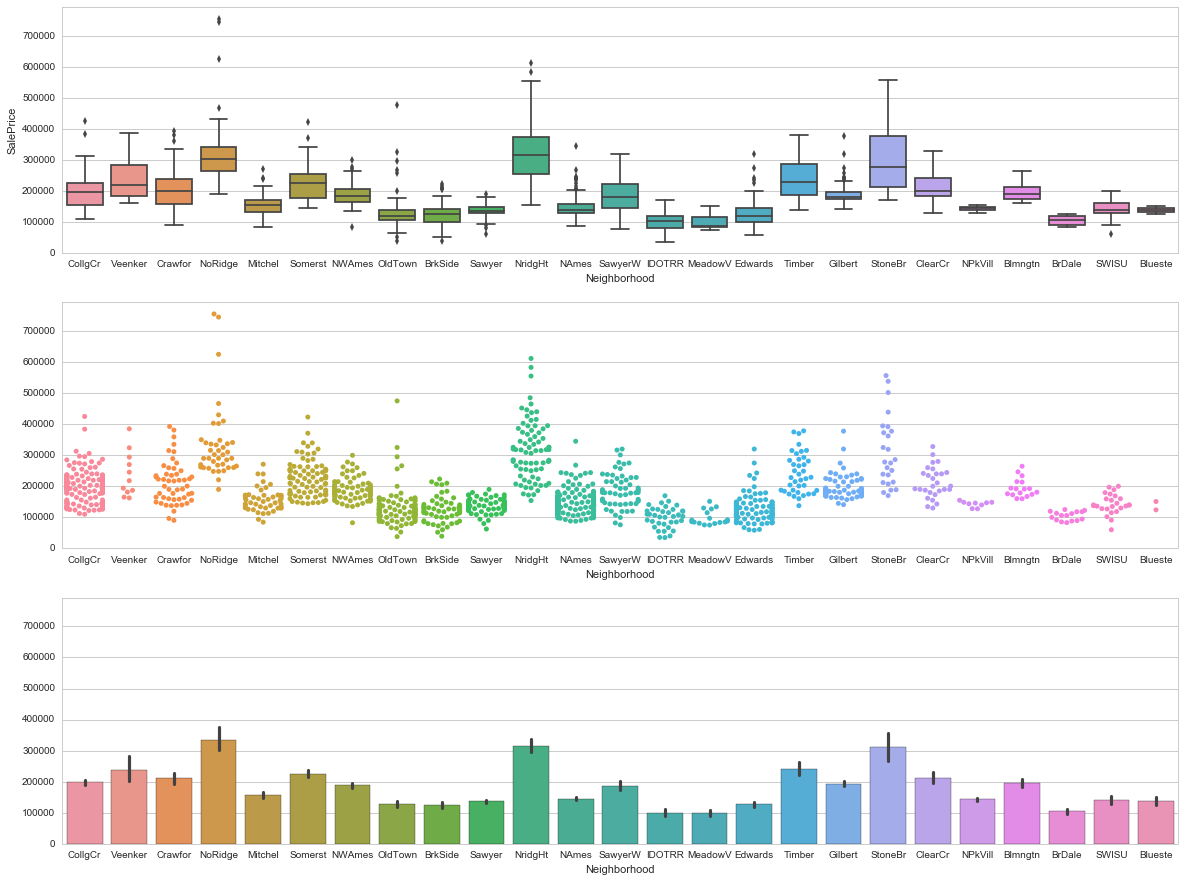

In [130]:
feature = 'Neighborhood'
order=None
fig, axarr = plt.subplots(3,1,figsize =(20, 15),sharey=True)

# plot
sns.boxplot(x=feature, y='SalePrice',data=train,ax=axarr[0],order=order)

# plot
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,ax=axarr[1],order=order)
axarr[1].set_ylabel("")

# purpose
sns.barplot(x=feature, y='SalePrice',data=train,ax=axarr[2],order=order)
axarr[2].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

**COMMENT**
- The location is obviously a key feature when predicting the price of an estate.
We convert this feature into a set of dummies.

In [131]:
all_data = pd.get_dummies(all_data, columns = ["Neighborhood"], prefix="Neighborhood")

**Condition1** and **Condition2**

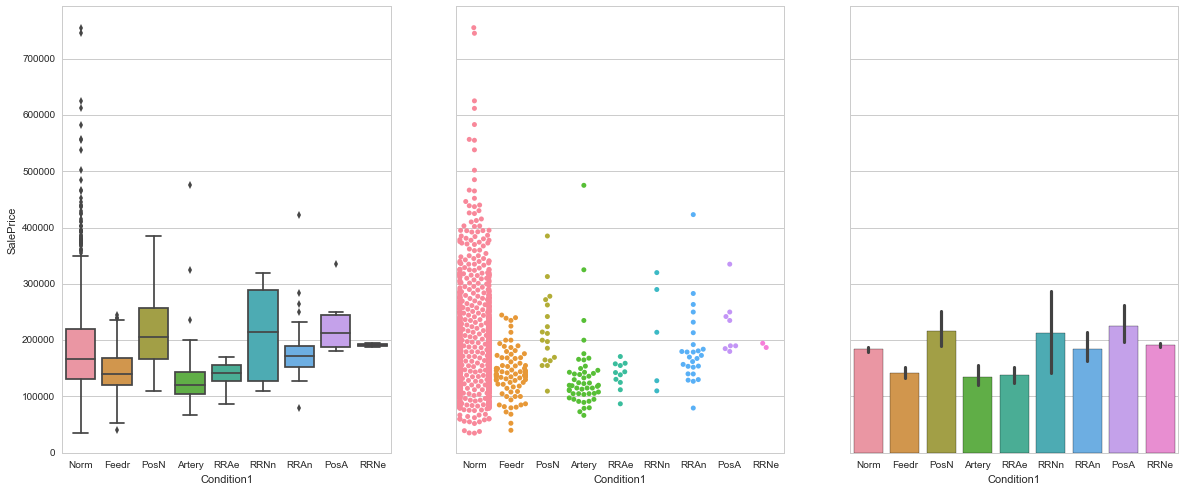

In [132]:
feature = 'Condition1'
order=None
fig, axarr = plt.subplots(1,3,figsize =(20, 8),sharey=True)

# plot
sns.boxplot(x=feature, y='SalePrice',data=train,ax=axarr[0],order=order)

# plot
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,ax=axarr[1],order=order)
axarr[1].set_ylabel("")

# purpose
sns.barplot(x=feature, y='SalePrice',data=train,ax=axarr[2],order=order)
axarr[2].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

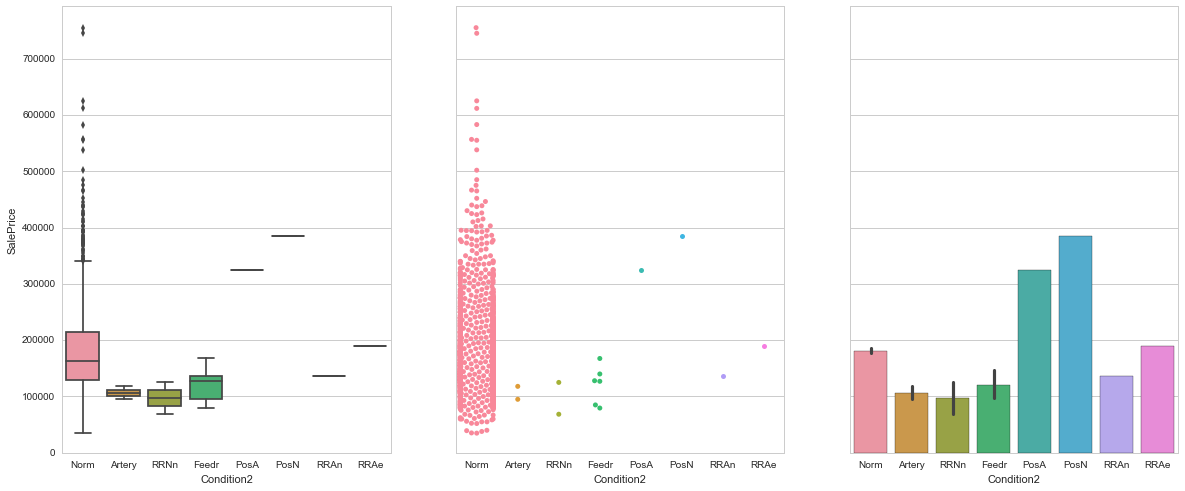

In [133]:
feature = 'Condition2'
order=None
fig, axarr = plt.subplots(1,3,figsize =(20, 8),sharey=True)

# plot
sns.boxplot(x=feature, y='SalePrice',data=train,ax=axarr[0],order=order)

# plot
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,ax=axarr[1],order=order)
axarr[1].set_ylabel("")

# purpose
sns.barplot(x=feature, y='SalePrice',data=train,ax=axarr[2],order=order)
axarr[2].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

**COMMENT**
- For both features, the data is concentrated into a single class.
- The distribution between the two features is similar, we will therefore convert the Condition2 into a simple flag.

In [134]:
def ConditionMatch(col):
    if col['Condition1'] == col['Condition2']:
        return 0
    else:
        return 1
    
all_data['Diff2ndCondition_Flag'] = all_data.apply(ConditionMatch, axis=1)
all_data.drop('Condition2', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["Condition1"], prefix="Condition1")

**LotFrontage**

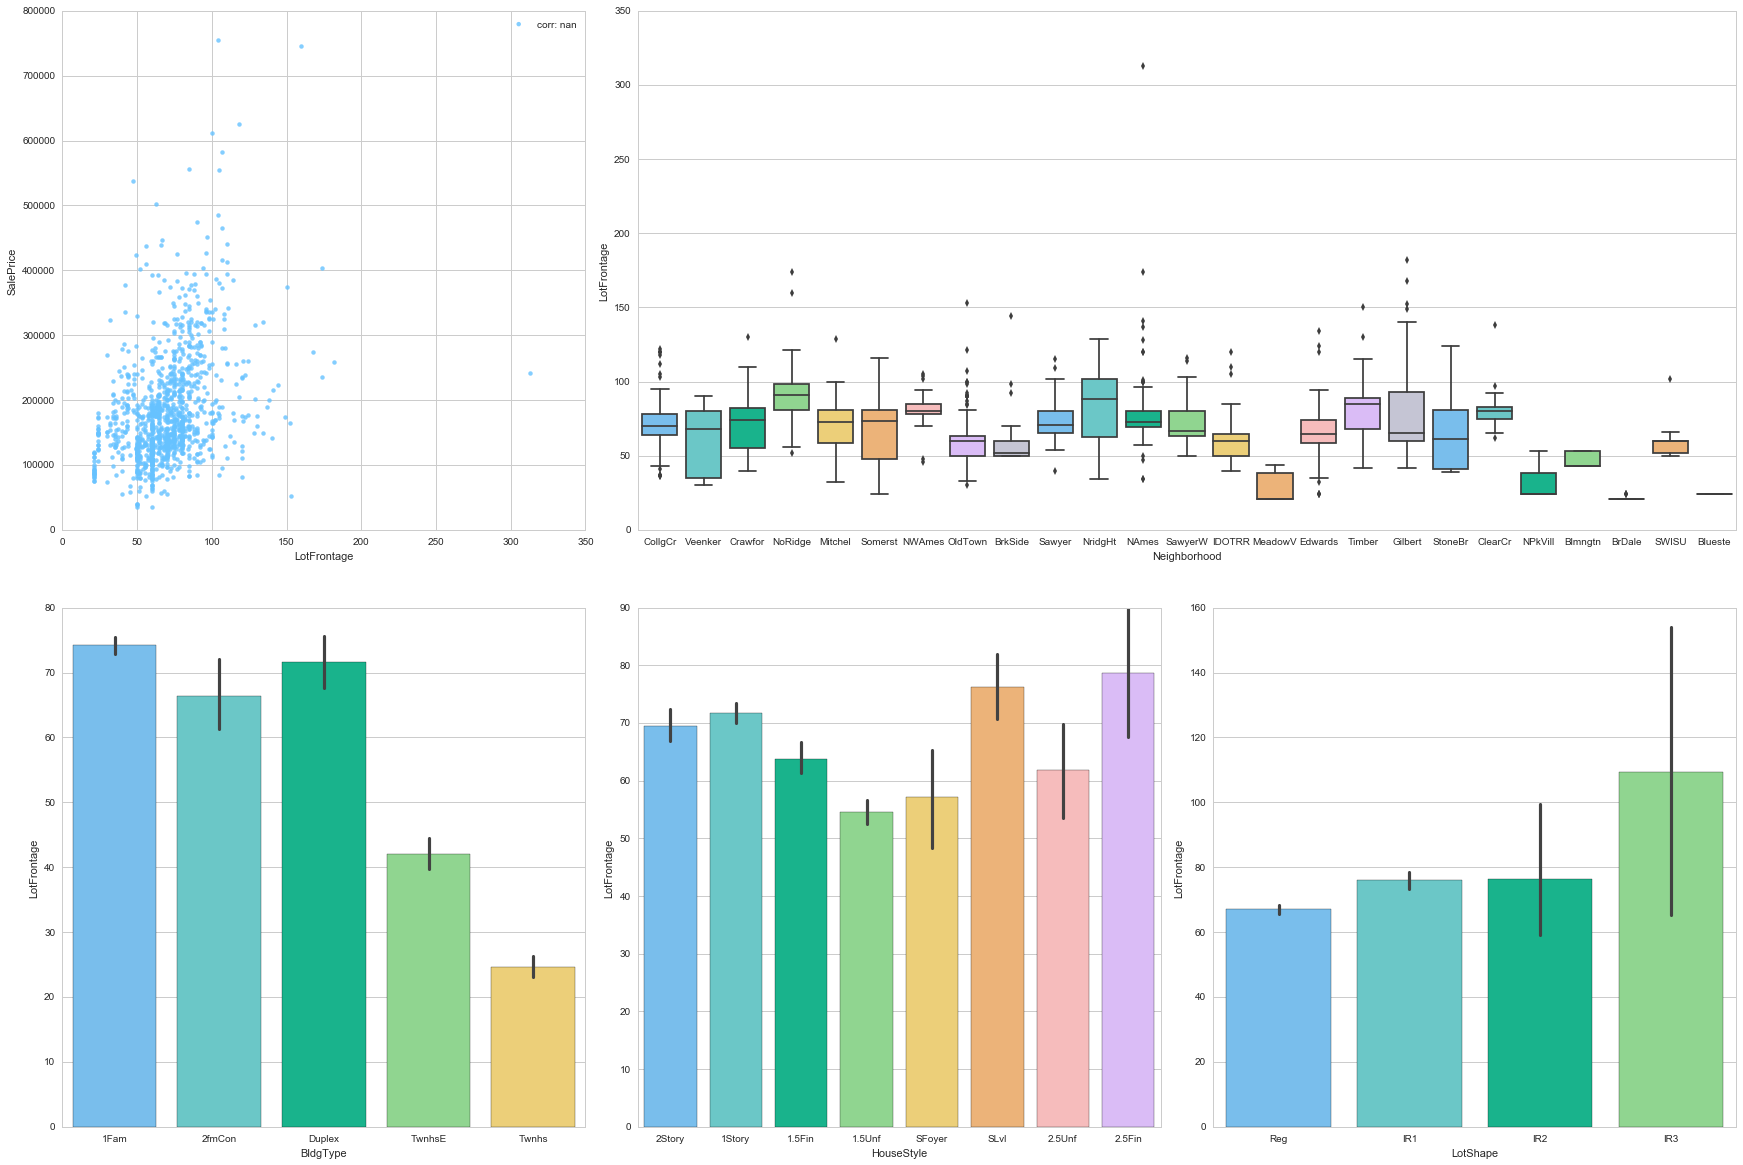

In [135]:
feature = 'LotFrontage'
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 20))

# plot
plt.subplot(grid[0, 0])
g = sns.regplot(x=train[feature], y=train['SalePrice'], fit_reg=False,
                label = "corr: %2f"%(pearsonr(train[feature], train['SalePrice'])[0]))
g = g.legend(loc="best")
g.axes.set_xlim(0,)
g.axes.set_ylim(0,)

# plot
plt.subplot(grid[0, 1:])
sns.boxplot(x='Neighborhood', y=feature, data=train, palette = mycols)

# plot
plt.subplot(grid[1, 0]);
sns.barplot(x='BldgType', y=feature, data=train, palette = mycols)

# plot
plt.subplot(grid[1, 1]);
sns.barplot(x='HouseStyle', y=feature, data=train, palette = mycols)

# plot
plt.subplot(grid[1, 2]);
sns.barplot(x='LotShape', y=feature, data=train, palette = mycols);

**COMMENT**
- The original set presents a large number of null values.
- The neighborhoods and the house type do not seem to play a signinficant role for this feature.

**LotArea**

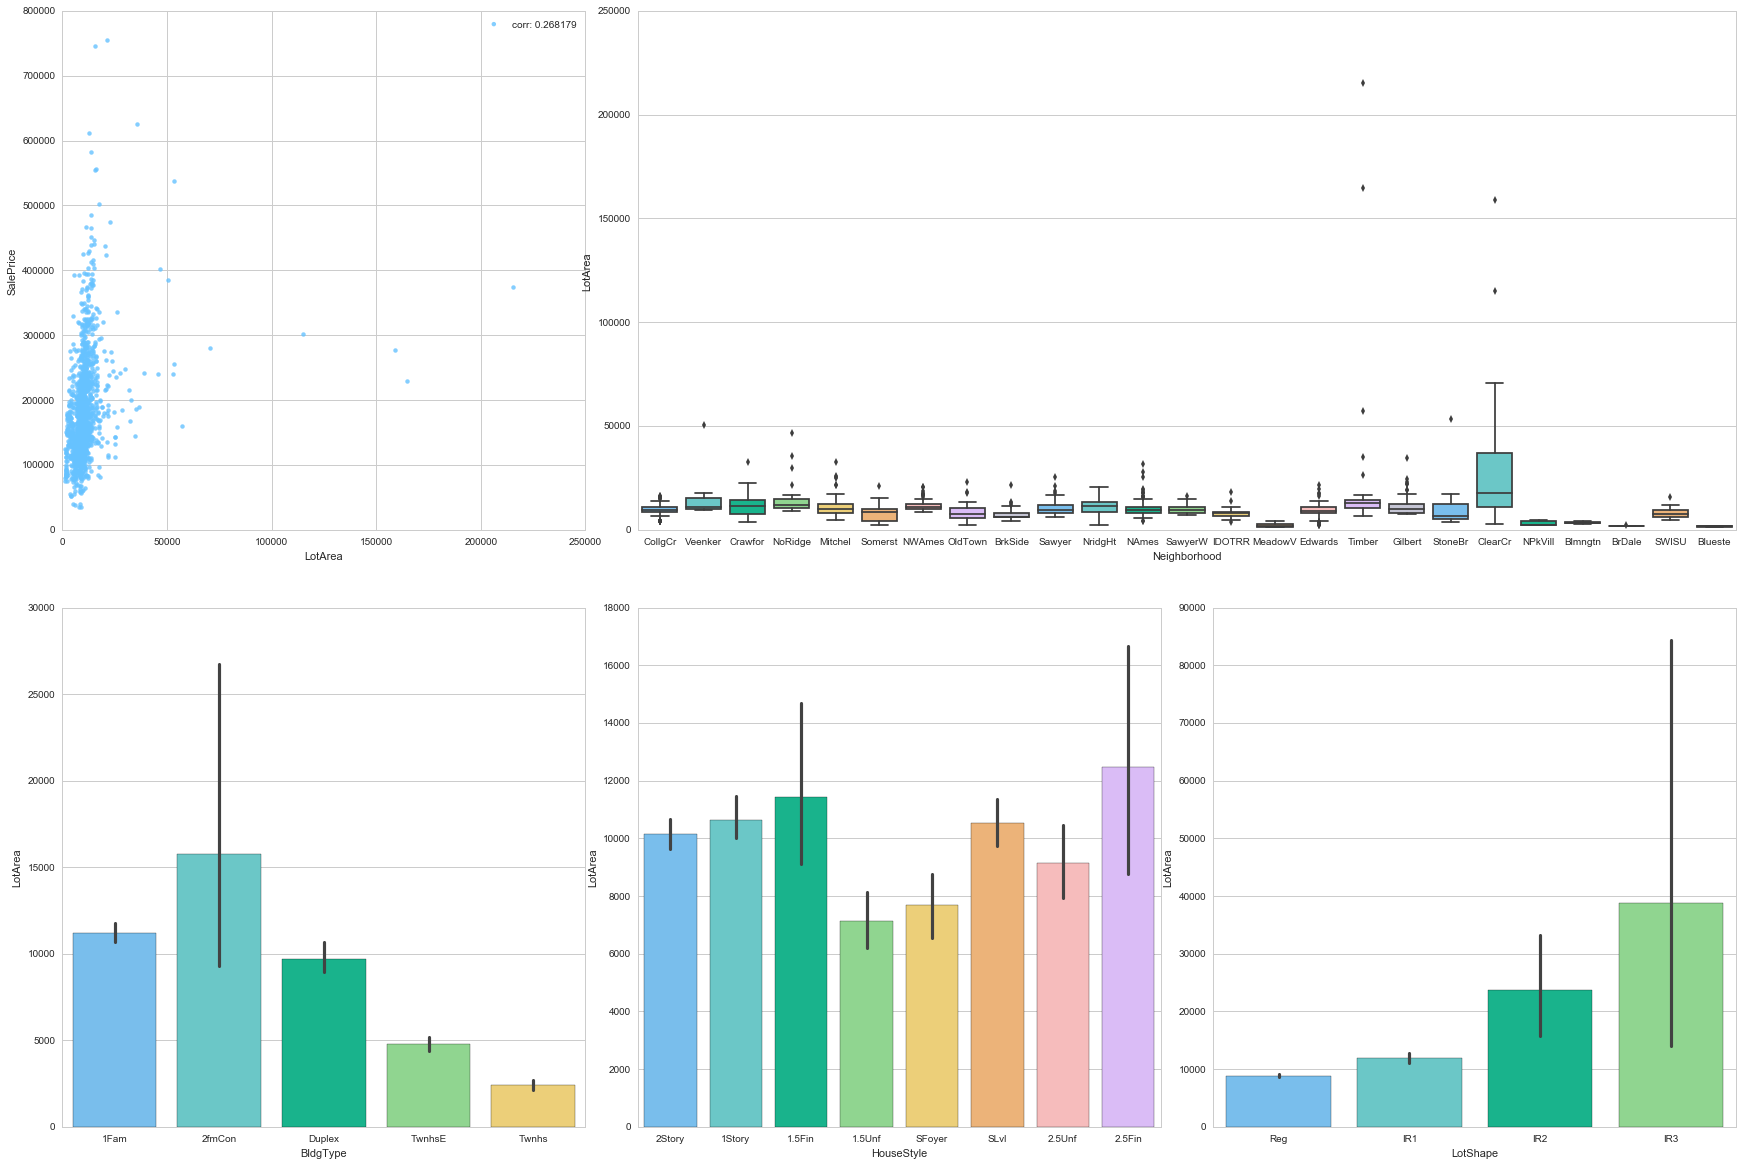

In [136]:
feature = 'LotArea'
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 20))

# plot
plt.subplot(grid[0, 0])
g = sns.regplot(x=train[feature], y=train['SalePrice'], fit_reg=False,
                label = "corr: %2f"%(pearsonr(train[feature], train['SalePrice'])[0]))
g = g.legend(loc="best")
g.axes.set_xlim(0,)
g.axes.set_ylim(0,)

# plot
plt.subplot(grid[0, 1:])
sns.boxplot(x='Neighborhood', y=feature, data=train, palette = mycols)

# plot
plt.subplot(grid[1, 0]);
sns.barplot(x='BldgType', y=feature, data=train, palette = mycols)

# plot
plt.subplot(grid[1, 1]);
sns.barplot(x='HouseStyle', y=feature, data=train, palette = mycols)

# plot
plt.subplot(grid[1, 2]);
sns.barplot(x='LotShape', y=feature, data=train, palette = mycols);

**COMMENT**
- As expected, this feature is strongly positively correlated to the sale price.

In [137]:
all_data['LotArea'] = pd.qcut(all_data['LotArea'],8,range(1,9))
all_data['LotArea'].unique()

[3, 5, 6, 8, 2, 7, 1, 4]
Categories (8, int64): [1 < 2 < 3 < 4 < 5 < 6 < 7 < 8]

In [138]:
all_data = pd.get_dummies(all_data, columns = ["LotArea"], prefix="LotArea")

**LotShape**

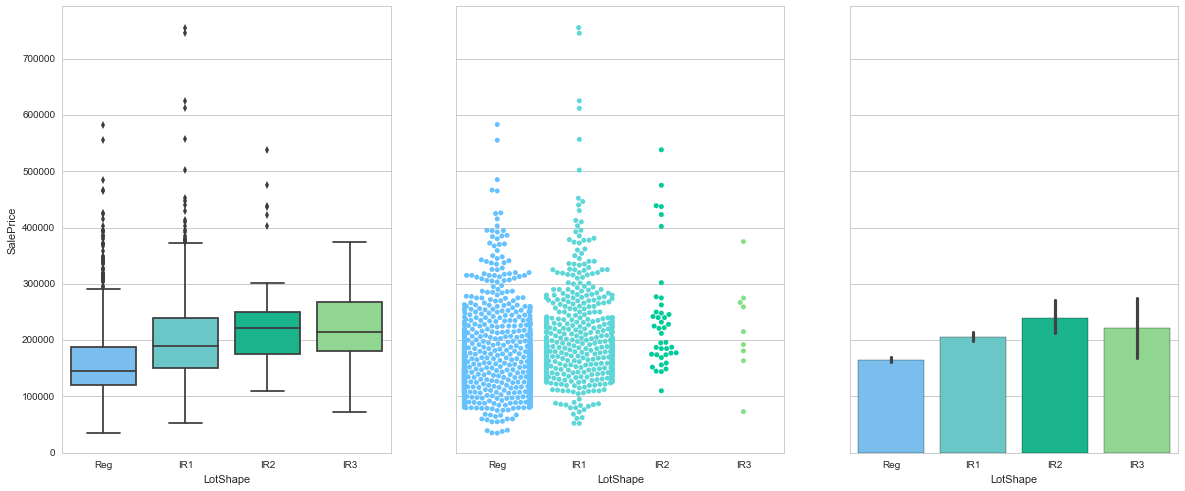

In [139]:
feature = 'LotShape'
order=None
fig, axarr = plt.subplots(1,3,figsize =(20, 8),sharey=True)

# plot
sns.boxplot(x=feature, y='SalePrice',data=train,ax=axarr[0],order=order)

# plot
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,ax=axarr[1],order=order)
axarr[1].set_ylabel("")

# purpose
sns.barplot(x=feature, y='SalePrice',data=train,ax=axarr[2],order=order)
axarr[2].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

**COMMENT**
- The data is concentrated into two classes.
- Dummy features are created.

In [140]:
all_data = pd.get_dummies(all_data, columns = ["LotShape"], prefix="LotShape")

**LandContour**

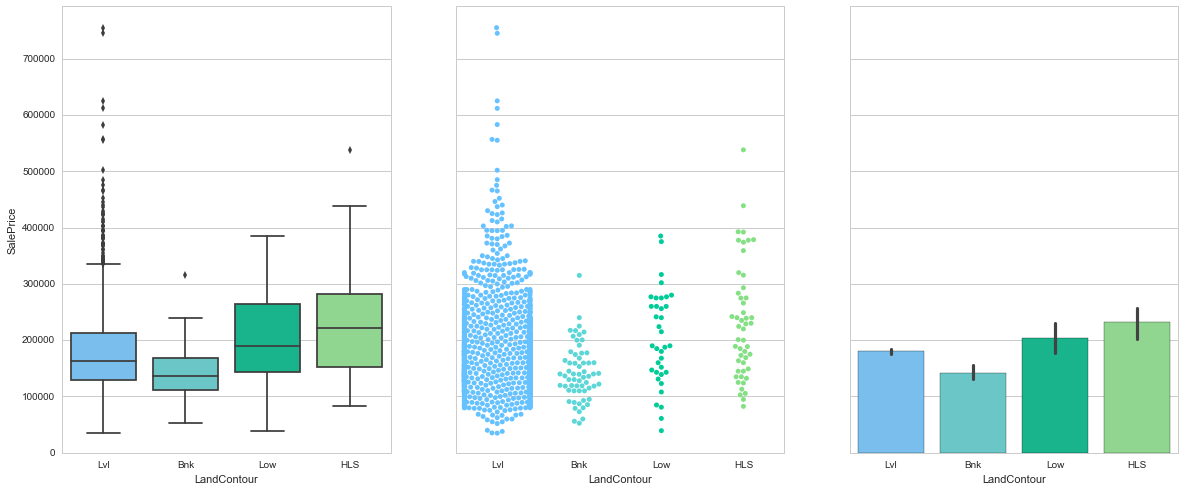

In [141]:
feature = 'LandContour'
order=None
fig, axarr = plt.subplots(1,3,figsize =(20, 8),sharey=True)

# plot
sns.boxplot(x=feature, y='SalePrice',data=train,ax=axarr[0],order=order)

# plot
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,ax=axarr[1],order=order)
axarr[1].set_ylabel("")

# purpose
sns.barplot(x=feature, y='SalePrice',data=train,ax=axarr[2],order=order)
axarr[2].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

**COMMENT**
- The data is concentrated into a single class.
- Dummy features are created.

In [142]:
all_data = pd.get_dummies(all_data, columns = ["LandContour"], prefix="LandContour")

**LotConfig**

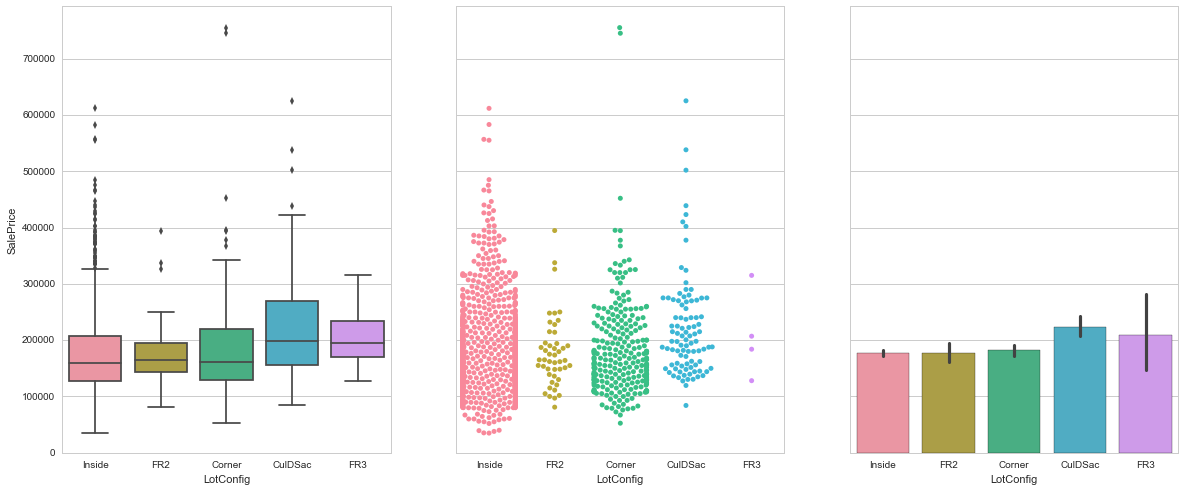

In [143]:
feature = 'LotConfig'
order=None
fig, axarr = plt.subplots(1,3,figsize =(20, 8),sharey=True)

# plot
sns.boxplot(x=feature, y='SalePrice',data=train,ax=axarr[0],order=order)

# plot
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,ax=axarr[1],order=order)
axarr[1].set_ylabel("")

# purpose
sns.barplot(x=feature, y='SalePrice',data=train,ax=axarr[2],order=order)
axarr[2].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

**COMMENT**
- The data is concentrated into three classes.
- FR2 and FR3 are merged.
- Dummy features are created.

In [144]:
all_data['LotConfig'] = all_data['LotConfig'].map({"FR2":"FR", "FR3":"FR"})
all_data['LotConfig'][0:5]
all_data = pd.get_dummies(all_data, columns = ["LotConfig"], prefix="LotConfig")

**LandSlope**

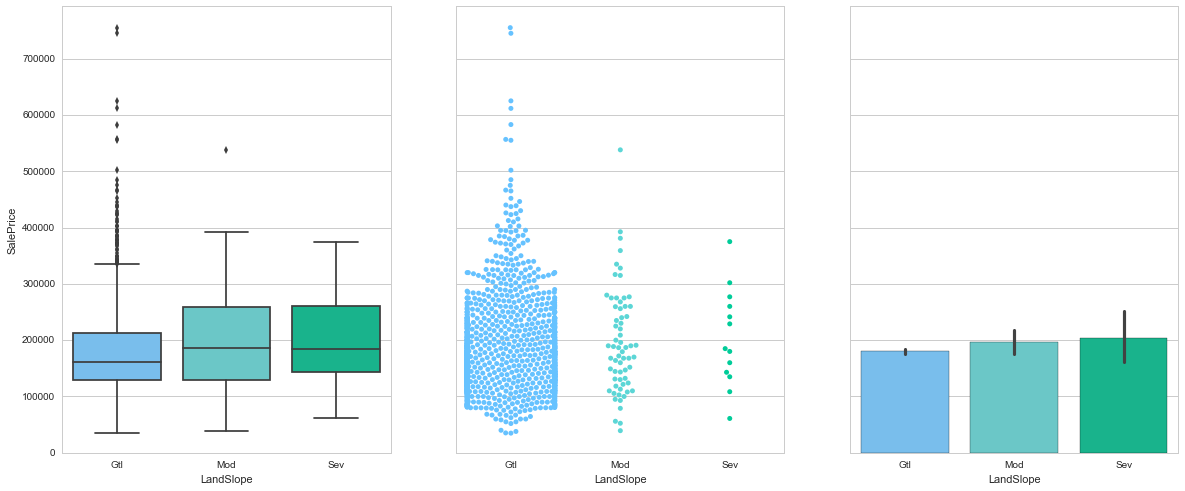

In [145]:
feature = 'LandSlope'
order=None
fig, axarr = plt.subplots(1,3,figsize =(20, 8),sharey=True)

# plot
sns.boxplot(x=feature, y='SalePrice',data=train,ax=axarr[0],order=order)

# plot
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,ax=axarr[1],order=order)
axarr[1].set_ylabel("")

# purpose
sns.barplot(x=feature, y='SalePrice',data=train,ax=axarr[2],order=order)
axarr[2].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

**COMMENT**
- This feature does not have a clear impact on the sale price. We will simply use a flag to identify records that are labelled "Gt1"

In [146]:
def Slope(col):
    if col['LandSlope'] == 'Gt1':
        return 1
    else:
        return 0
    
all_data['GentleSlope_Flag'] = all_data.apply(Slope, axis=1)
all_data.drop('LandSlope', axis=1, inplace=True)

**Street**

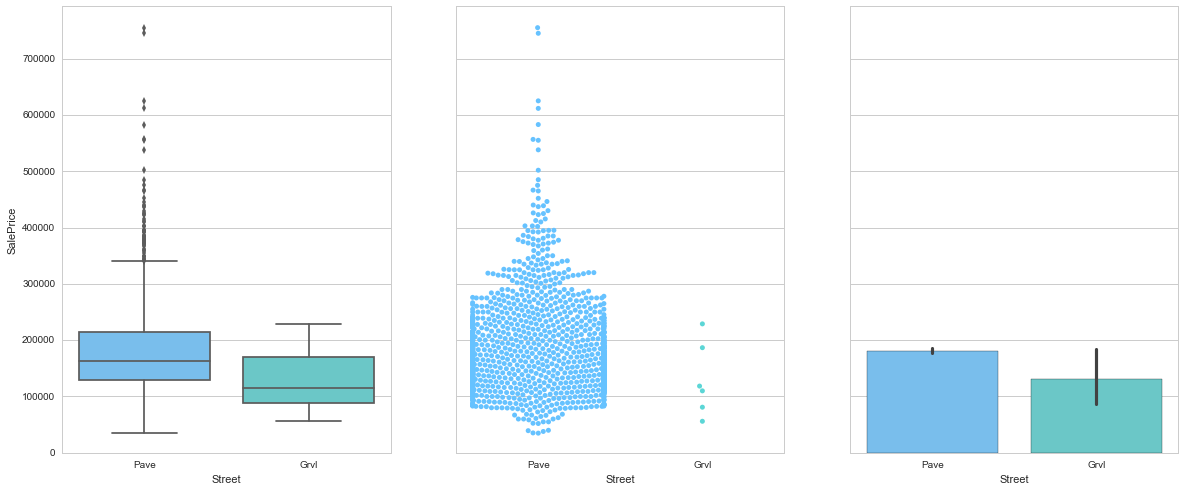

In [147]:
feature = 'Street'
order=None
fig, axarr = plt.subplots(1,3,figsize =(20, 8),sharey=True)

# plot
sns.boxplot(x=feature, y='SalePrice',data=train,ax=axarr[0],order=order)

# plot
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,ax=axarr[1],order=order)
axarr[1].set_ylabel("")

# purpose
sns.barplot(x=feature, y='SalePrice',data=train,ax=axarr[2],order=order)
axarr[2].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

**COMMENT**
- The vast majority of the data is stored under the same class. This feature is therefore dropped.

In [148]:
all_data.drop('Street', axis=1, inplace=True)

**Alley**

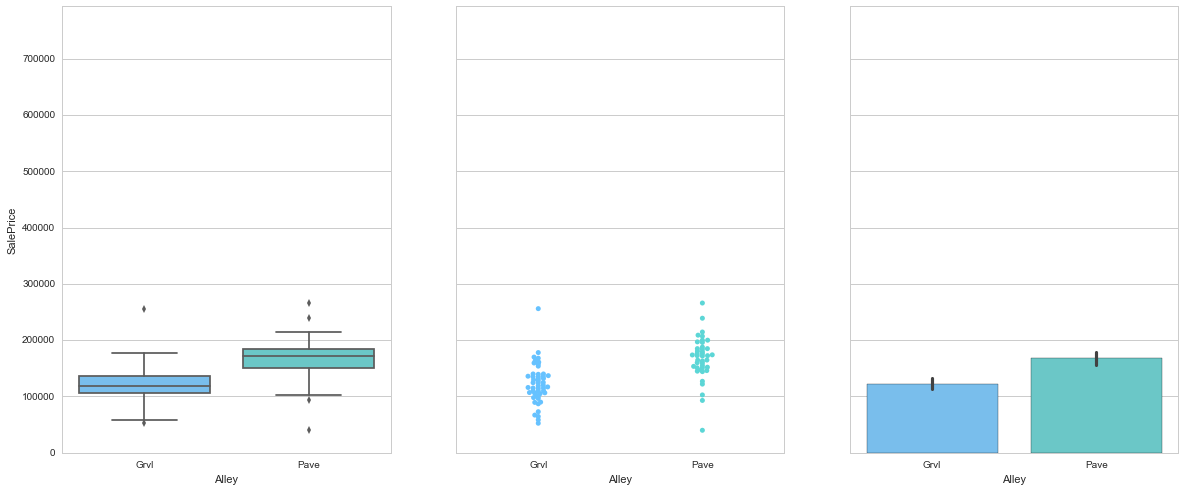

In [149]:
feature = 'Alley'
order=None
fig, axarr = plt.subplots(1,3,figsize =(20, 8),sharey=True)

# plot
sns.boxplot(x=feature, y='SalePrice',data=train,ax=axarr[0],order=order)

# plot
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,ax=axarr[1],order=order)
axarr[1].set_ylabel("")

# purpose
sns.barplot(x=feature, y='SalePrice',data=train,ax=axarr[2],order=order)
axarr[2].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

**COMMENT**
- Since there is a slight difference in the sale price between the two classes, we will simply convert this feature into a set of dummy variables.

In [150]:
all_data = pd.get_dummies(all_data, columns = ["Alley"], prefix="Alley")

**PavedDrive**

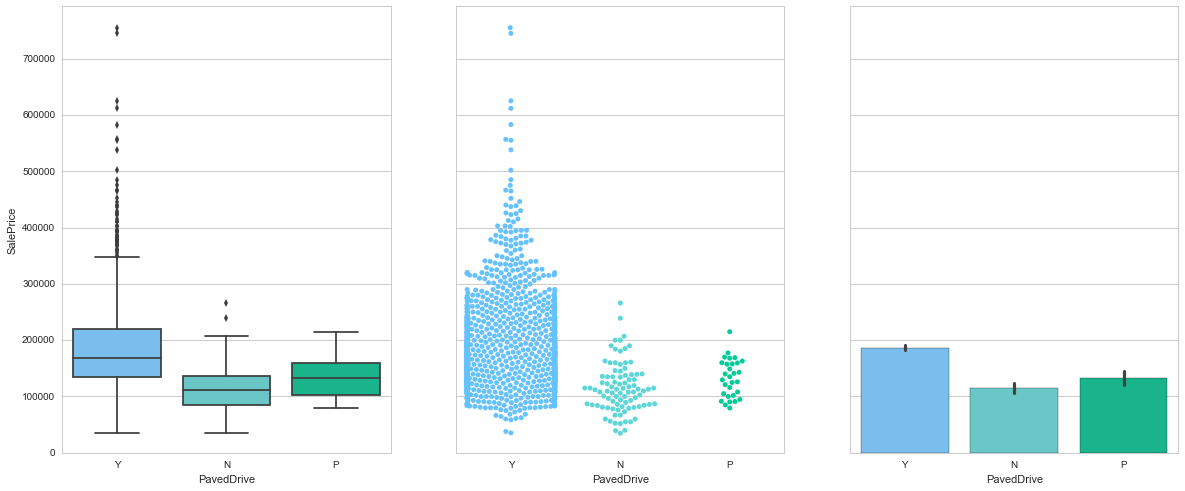

In [151]:
feature = 'PavedDrive'
order=None
fig, axarr = plt.subplots(1,3,figsize =(20, 8),sharey=True)

# plot
sns.boxplot(x=feature, y='SalePrice',data=train,ax=axarr[0],order=order)

# plot
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,ax=axarr[1],order=order)
axarr[1].set_ylabel("")

# purpose
sns.barplot(x=feature, y='SalePrice',data=train,ax=axarr[2],order=order)
axarr[2].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

**COMMENT**
- Most of the data is contained in the Y class.
- Since there is a slight difference in the sale price between the three classes, we will simply convert this feature into a set of dummy variables.

In [152]:
all_data = pd.get_dummies(all_data, columns = ["PavedDrive"], prefix="PavedDrive")

**Heating**

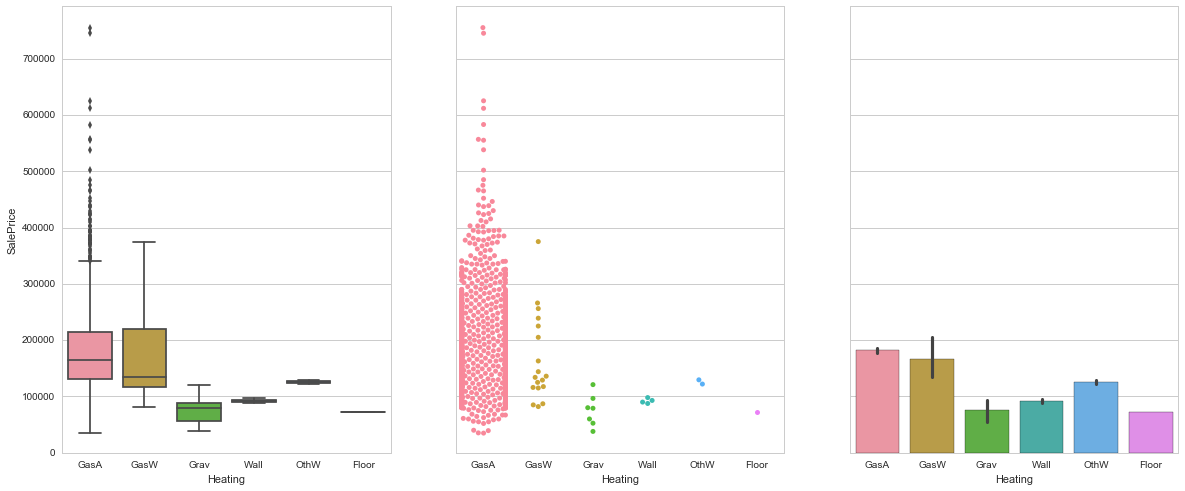

In [153]:
feature = 'Heating'
order=None
fig, axarr = plt.subplots(1,3,figsize =(20, 8),sharey=True)

# plot
sns.boxplot(x=feature, y='SalePrice',data=train,ax=axarr[0],order=order)

# plot
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,ax=axarr[1],order=order)
axarr[1].set_ylabel("")

# purpose
sns.barplot(x=feature, y='SalePrice',data=train,ax=axarr[2],order=order)
axarr[2].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

**COMMENT**
- The vast majority of the data is contained in the GasA class. Since the sale price differs between non-GasA records and GasA records, we will simply create a flag.

In [154]:
all_data['GasA_Flag'] = all_data['Heating'].map({"GasA":1, "GasW":0, "Grav":0, "Wall":0, "OthW":0, "Floor":0})
all_data.drop('Heating', axis=1, inplace=True)

**HeatingQC**

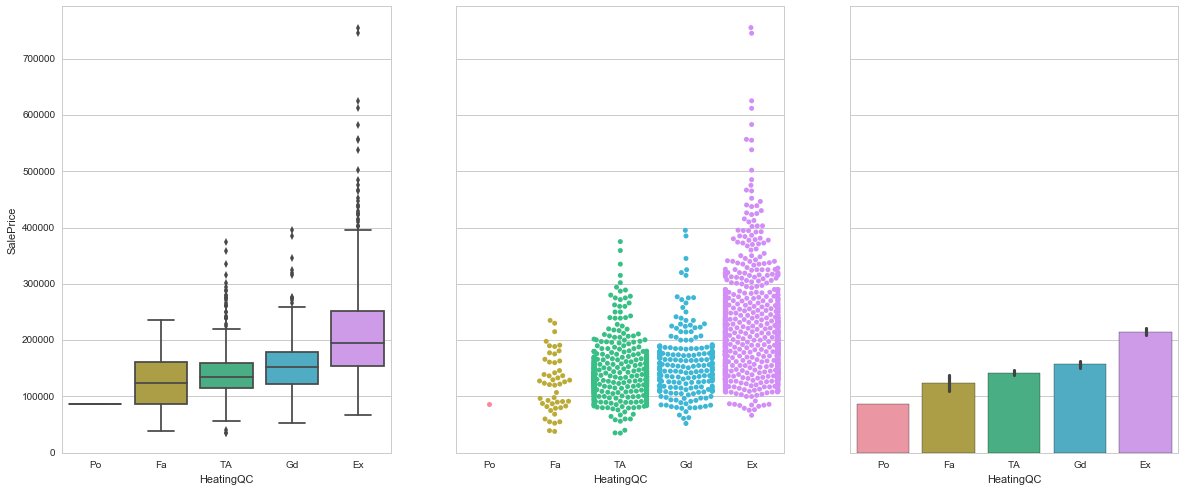

In [155]:
feature = 'HeatingQC'
order=["Po", "Fa", "TA", "Gd", "Ex"]
fig, axarr = plt.subplots(1,3,figsize =(20, 8),sharey=True)

# plot
sns.boxplot(x=feature, y='SalePrice',data=train,ax=axarr[0],order=order)

# plot
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,ax=axarr[1],order=order)
axarr[1].set_ylabel("")

# purpose
sns.barplot(x=feature, y='SalePrice',data=train,ax=axarr[2],order=order)
axarr[2].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

**COMMENT**
- We were able to find a order that corresponds to an increase in sale price.
- We map the data to a numerical feature corresponding to the class ranking.

In [156]:
all_data['HeatingQC'] = all_data['HeatingQC'].map({"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
all_data['HeatingQC'].unique()

array([5, 4, 3, 2, 1])

**CentralAir**

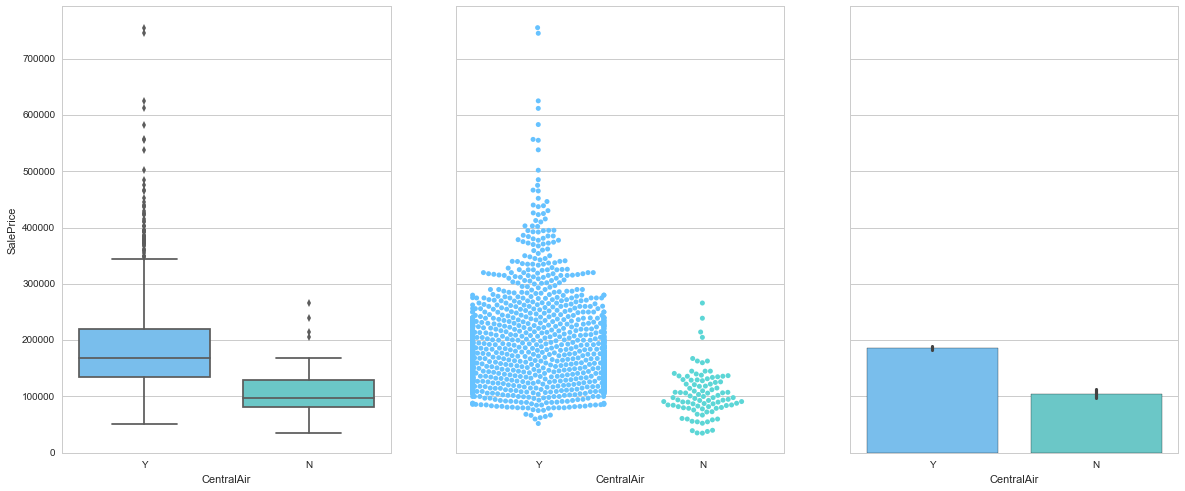

In [157]:
feature = 'CentralAir'
order=None
fig, axarr = plt.subplots(1,3,figsize =(20, 8),sharey=True)

# plot
sns.boxplot(x=feature, y='SalePrice',data=train,ax=axarr[0],order=order)

# plot
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,ax=axarr[1],order=order)
axarr[1].set_ylabel("")

# purpose
sns.barplot(x=feature, y='SalePrice',data=train,ax=axarr[2],order=order)
axarr[2].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

**COMMENT**
- The data is mostly stored under the "Y" class. Since this feature is a boolean feature, we simply map "Y" to the value 1 and "No" to the value 0.

In [158]:
all_data['CentralAir'] = all_data['CentralAir'].map({"Y":1, "N":0})
all_data['CentralAir'].unique()

array([1, 0])

**Utilities**

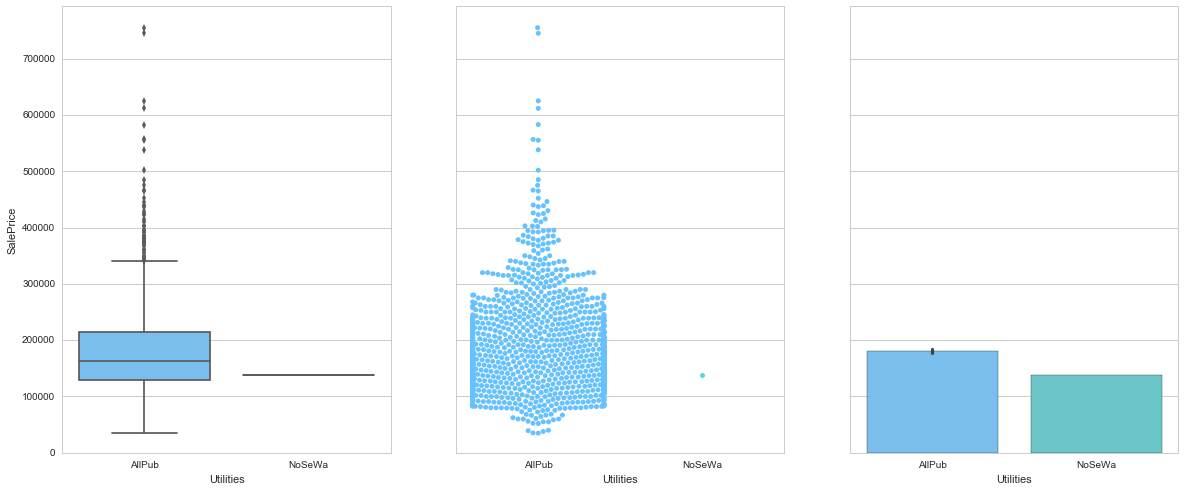

In [159]:
feature = 'Utilities'
order=None
fig, axarr = plt.subplots(1,3,figsize =(20, 8),sharey=True)

# plot
sns.boxplot(x=feature, y='SalePrice',data=train,ax=axarr[0],order=order)

# plot
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,ax=axarr[1],order=order)
axarr[1].set_ylabel("")

# purpose
sns.barplot(x=feature, y='SalePrice',data=train,ax=axarr[2],order=order)
axarr[2].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

**COMMENT**
- The utilities feature is dropped since the data is mostly assigned to a single class.

In [160]:
all_data.drop(columns=['Utilities'],axis=1,inplace=True)

**Electrical**

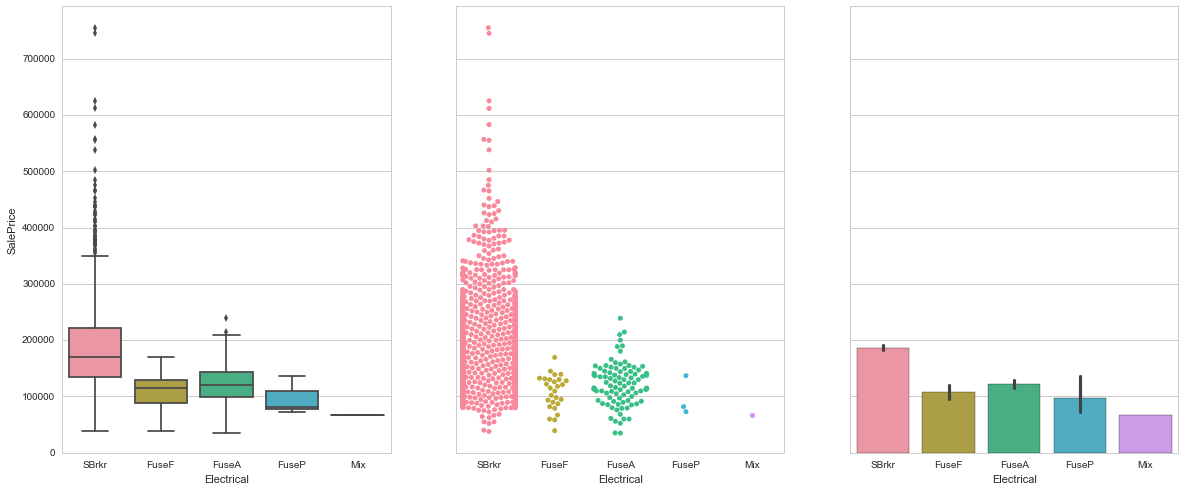

In [161]:
feature = 'Electrical'
order=None
fig, axarr = plt.subplots(1,3,figsize =(20, 8),sharey=True)

# plot
sns.boxplot(x=feature, y='SalePrice',data=train,ax=axarr[0],order=order)

# plot
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,ax=axarr[1],order=order)
axarr[1].set_ylabel("")

# purpose
sns.barplot(x=feature, y='SalePrice',data=train,ax=axarr[2],order=order)
axarr[2].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

**COMMENT**
- As seen before, the date is mostly contained in a single class. We group the three Fuse features since they have a similar impact on the sale price.

In [162]:
all_data['Electrical'] = all_data['Electrical'].map({"FuseF":"Fuse", "FuseA":"Fuse", "FuseP":"Fuse"})
all_data = pd.get_dummies(all_data, columns = ["Electrical"], prefix="Electrical")

**MiscFeature**

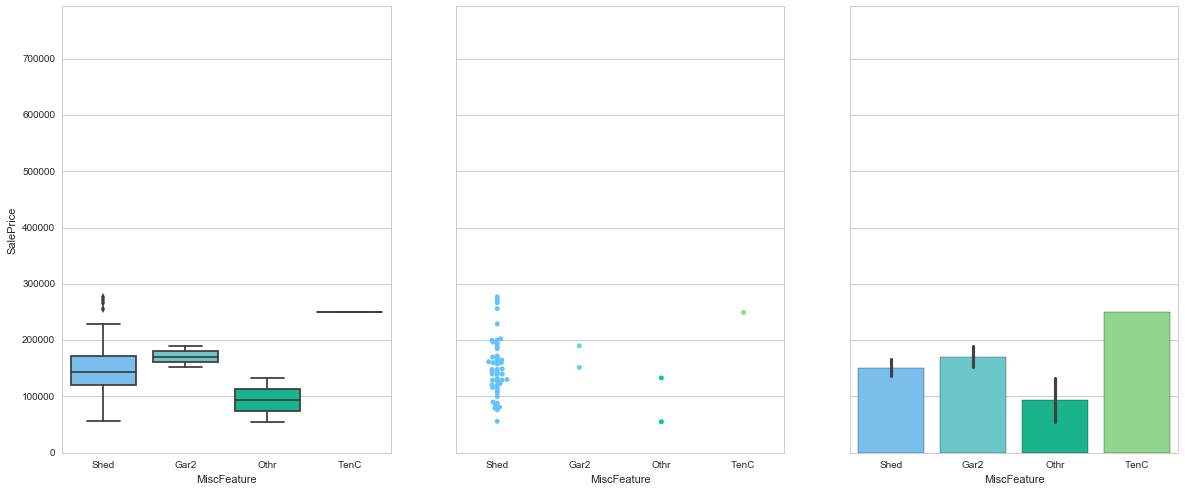

In [163]:
feature = 'MiscFeature'
order=None
fig, axarr = plt.subplots(1,3,figsize =(20, 8),sharey=True)

# plot
sns.boxplot(x=feature, y='SalePrice',data=train,ax=axarr[0],order=order)

# plot
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,ax=axarr[1],order=order)
axarr[1].set_ylabel("")

# purpose
sns.barplot(x=feature, y='SalePrice',data=train,ax=axarr[2],order=order)
axarr[2].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

**COMMENT**
- Onyl a small fraction of the datasat has a MiscFeature assigned. We drop this feature and the corresponding MiscVal.

In [164]:
columns=['MiscFeature', 'MiscVal']
all_data.drop(columns, axis=1, inplace=True)

**MoSold**

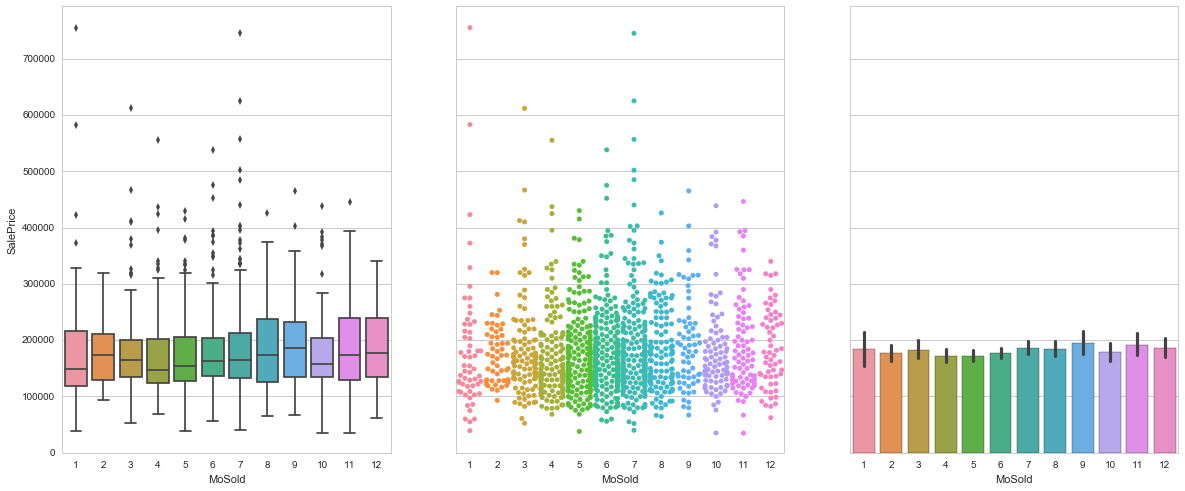

In [165]:
feature = 'MoSold'
order=None
fig, axarr = plt.subplots(1,3,figsize =(20, 8),sharey=True)

# plot
sns.boxplot(x=feature, y='SalePrice',data=train,ax=axarr[0],order=order)

# plot
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,ax=axarr[1],order=order)
axarr[1].set_ylabel("")

# purpose
sns.barplot(x=feature, y='SalePrice',data=train,ax=axarr[2],order=order)
axarr[2].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

**COMMENT**
- The data is mostly homogeniously distributed although a few months (summer) are more proned to sales.
- The month does not have a real impact on the sale price.
- The feature is converted into a set of dummy features.

In [166]:
all_data = pd.get_dummies(all_data, columns = ["MoSold"], prefix="MoSold")

**YrSold**

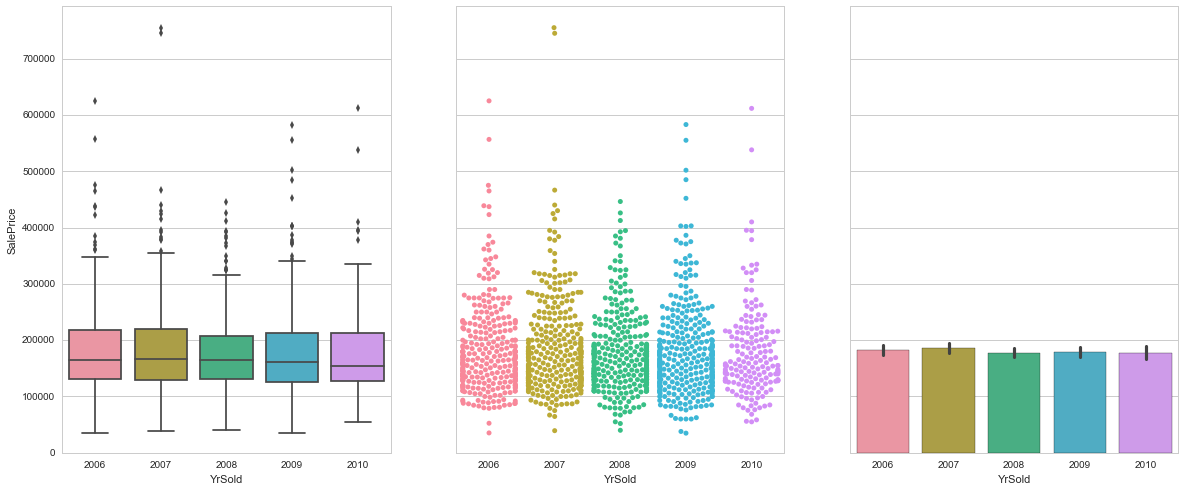

In [167]:
feature = 'YrSold'
order=None
fig, axarr = plt.subplots(1,3,figsize =(20, 8),sharey=True)

# plot
sns.boxplot(x=feature, y='SalePrice',data=train,ax=axarr[0],order=order)

# plot
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,ax=axarr[1],order=order)
axarr[1].set_ylabel("")

# purpose
sns.barplot(x=feature, y='SalePrice',data=train,ax=axarr[2],order=order)
axarr[2].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

**COMMENT**
- The observations made on the MoSold feature hold for teh YrSold feature.

In [168]:
all_data = pd.get_dummies(all_data, columns = ["YrSold"], prefix="YrSold")

**SaleType**

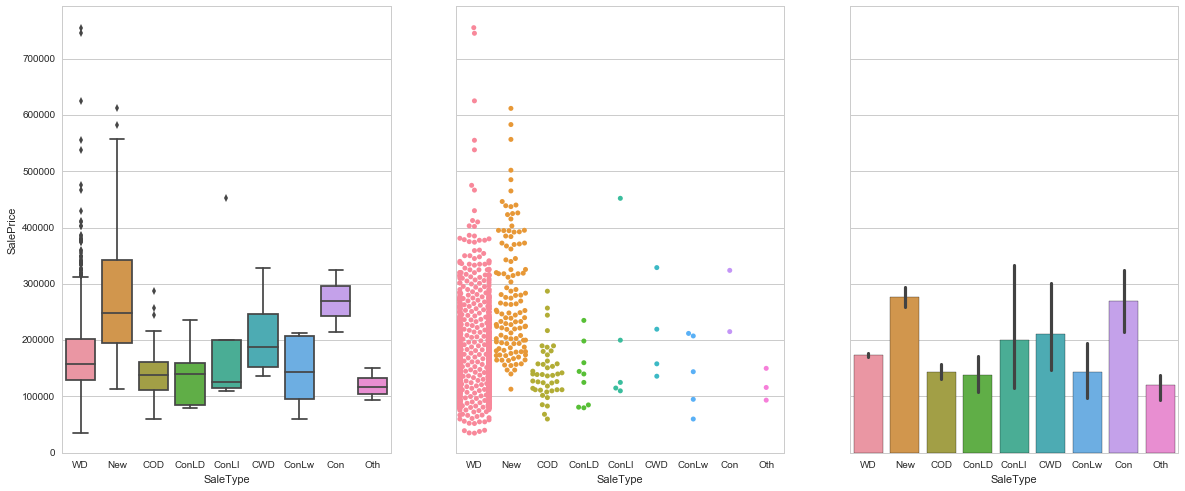

In [169]:
feature = 'SaleType'
order=None
fig, axarr = plt.subplots(1,3,figsize =(20, 8),sharey=True)

# plot
sns.boxplot(x=feature, y='SalePrice',data=train,ax=axarr[0],order=order)

# plot
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,ax=axarr[1],order=order)
axarr[1].set_ylabel("")

# purpose
sns.barplot(x=feature, y='SalePrice',data=train,ax=axarr[2],order=order)
axarr[2].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

**COMMENT**
- Most of the sales are contained in the "WD" features.
- The "New" feature has an higher average sale price.
- We group the other features which are populated by only a few records.

In [170]:
all_data['SaleType'] = all_data['SaleType'].map({"ConLD":"Other", "ConLI":"Other", 
                                                 "ConLw":"Other", "Con":"Other", "Oth":"Other"})

all_data = pd.get_dummies(all_data, columns = ["SaleType"], prefix="SaleType")

**SaleCondition**

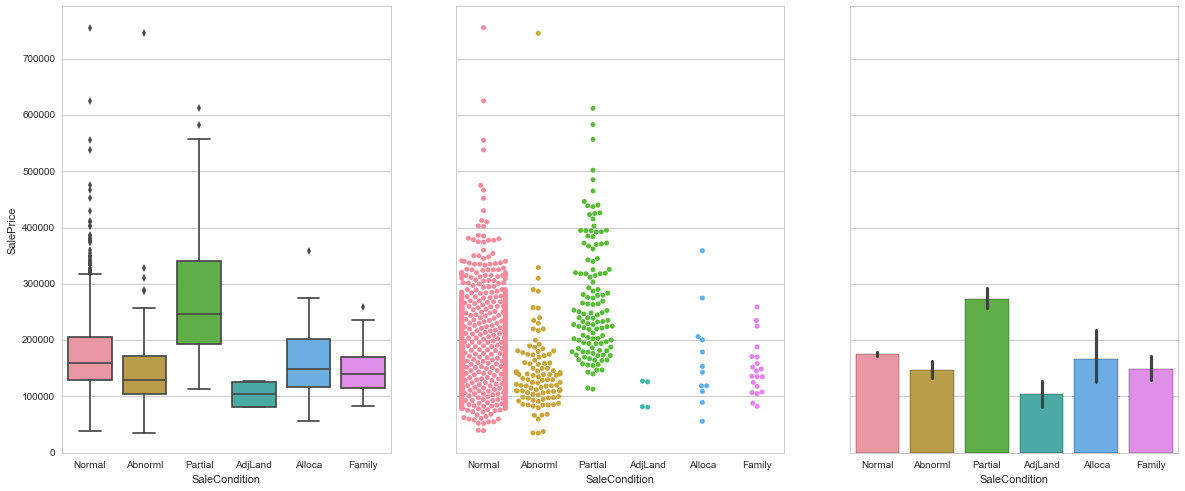

In [171]:
feature = 'SaleCondition'
order=None
fig, axarr = plt.subplots(1,3,figsize =(20, 8),sharey=True)

# plot
sns.boxplot(x=feature, y='SalePrice',data=train,ax=axarr[0],order=order)

# plot
plot = sns.swarmplot(x=feature, y='SalePrice',data=train,ax=axarr[1],order=order)
axarr[1].set_ylabel("")

# purpose
sns.barplot(x=feature, y='SalePrice',data=train,ax=axarr[2],order=order)
axarr[2].set_ylabel("")
axarr[0].set_ylim(0,train['SalePrice'].max()*1.05);

**COMMENT**
- Most of the data is contained in the "Normal" classs.  
- The sale condition seems to have a significant impact on the sale price as the sale price for each class differes from the ones of the other classes.
- One class has only a few records.

In [172]:
all_data = pd.get_dummies(all_data, columns = ["SaleCondition"], prefix="SaleCondition")

In [173]:
new_section("4. Sale Price Analysis")

The target variable is a continous numerical feature. When considering the properies of the target variable, the following properties are inspected:
- Distribution: Does the target follow a normal distribution or others?
- Range: Is the target strictly positive?
  
Since we are predicting a price, we expect the target to be positive. We now inspect its distribution.

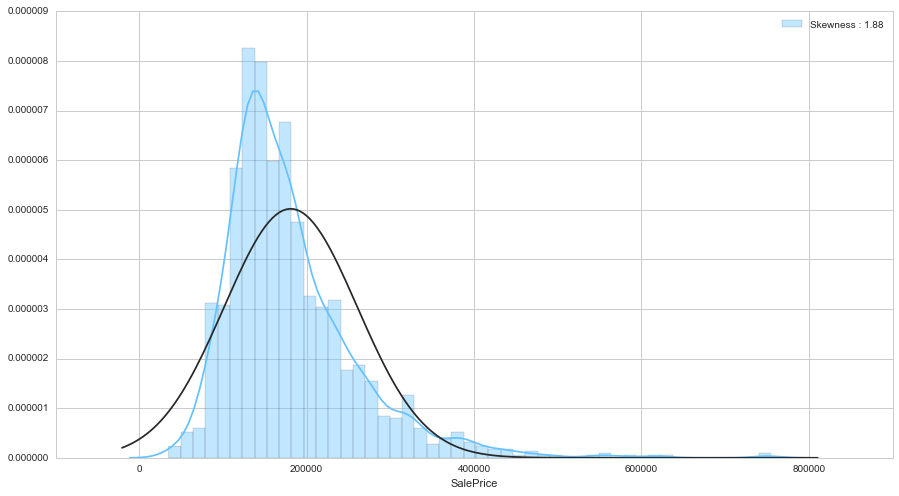

In [174]:
# plot distribution
plt.subplots(figsize=(15,8))
g = sns.distplot(train['SalePrice'], fit=norm, label = "Skewness : %.2f"%(train['SalePrice'].skew()))
g = g.legend(loc="best")

**COMMENT**
- The data is positively skewed.
- The data seems to follow a logarithmic distribution.

Since most of the ML algorithms perform best when dealing with normally distributed data, we transform the target feature to obtained the desired distribution.

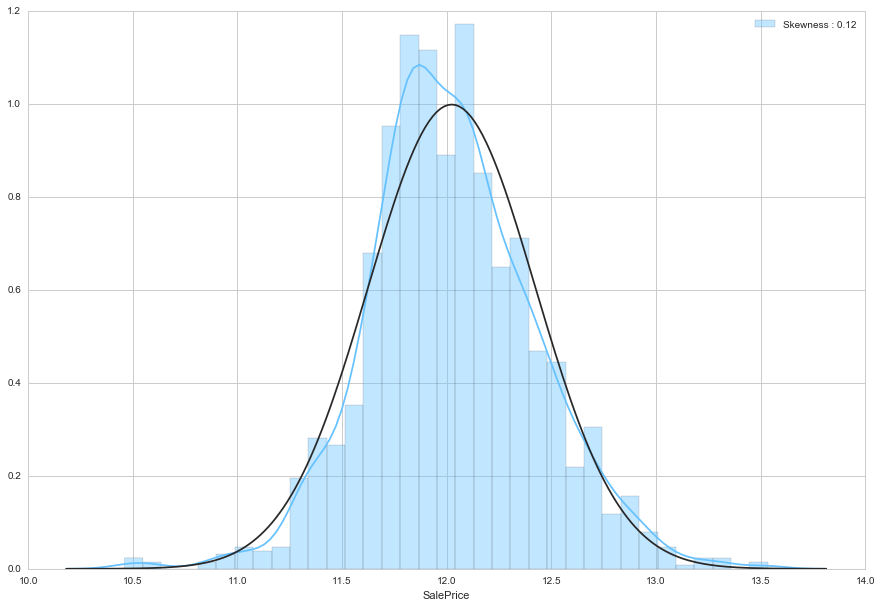

In [175]:
# apply the long function on the target 
train["SalePrice"] = np.log1p(train["SalePrice"])
y_train = train["SalePrice"]

# verify transformation
plt.subplots(figsize=(15, 10))
g = sns.distplot(train['SalePrice'], fit=norm, label = "Skewness : %.2f"%(train['SalePrice'].skew()));
g = g.legend(loc="best")

**COMMENT**
- The skewness is now relatively small and the log of the target feature can be considered as normally distributed.

Skewed features also impact negatively our models. We inspect how the different numerical feature stand in term of skewness.

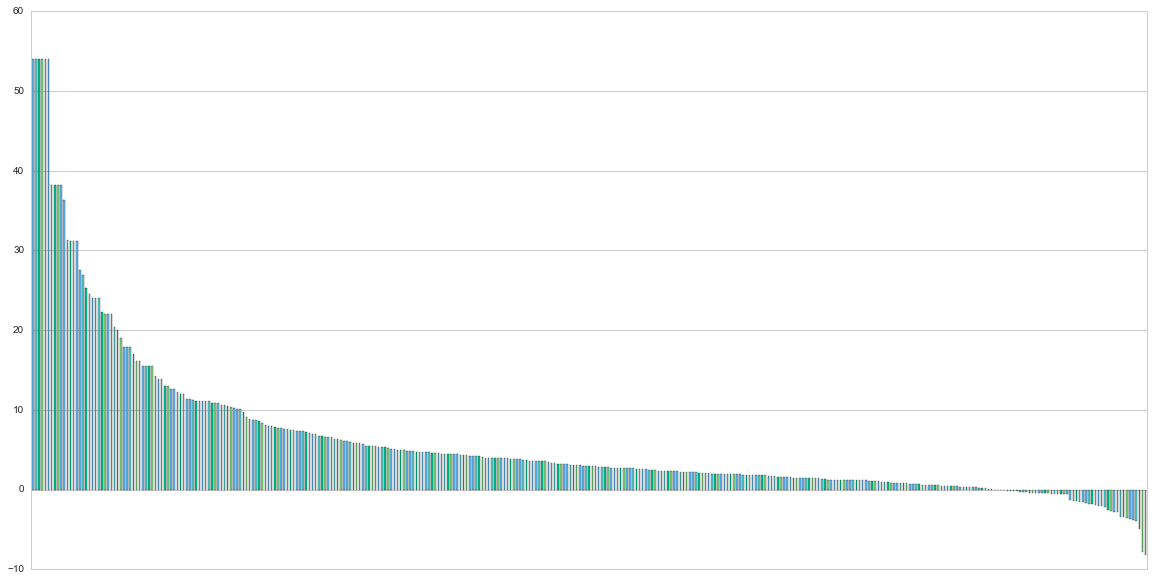

In [176]:
# Isolate numerical features
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Plot skewness
# 1. drop null
# 2. compute skewness
# 3. sort by skewness
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

plt.subplots(figsize =(20, 10))
g = skewed_feats.plot(kind='bar')
g.axes.get_xaxis().set_visible(False);

**COMMENT**
A large number of featuers are positively skewed. A small fraction are negatively skewed. A skewness of 0.25 is considered small enough. We will therefore transform all featues falling outside this range.

In [177]:
all_data.head()

LotFrontage  OverallQual  OverallCond  YearRemodAdd  ExterQual  BsmtQual  \
0         65.0            7            5          2003          3         3   
1         80.0            6            8          1976          2         3   
2         68.0            7            5          2002          3         3   
3         60.0            7            5          1970          2         2   
4         84.0            8            5          2000          3         3   

   BsmtCond  BsmtExposure  HeatingQC  CentralAir  BedroomAbvGr  KitchenAbvGr  \
0         3             1          5           1             3             1   
1         3             4          5           1             3             1   
2         3             2          5           1             3             1   
3         4             1          4           1             3             1   
4         3             3          5           1             4             1   

   KitchenQual  TotRmsAbvGrd  Functional  Fireplaces  FireplaceQu  GarageCars  \
0            3             8           7           0            0         2.0   
1            2             6           7           1            3         2.0   
2            3             6           7           1            3         2.0   
3            3             7           7           1            4         3.0   
4            3             9           7           1            3         3.0   

   OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  OverallQual-2  \
0           61              0          0            0             49   
1            0              0          0            0             36   
2           42              0          0            0             49   
3           35            272          0            0             49   
4           84              0          0            0             64   

   GrLivArea-2  TotalBsmtSF-2  GarageCars-2  GarageArea-2  1stFlrSF-2  \
0      2924100       732736.0           4.0      300304.0      732736   
1      1592644      1592644.0           4.0      211600.0     1592644   
2      3189796       846400.0           4.0      369664.0      846400   
3      2948089       571536.0           9.0      412164.0      923521   
4      4831204      1311025.0           9.0      698896.0     1311025   

   FullBath-2  TotRmsAbvGrd-2  YearBuilt-2  YearRemodAdd-2  GarageYrBlt-2  \
0           4              64      4012009         4012009      4012009.0   
1           4              36      3904576         3904576      3904576.0   
2           4              36      4004001         4008004      4004001.0   
3           1              49      3667225         3880900      3992004.0   
4           4              81      4000000         4000000      4000000.0   

   MasVnrArea-2  Fireplaces-2  BsmtFinSF1-2  LotFrontage-2  2ndFlrSF-2  \
0       38416.0             0      498436.0         4225.0      729316   
1           0.0             1      956484.0         6400.0           0   
2       26244.0             1      236196.0         4624.0      749956   
3           0.0             1       46656.0         3600.0      571536   
4      122500.0             1      429025.0         7056.0     1108809   

   WoodDeckSF-2  OpenPorchSF-2  HalfBath-2  LotArea-2  BsmtFullBath-2  \
0             0           3721           1   71402500             1.0   
1         88804              0           0   92160000             0.0   
2             0           1764           1  126562500             1.0   
3             0           1225           0   91202500             1.0   
4         36864           7056           1  203347600             1.0   

   BsmtUnfSF-2  OverallQual-3  GrLivArea-3  TotalBsmtSF-3  GarageCars-3  \
0      22500.0            343   5000211000   6.272220e+08           8.0   
1      80656.0            216   2009916728   2.009917e+09           8.0   
2     188356.0            343   5696975656   7.786880e+08           8.0   
3     291600.0            343   506186881

In [178]:
# locate target features
skewed_features = skewed_feats[abs(skewed_feats) > 0.50].index

# Box-Cox power transformation
for feature in skewed_features:
    all_data[feature] = boxcox1p(all_data[feature],0.15)

In [179]:
all_data.head()

LotFrontage  OverallQual  OverallCond  YearRemodAdd  ExterQual  BsmtQual  \
0     5.831328            7     2.055642          2003   1.540963         3   
1     6.221214            6     2.602594          1976   1.194318         3   
2     5.914940            7     2.055642          2002   1.540963         3   
3     5.684507            7     2.055642          1970   1.194318         2   
4     6.314735            8     2.055642          2000   1.540963         3   

   BsmtCond  BsmtExposure  HeatingQC  CentralAir  BedroomAbvGr  KitchenAbvGr  \
0  1.540963      0.730463   2.055642    0.730463             3      0.730463   
1  1.540963      1.820334   2.055642    0.730463             3      0.730463   
2  1.540963      1.194318   2.055642    0.730463             3      0.730463   
3  1.820334      0.730463   1.820334    0.730463             3      0.730463   
4  1.540963      1.540963   2.055642    0.730463             4      0.730463   

   KitchenQual  TotRmsAbvGrd  Functional  Fireplaces  FireplaceQu  GarageCars  \
0            3      2.602594    2.440268    0.000000            0         2.0   
1            2      2.259674    2.440268    0.730463            3         2.0   
2            3      2.259674    2.440268    0.730463            3         2.0   
3            3      2.440268    2.440268    0.730463            4         3.0   
4            3      2.750250    2.440268    0.730463            3         3.0   

   OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  OverallQual-2  \
0     5.714669       0.000000        0.0          0.0       5.321541   
1     0.000000       0.000000        0.0          0.0       4.792130   
2     5.053371       0.000000        0.0          0.0       5.321541   
3     4.745132       8.797736        0.0          0.0       5.321541   
4     6.314735       0.000000        0.0          0.0       5.802739   

   GrLivArea-2  TotalBsmtSF-2  GarageCars-2  GarageArea-2  1stFlrSF-2  \
0    55.535798      43.875163      1.820334     37.545635   43.875163   
1    50.117413      50.117413      1.820334     35.283762   50.117413   
2    56.352579      44.980341      1.820334     38.945425   44.980341   
3    55.612078      42.026206      2.750250     39.696107   45.660332   
4    60.401597      48.483958      2.750250     43.517962   48.483958   

   FullBath-2  TotRmsAbvGrd-2  YearBuilt-2  YearRemodAdd-2  GarageYrBlt-2  \
0    1.820334        5.802739    58.558176         4012009      58.558176   
1    1.820334        4.792130    58.293157         3904576      58.293157   
2    1.820334        4.792130    58.538631         4008004      58.538631   
3    0.730463        5.321541    57.684940         3880900      58.509288   
4    1.820334        6.244956    58.528854         4000000      58.528854   

   MasVnrArea-2  Fireplaces-2  BsmtFinSF1-2  LotFrontage-2  2ndFlrSF-2  \
0     25.811182      0.000000     41.036837      16.657072   43.839707   
1      0.000000      0.730463     45.936328      18.155856    0.000000   
2     24.007002      0.730463     35.981454      16.974859   44.051576   
3      0.000000      0.730463     26.771793      16.103815   42.026206   
4     31.981570      0.730463     39.975776      18.521802   47.115378   

   WoodDeckSF-2  OpenPorchSF-2  HalfBath-2   LotArea-2  BsmtFullBath-2  \
0      0.000000      16.216978    0.730463   93.786991        0.730463   
1     30.161013       0.000000    0.000000   97.706801        0.000000   
2      0.000000      13.794031    0.730463  102.793095        0.730463   
3      0.000000      12.705684    0.000000   97.543419        0.730463   
4     25.610907      18.521802    0.730463  110.862214        0.730463   

   BsmtUnfSF-2  OverallQual-3  GrLivArea-3  TotalBsmtSF-3  GarageCars-3  \
0    23.306941       9.343377   183.334816     132.495741      2.602594   
1    29.633202       8.274266   159.057350     159.057350      2.602594   
2    34.557891       9.343377   187.089438     137.085124      2.602594   
3    37.351008       9.343377   183

We control the results of the transformation.

In [180]:
new_section("5. Models")

We first re-construct the train and test set.

In [181]:
train = all_data[:n_train]
test = all_data[n_train:]

# control
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (1458, 355)
Test shape: (1459, 355)


Once the training and test sets are ready, the preparation of the models can be performed. While investigating the relationship between each feature and the target, we have created a large number of dummy features. It is essential to perform a feature selection before feeding our dataset into a model.

In [182]:
# create an xgb regressor
model = xgb.XGBRegressor()

# fit the model
model.fit(train, y_train)

# sort features by importances
indices = np.argsort(model.feature_importances_)[::-1]
n_feature = len(model.feature_importances_[model.feature_importances_>0])
print(n_feature," features are important.")
indices = indices[0:n_feature]

100  features are important.


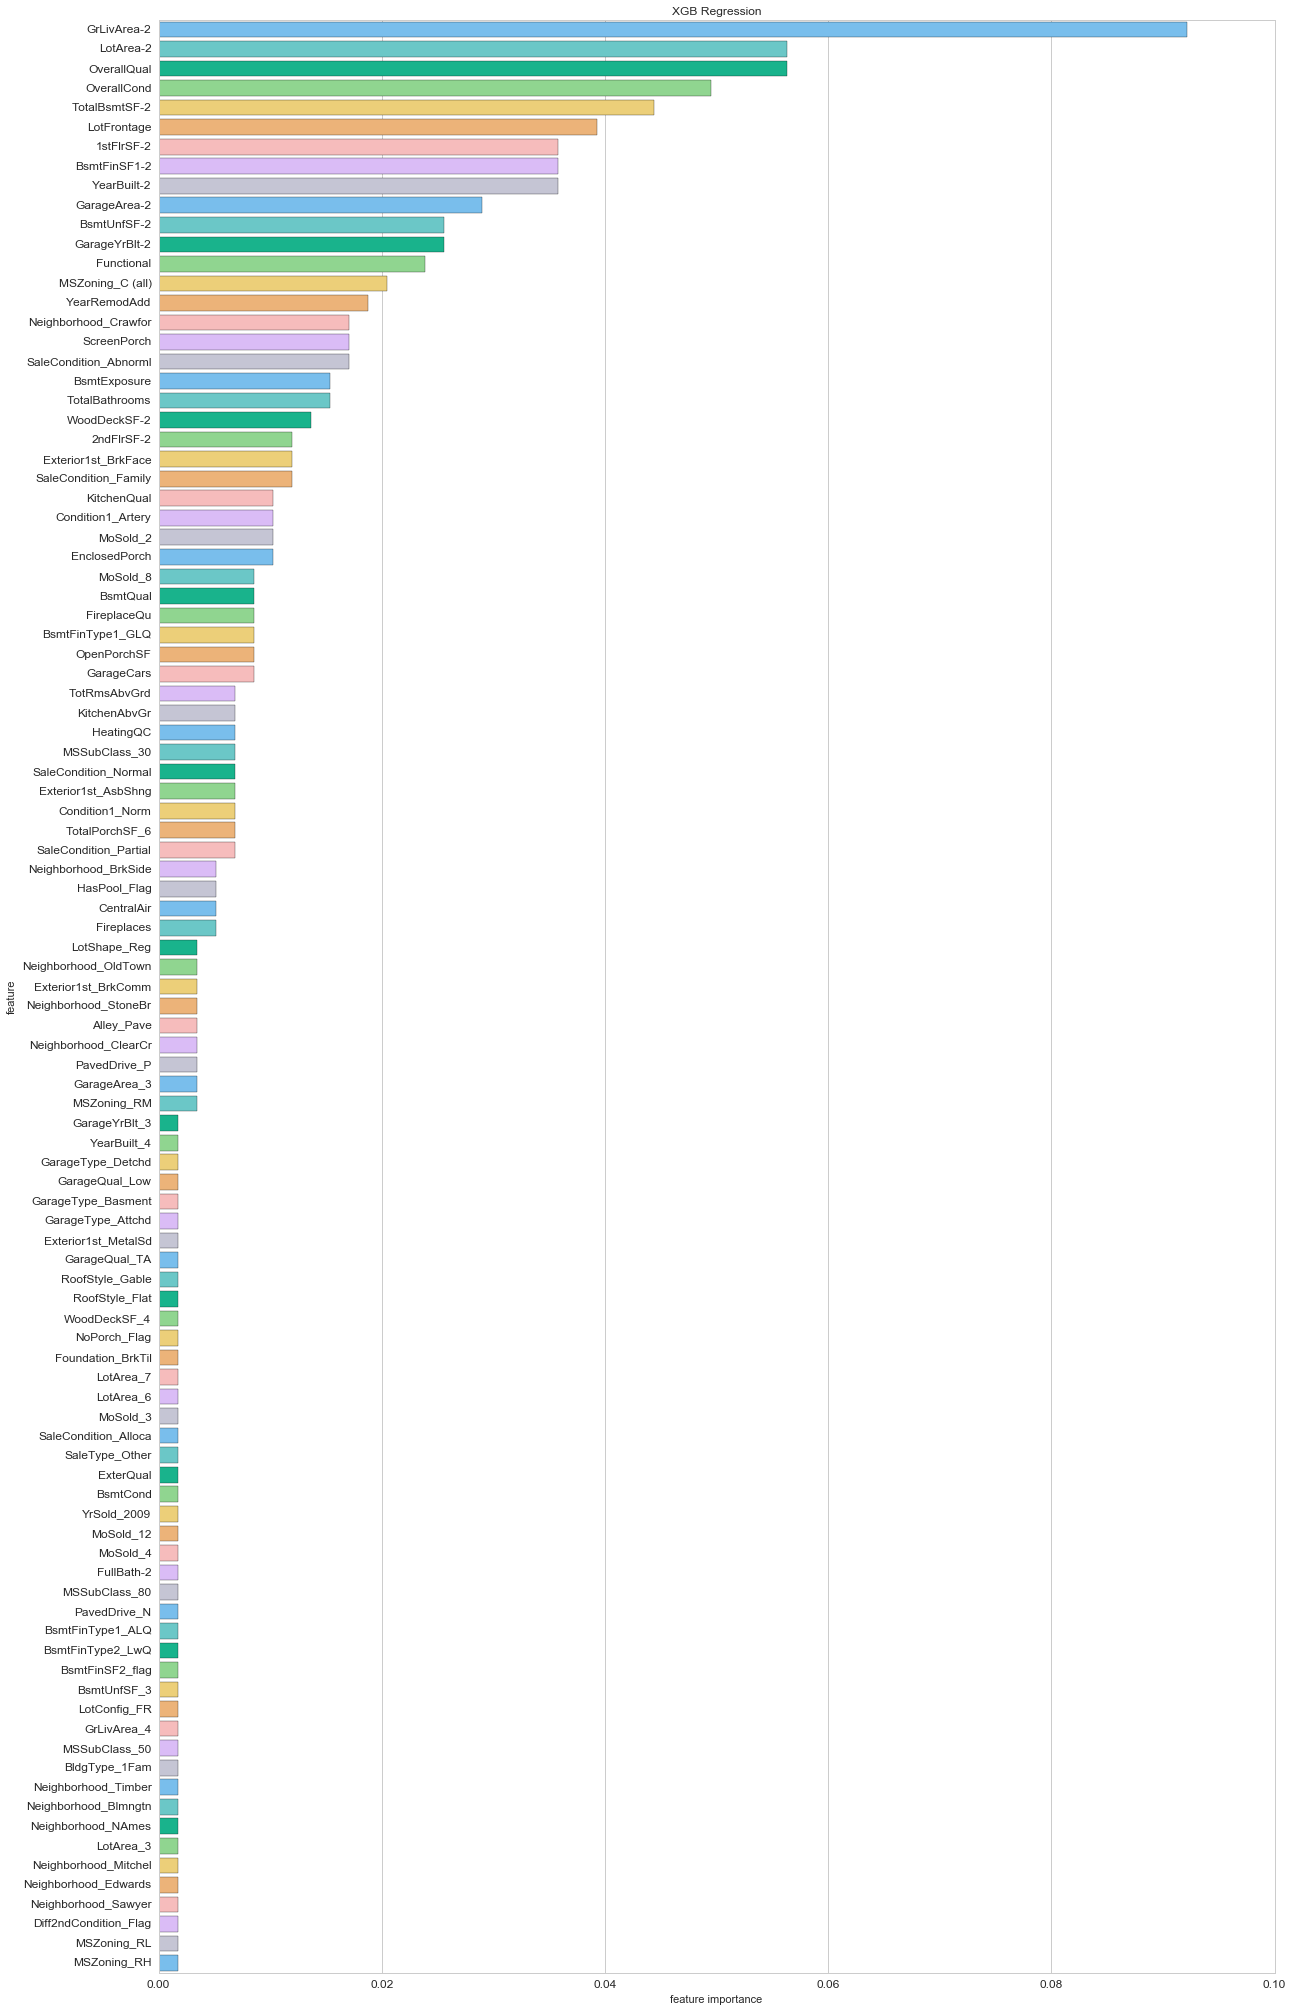

In [183]:
# plot the feature importances
plt.subplots(figsize=(20,35))
g = sns.barplot(y=train.columns[indices],x=model.feature_importances_[indices],palette = mycols)
g.set_xlabel('feature importance')
g.set_ylabel('feature')
g.set_title('XGB Regression')
g.tick_params(labelsize=12);

In [184]:
# feature selection
xgb_reduced = SelectFromModel(estimator=model, prefit=True)

x_train_trans = xgb_reduced.transform(train)
x_test_trans = xgb_reduced.transform(test)

# print selection summary
print("There are %i features selected" % x_train_trans.shape[1])

There are 56 features selected


In [185]:
# train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(x_train_trans, y_train, test_size=0.25, random_state=1)

We now train our models. We will be using the followings:
- AdaBoost
- GradientBoosting
- ElasticNet
- Random Forest
- Gaussian Process
- KNN
- Kernel Ridge
- Lasso

In [186]:
# considered models
models = [KernelRidge(),ElasticNet(), Lasso(), BayesianRidge(), LassoLarsIC(), RandomForestRegressor(), GradientBoostingRegressor(), xgb.XGBRegressor()]

shuff = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# results summary
summary_cols = ['Model', 'Parameters (Pre)', 'Training accuracy (Pre)', 'Testing accuracy (Pre)', 'Parameters (Post)', 'Training accuracy (Post)', 'Testing accuracy (Post)']
summary_df = pd.DataFrame(columns=summary_cols)

for idx, algo in enumerate(models):
    
    # identify the model
    name = algo.__class__.__name__
    summary_df.loc[idx,'Model'] = name
    summary_df.loc[idx,'Parameters (Pre)'] = str(algo.get_params())
    
    # fit model
    algo.fit(X_train, Y_train)
    
    # compute metrics
    training_results = np.sqrt((-cross_val_score(algo, X_train, Y_train, cv = shuff, scoring= 'neg_mean_squared_error')).mean())
    test_results = np.sqrt(((Y_test-algo.predict(X_test))**2).mean())
    
    summary_df.loc[idx,'Training accuracy (Pre)'] = training_results * 100
    summary_df.loc[idx,'Testing accuracy (Pre)'] = test_results * 100
    print(algo.__class__.__name__, 'trained...')

summary_df['Training accuracy (Pre)'] = summary_df['Training accuracy (Pre)'].apply(lambda x: round(x, decimals))
summary_df['Testing accuracy (Pre)'] = summary_df['Testing accuracy (Pre)'].apply(lambda x: round(x, decimals))

print("Summary without hyper-parameter tuning:")
summary_df

KernelRidge trained...
ElasticNet trained...
Lasso trained...
BayesianRidge trained...
LassoLarsIC trained...
RandomForestRegressor trained...
GradientBoostingRegressor trained...
XGBRegressor trained...
Summary without hyper-parameter tuning:


Model  \
0                KernelRidge   
1                 ElasticNet   
2                      Lasso   
3              BayesianRidge   
4                LassoLarsIC   
5      RandomForestRegressor   
6  GradientBoostingRegressor   
7               XGBRegressor   

                                    Parameters (Pre)  Training accuracy (Pre)  \
0  {'alpha': 1, 'coef0': 1, 'degree': 3, 'gamma':...                    10.68   
1  {'alpha': 1.0, 'copy_X': True, 'fit_intercept'...                    19.28   
2  {'alpha': 1.0, 'copy_X': True, 'fit_intercept'...                    25.64   
3  {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'compute_...                    10.72   
4  {'copy_X': True, 'criterion': 'aic', 'eps': 2....                    11.99   
5  {'bootstrap': True, 'criterion': 'mse', 'max_d...                    14.04   
6  {'alpha': 0.9, 'criterion': 'friedman_mse', 'i...                    11.90   
7  {'base_score': 0.5, 'booster': 'gbtree', 'cols...                    11.98   

   Testing accuracy (Pre) Parameters (Post) Training accuracy (Post)  \
0                   12.16               NaN                      NaN   
1                   20.17               NaN                      NaN   
2                   25.91               NaN                      NaN   
3                   12.11               NaN                      NaN   
4                   12.79               NaN                      NaN   
5                   14.84               NaN                      NaN   
6                   12.14               NaN                      NaN   
7                   12.44               NaN                      NaN   

  Testing accuracy (Post)  
0                     NaN  
1                     NaN  
2                     NaN  
3                     NaN  
4                     NaN  
5                     NaN  
6                     NaN  
7                     NaN

Now that the raw performances of the algorithms have been evaluated, we tune the hyper-parameters of each models.

**NOTE:** I have purged the candidates for each inputs and kept only the optimal parameters for computing efficiency.

In [187]:
models = [KernelRidge(),ElasticNet(), Lasso(), BayesianRidge(), LassoLarsIC(),
          RandomForestRegressor(), GradientBoostingRegressor(), xgb.XGBRegressor()]

# Kernel Ridge
KR_params = {'alpha': np.arange(0.1,1,0.1), 'coef0':np.arange(10,100,10), 'degree':[1], 'gamma': [None],
             'kernel':['linear','polynomial']}
# Elastic Net
EL_params = {'alpha': [0.001], 'copy_X': [True], 'l1_ratio': [0.6], 'fit_intercept': [True], 'normalize': [False], 
                         'precompute': [False], 'max_iter': [30000], 'tol': [0.001], 'selection': ['random'], 'random_state': [None]}
# Lasso
LASS_params = {'alpha': [0.0005], 'copy_X': [True], 'fit_intercept': [True], 'normalize': [False], 'precompute': [False], 
                    'max_iter': [300], 'tol': [0.01], 'selection': ['random'], 'random_state': [None]}

# Bayesian Ridge
BR_params = {'n_iter': [200], 'tol': [0.00001], 'alpha_1': [0.00000001], 'alpha_2': [0.000005], 'lambda_1': [0.000005],
             'lambda_2': [0.00000001], 'copy_X': [True]}

# Lasso Lars
LL_params = {'criterion': ['aic'], 'normalize': [True], 'max_iter': [100], 'copy_X': [True],
             'precompute': ['auto'], 'eps': [0.000001]}

# Random Forest Regressor
RdmF_params = {'n_estimators': [50], 'max_features': ['auto'], 'max_depth': [None], 'min_samples_split': [5], 'min_samples_leaf': [2]}

# Gradient Boost
GB_params = {'loss': ['huber'], 'learning_rate': [0.1], 'n_estimators': [300], 'max_depth': [3], 
             'min_samples_split': [0.0025], 'min_samples_leaf': [5]}

#XGB Regressor
XGB_params = {'max_depth': [3], 'learning_rate': [0.1], 'n_estimators': [300], 'booster': ['gbtree'], 'gamma': [0], 'reg_alpha': [0.1],
              'reg_lambda': [0.7], 'max_delta_step': [0], 'min_child_weight': [1], 'colsample_bytree': [0.5], 'colsample_bylevel': [0.2],
              'scale_pos_weight': [1]}

# parameters
params = [KR_params,EL_params,LASS_params,BR_params,LL_params,RdmF_params,GB_params,XGB_params]

for idx, algo in enumerate(models):
    # create grid
    grid_alg = GridSearchCV(estimator=algo, param_grid=params[idx],cv=shuff,
                           scoring='neg_mean_squared_error',n_jobs=-1)
    
    #set name and parameters
    model_name = algo.__class__.__name__
    #summary_df.loc[idx, 'Model'] = model_name
    
    # fit model and retrieve the best set of hyper-parameters
    grid_alg.fit(X_train, Y_train)
    gs_best = grid_alg.best_estimator_
    summary_df.loc[idx, 'Parameters (Post)'] = str(grid_alg.best_params_)
    
    # score
    after_training_results = np.sqrt(-grid_alg.best_score_)
    after_test_results = np.sqrt(((Y_test-grid_alg.predict(X_test))**2).mean())
    
    summary_df.loc[idx, 'Training accuracy (Post)'] = (after_training_results)*100
    summary_df.loc[idx, 'Testing accuracy (Post)'] = (after_test_results)*100
    print(algo.__class__.__name__, 'trained...')
    
summary_df['Training accuracy (Post)'] = summary_df['Training accuracy (Post)'].apply(lambda x: round(x, decimals))
summary_df['Testing accuracy (Post)'] = summary_df['Testing accuracy (Post)'].apply(lambda x: round(x, decimals))

print("Summary:")
summary_df

KernelRidge trained...
ElasticNet trained...
Lasso trained...
BayesianRidge trained...
LassoLarsIC trained...
RandomForestRegressor trained...
GradientBoostingRegressor trained...
XGBRegressor trained...
Summary:


Model  \
0                KernelRidge   
1                 ElasticNet   
2                      Lasso   
3              BayesianRidge   
4                LassoLarsIC   
5      RandomForestRegressor   
6  GradientBoostingRegressor   
7               XGBRegressor   

                                    Parameters (Pre)  Training accuracy (Pre)  \
0  {'alpha': 1, 'coef0': 1, 'degree': 3, 'gamma':...                    10.68   
1  {'alpha': 1.0, 'copy_X': True, 'fit_intercept'...                    19.28   
2  {'alpha': 1.0, 'copy_X': True, 'fit_intercept'...                    25.64   
3  {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'compute_...                    10.72   
4  {'copy_X': True, 'criterion': 'aic', 'eps': 2....                    11.99   
5  {'bootstrap': True, 'criterion': 'mse', 'max_d...                    14.04   
6  {'alpha': 0.9, 'criterion': 'friedman_mse', 'i...                    11.90   
7  {'base_score': 0.5, 'booster': 'gbtree', 'cols...                    11.98   

   Testing accuracy (Pre)                                  Parameters (Post)  \
0                   12.16  {'alpha': 0.7000000000000001, 'coef0': 10, 'de...   
1                   20.17  {'alpha': 0.001, 'copy_X': True, 'fit_intercep...   
2                   25.91  {'alpha': 0.0005, 'copy_X': True, 'fit_interce...   
3                   12.11  {'alpha_1': 1e-08, 'alpha_2': 5e-06, 'copy_X':...   
4                   12.79  {'copy_X': True, 'criterion': 'aic', 'eps': 1e...   
5                   14.84  {'max_depth': None, 'max_features': 'auto', 'm...   
6                   12.14  {'learning_rate': 0.1, 'loss': 'huber', 'max_d...   
7                   12.44  {'booster': 'gbtree', 'colsample_bylevel': 0.2...   

   Training accuracy (Post)  Testing accuracy (Post)  
0                     10.68                    12.17  
1                     10.90                    12.17  
2                     10.80                    12.13  
3                     10.72                    12.11  
4                     11.99                    12.79  
5                     13.31                    13.78  
6                     11.96                    12.20  
7                     11.11                    11.78